# Factor correlation analysis
Perform simple correlation analysis between factors in the dataset.

In [1]:
import os
import torch
import numpy as np
import torchvision as tv
import plotly.express as px
import matplotlib.pyplot as plt

from specvae.vae import BaseVAE
import specvae.dataset as dt
import specvae.utils as utils

In [2]:
dataset = 'MoNA'
n_samples = 10000
spec_max_mz = 2500
max_num_peaks = 50
min_intensity = 0.1
normalize_intensity = True
normalize_mass = True

## Load and transform data

In [3]:
device, cpu = utils.device(use_cuda=True)

GPU device count: 1
Device in use:  cuda:0


### Load data

In [4]:
if dataset == 'MoNA':
    # labels = ['ionization_mode_id', 'collision_energy', 'total_exact_mass', 'precursor_mz', 'instrument_id', 'instrument_type_id', 'precursor_type_id', 'superclass_id', 'class_id']
    labels = ['ionization_mode_id', 'instrument_id', 'instrument_type_id', 'precursor_type_id', 'kingdom_id', 'superclass_id', 'class_id', 'collision_energy', 'precursor_mz', 'total_exact_mass']
    base_path = utils.get_project_path() / '.data' / 'MoNA'
    data_path = base_path / 'MoNA_full.csv'
    metadata_path = base_path / 'MoNA_meta.npy'
elif dataset == 'HMDB':
    labels = ['ionization_mode_id', 'collision_energy', 'superclass_id', 'class_id']
    base_path = utils.get_project_path() / '.data' / 'HMDB'
    data_path = base_path / 'HMDB_full.csv'
    metadata_path = base_path / 'HMDB_meta.npy'

metadata = None
if os.path.exists(metadata_path):
    metadata = np.load(metadata_path, allow_pickle=True).item()

In [5]:
df = dt.Spectra.open(data_path)

### Transform data

In [6]:
columns = ['spectrum'] + labels
types = [torch.float32] * len(columns)

In [7]:
transform = tv.transforms.Compose([
    dt.SplitSpectrum(),
    dt.TopNPeaks(n=max_num_peaks),
    dt.FilterPeaks(max_mz=spec_max_mz, min_intensity=min_intensity),
    # dt.UpscaleIntensity(max_mz=spec_max_mz),
    dt.ToMZIntConcatAlt(max_num_peaks=max_num_peaks),
    # dt.Int2OneHot('instrument_type_id', 39),
    # dt.Int2OneHot('precursor_type_id', 73),
    # dt.Int2OneHot('superclass_id', 22),
    # dt.Int2OneHot('class_id', 253),
    # dt.Int2OneHot('subclass_id', 405),
    # dt.Int2OneHot('kingdom_id', 2),
])

In [8]:
# data = dt.Spectra.preload_tensor(device=device, data_frame=df[columns + ['id']], transform=transform, limit=n_samples, types=types, do_print=True)

## Correlation analysis

In [9]:
import seaborn as sns

In [10]:
labels

['ionization_mode_id',
 'instrument_id',
 'instrument_type_id',
 'precursor_type_id',
 'kingdom_id',
 'superclass_id',
 'class_id',
 'collision_energy',
 'precursor_mz',
 'total_exact_mass']

In [11]:
df1 = df
if n_samples > 0:
    df1 = df.sample(n=n_samples, random_state=123)

In [12]:
pc = df1[labels].fillna(0.).corr()
pc

ionization_mode_id  instrument_id  instrument_type_id  \
ionization_mode_id            1.000000      -0.142056           -0.103634   
instrument_id                -0.142056       1.000000            0.388373   
instrument_type_id           -0.103634       0.388373            1.000000   
precursor_type_id            -0.201687       0.181930            0.188138   
kingdom_id                    0.005598       0.021096           -0.016756   
superclass_id                -0.029963      -0.022236           -0.054210   
class_id                      0.001509      -0.080683           -0.012602   
collision_energy              0.039790      -0.249334           -0.038650   
precursor_mz                 -0.071578      -0.015312           -0.132063   
total_exact_mass             -0.084452      -0.023755           -0.093972   

                    precursor_type_id  kingdom_id  superclass_id  class_id  \
ionization_mode_id          -0.201687    0.005598      -0.029963  0.001509   
instrument_id                0.181930    0.021096      -0.022236 -0.080683   
instrument_type_id           0.188138   -0.016756      -0.054210 -0.012602   
precursor_type_id            1.000000    0.010198       0.032399  0.085306   
kingdom_id                   0.010198    1.000000       0.018282 -0.006131   
superclass_id                0.032399    0.018282       1.000000 -0.006526   
class_id                     0.085306   -0.006131      -0.006526  1.000000   
collision_energy            -0.047178    0.016610      -0.065463 -0.030242   
precursor_mz                 0.130874    0.024093       0.005604  0.219751   
total_exact_mass             0.135498    0.018482      -0.001187  0.232683   

                    collision_energy  precursor_mz  total_exact_mass  
ionization_mode_id          0.039790     -0.071578         -0.084452  
instrument_id              -0.249334     -0.015312         -0.023755  
instrument_type_id         -0.038650     -0.132063         -0.093972  
precursor_type_id          -0.047178      0.130874          0.135498  
kingdom_id                  0.016610      0.024093          0.018482  
superclass_id              -0.065463      0.005604         -0.001187  
class_id                   -0.030242      0.219751          0.232683  
collision_energy            1.000000     -0.026426         -0.055742  
precursor_mz               -0.026426      1.000000          0.961761  
total_exact_mass           -0.055742      0.961761          1.000000

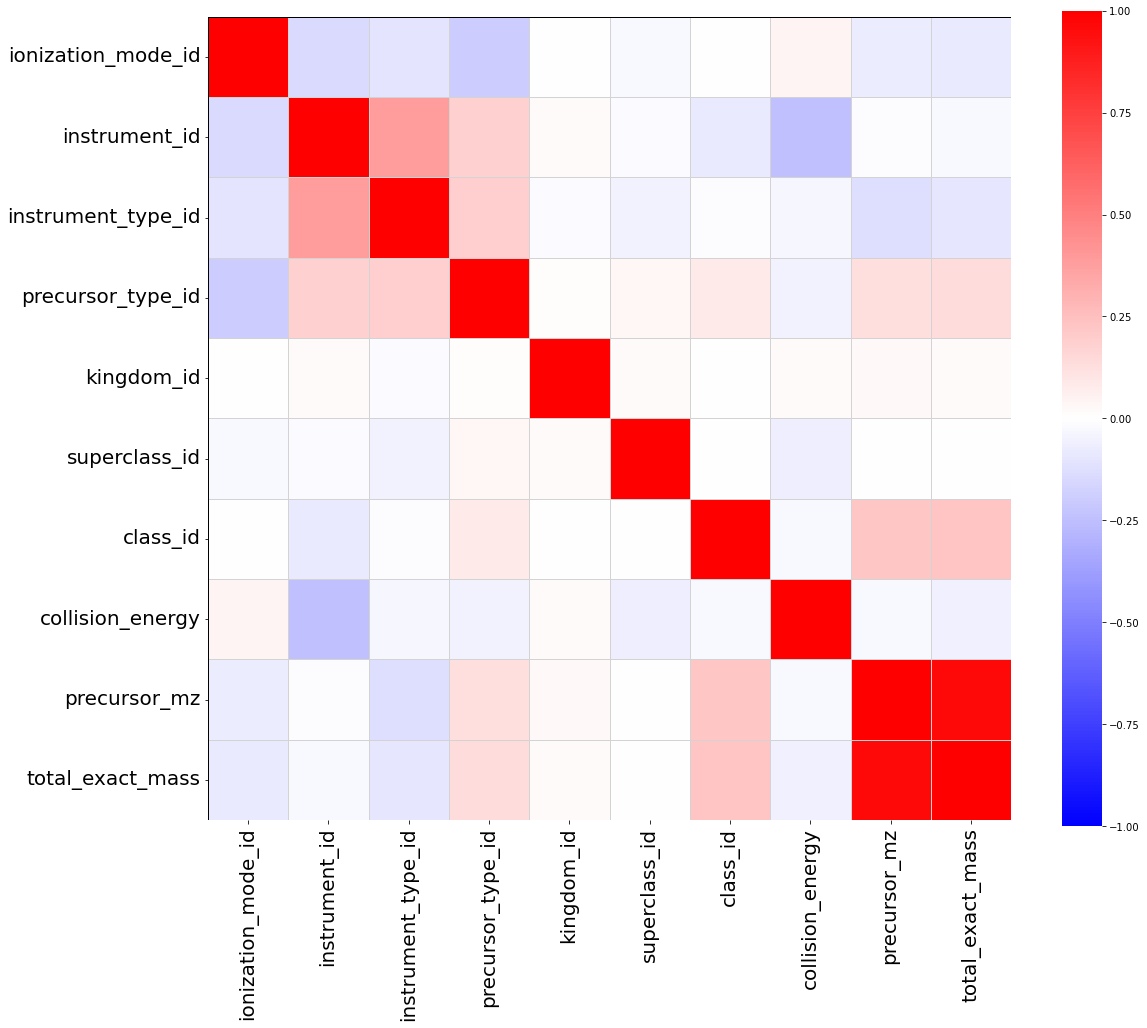

In [45]:
fig, ax = plt.subplots(figsize=(18, 15))
# sns.heatmap(pc, annot=True, annot_kws={"size": 14})
sns.heatmap(pc, square=True, cmap='bwr', vmin=-1, vmax=1, linewidth=1, linecolor='lightgrey', ax=ax)
plt.yticks(rotation=0, font={'size': 20})
plt.xticks(rotation=90, font={'size': 20})

ax.axhline(y=0, color='k', linewidth=1)
ax.axhline(y=pc.shape[1], color='k', linewidth=1)
ax.axvline(x=0, color='k', linewidth=1)
ax.axvline(x=pc.shape[0], color='k', linewidth=1)

plt.savefig('../.img/corr-heatmap-mona.svg')

### Overall

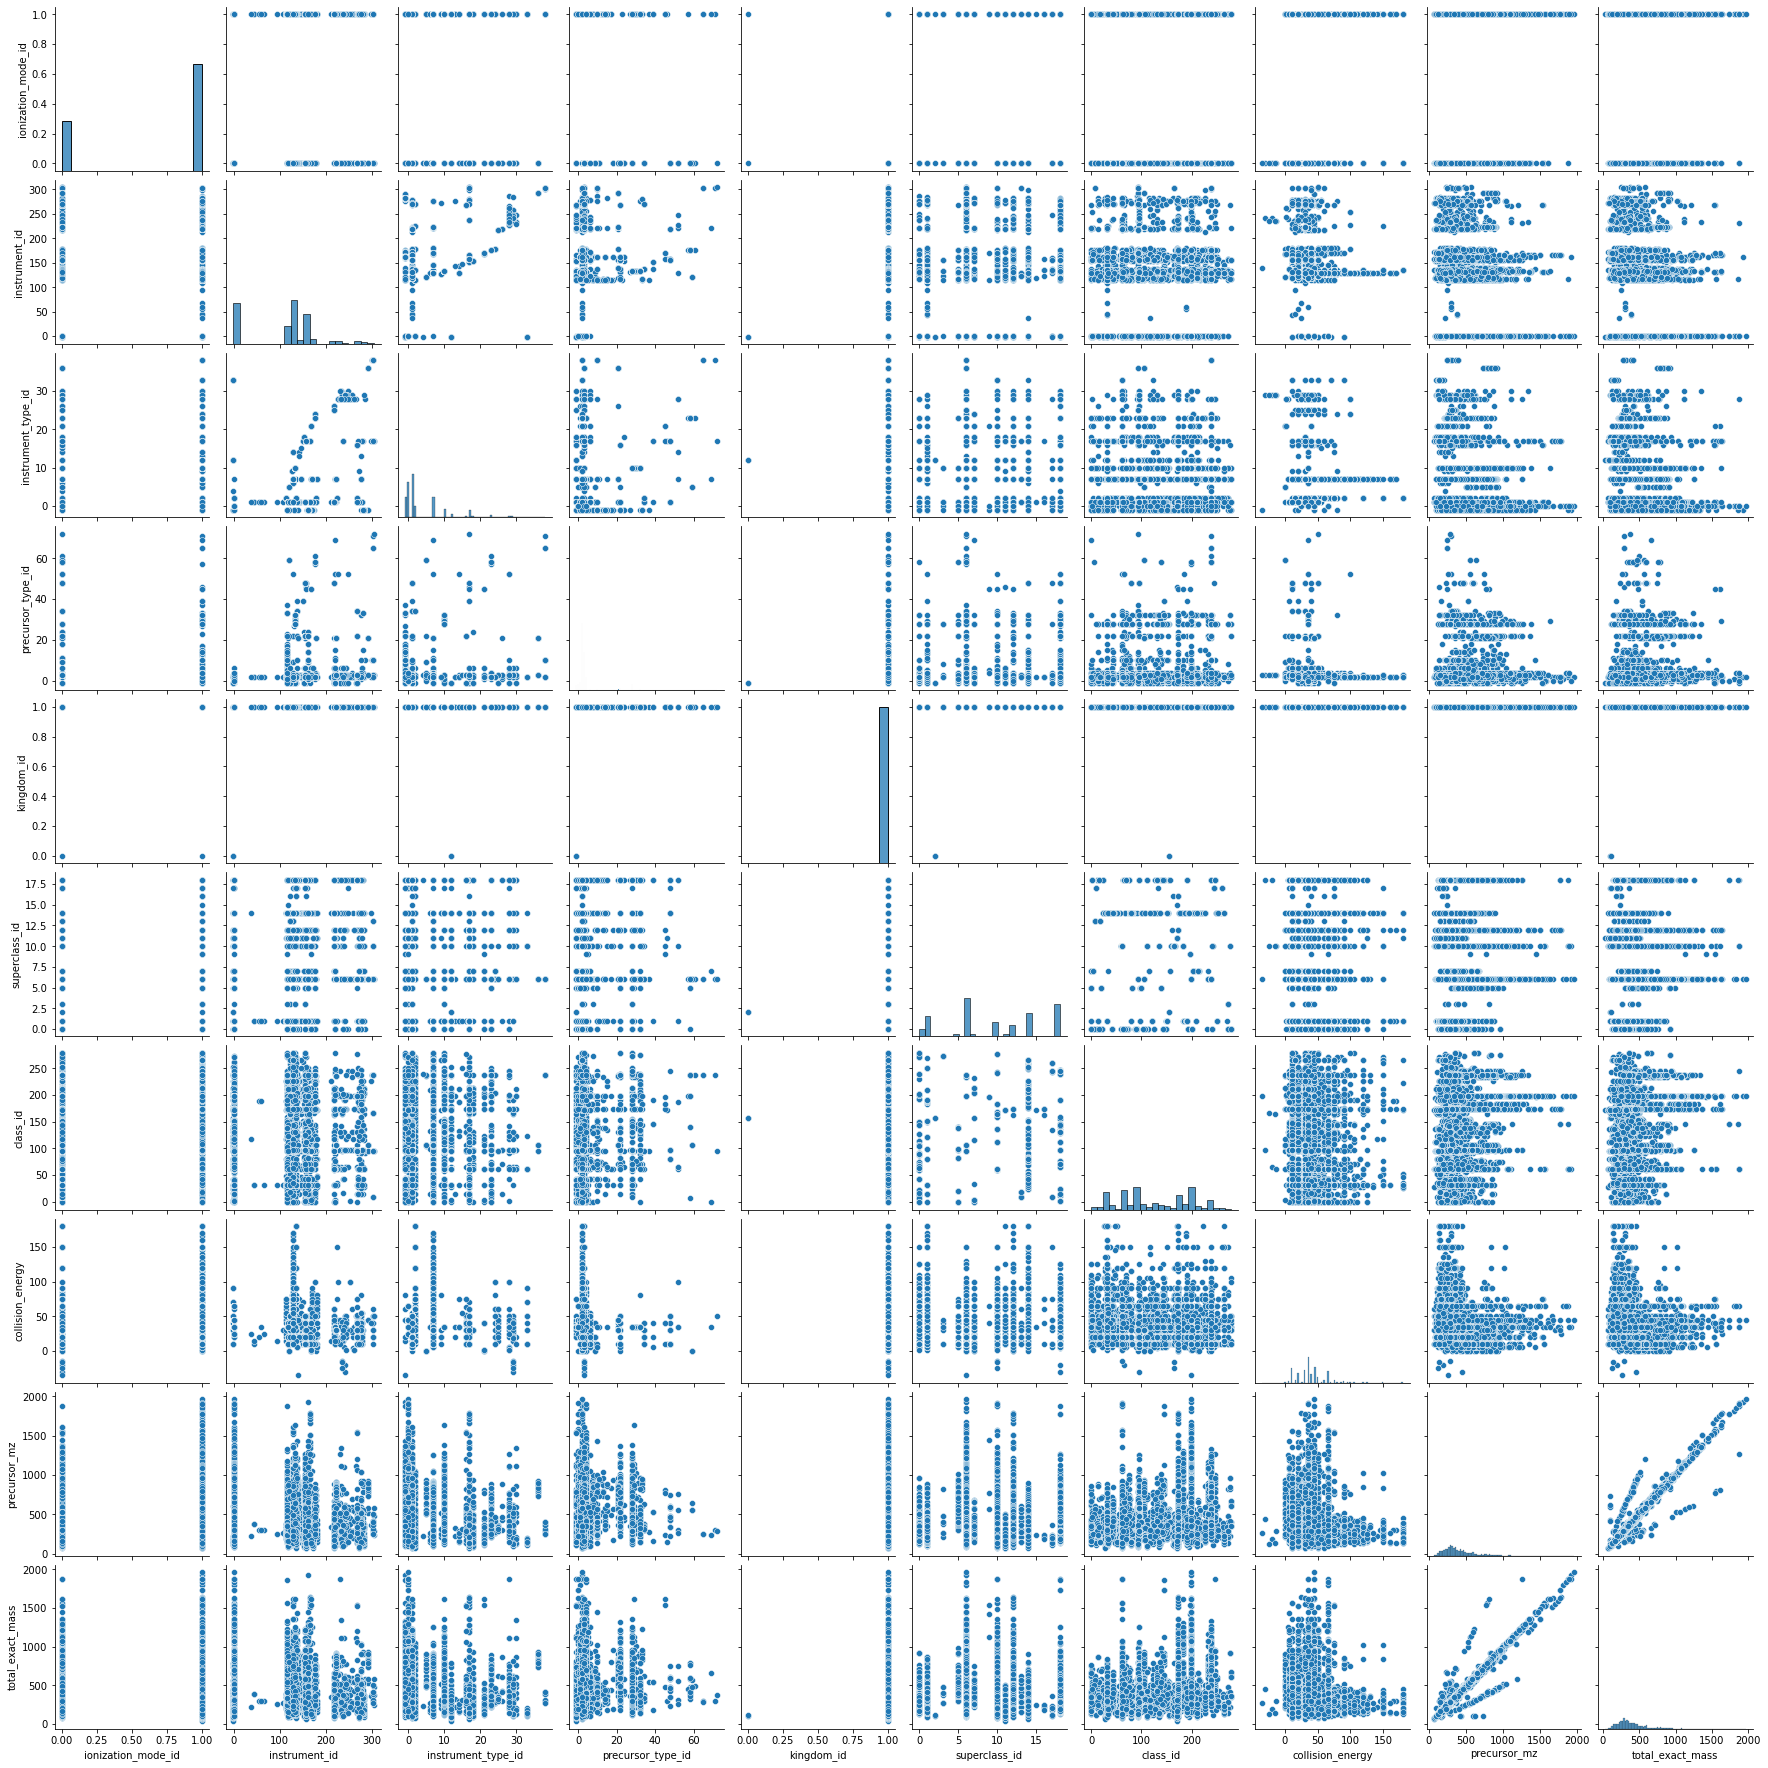

In [14]:
sns.pairplot(df1[labels])

### Per each feature pair

In [15]:
import itertools as it

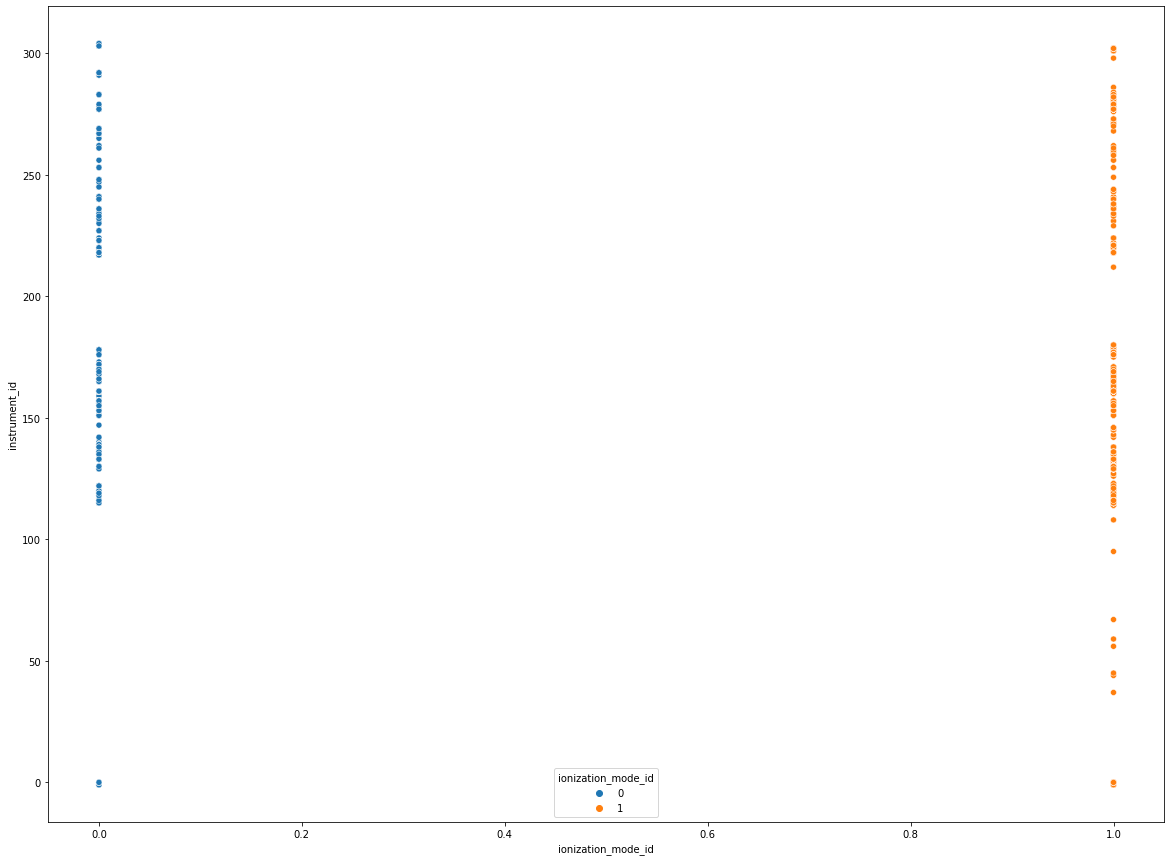

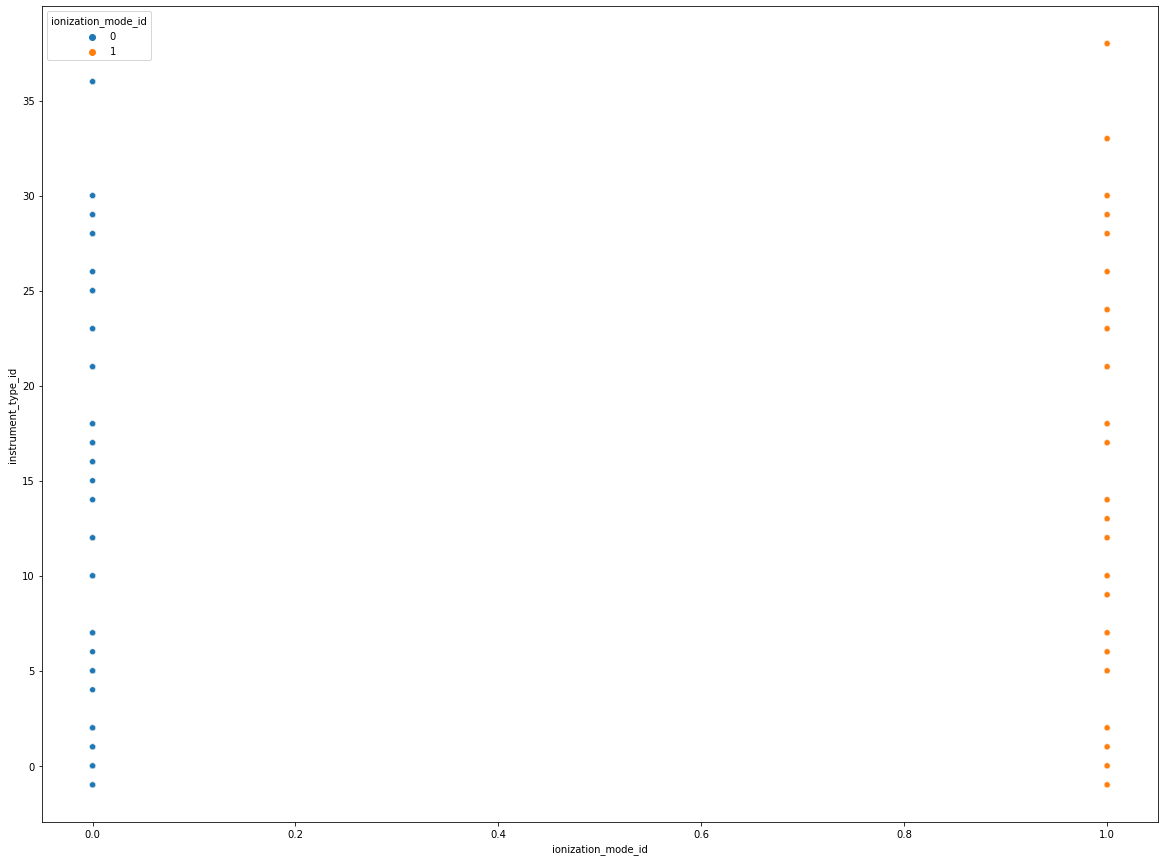

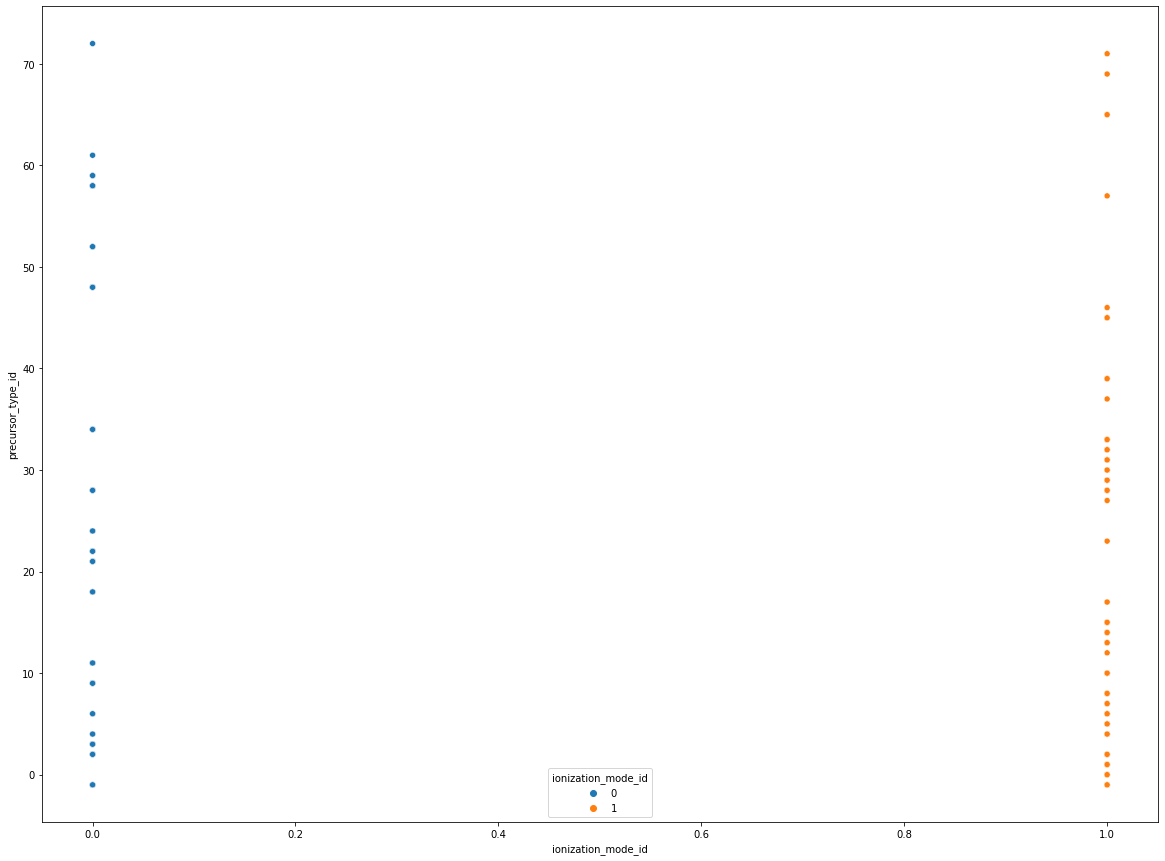

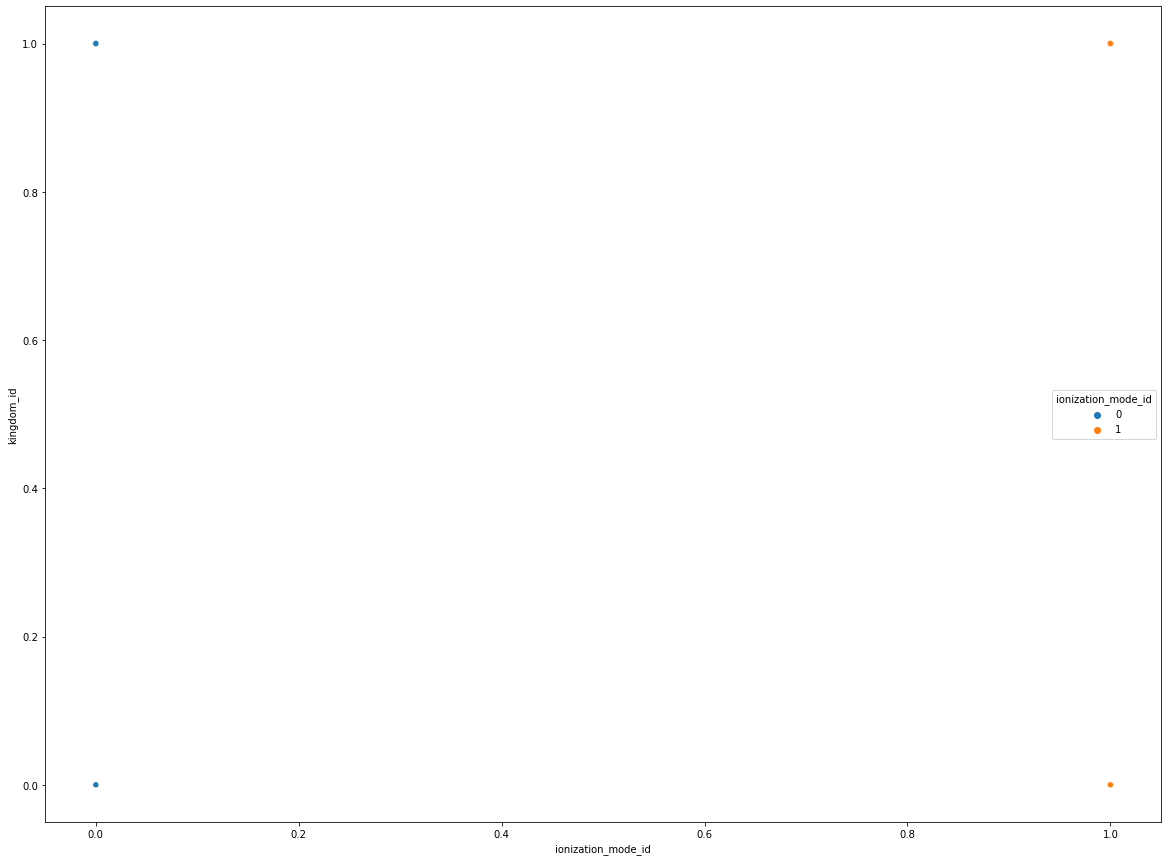

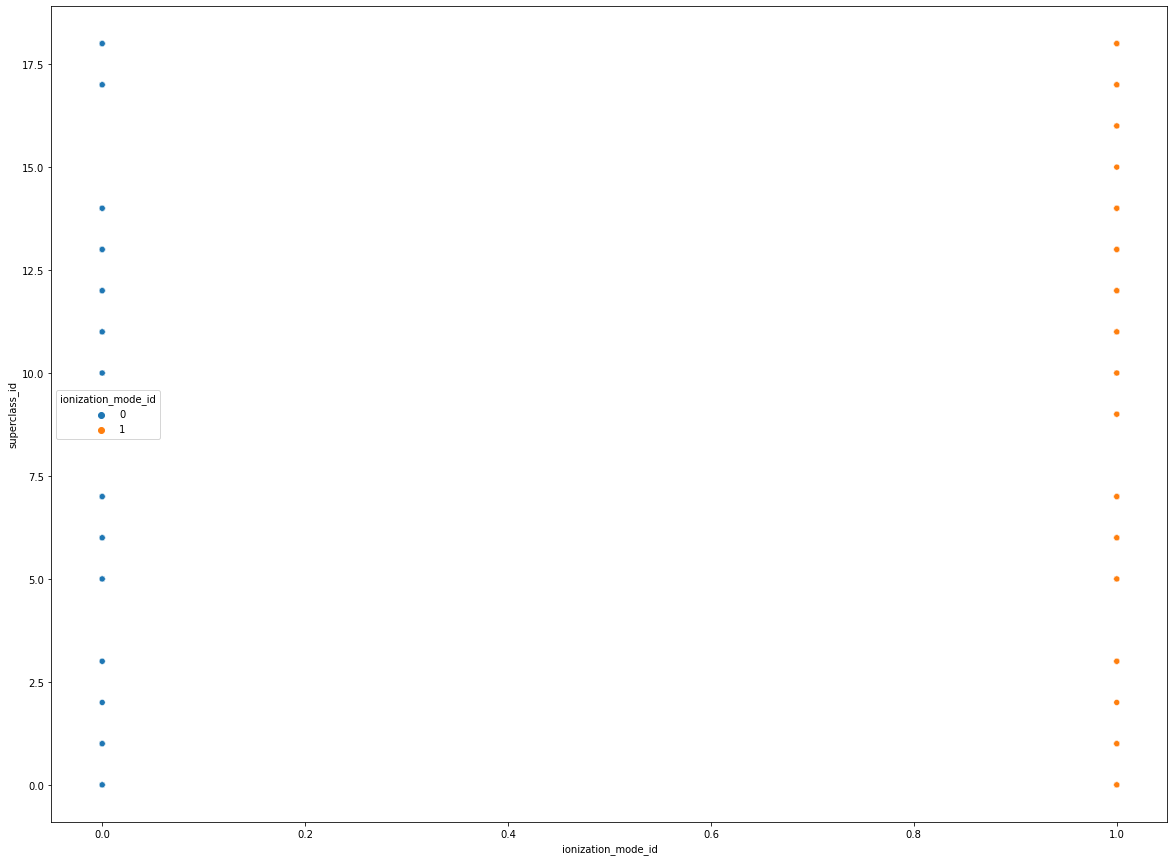

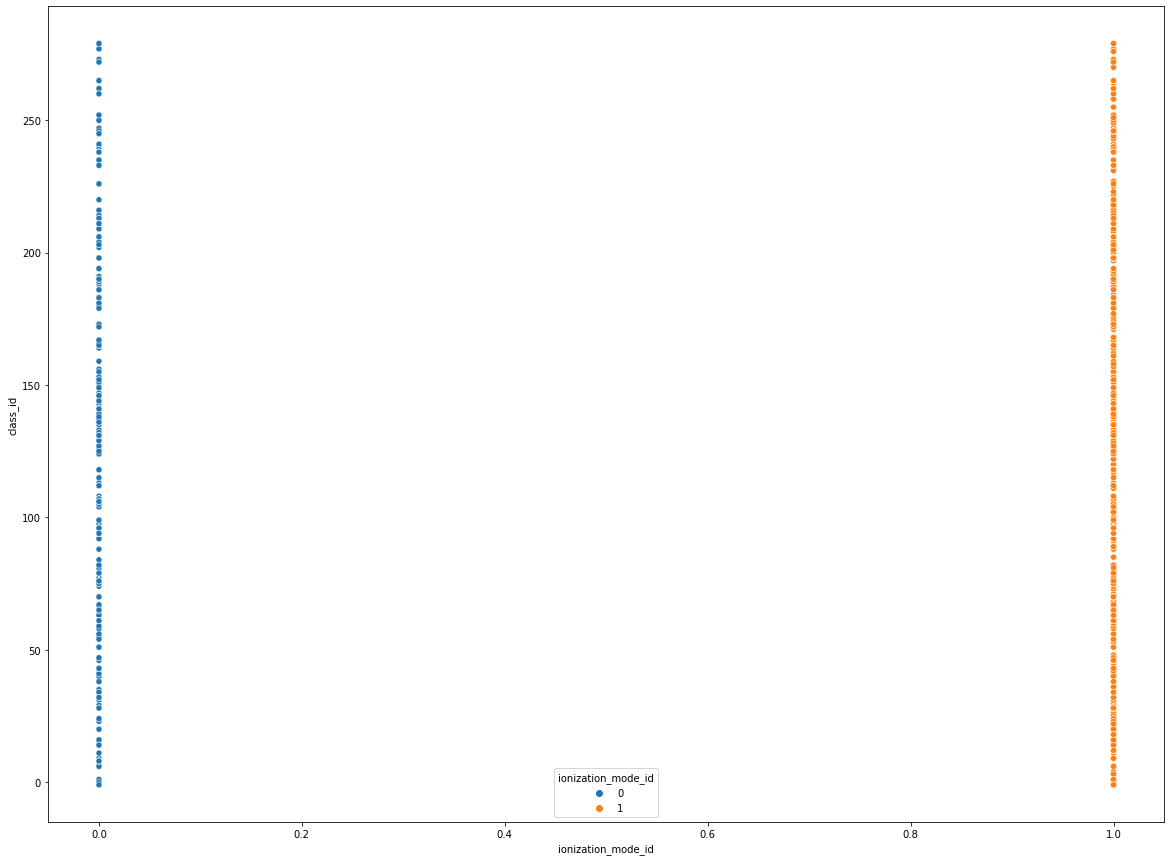

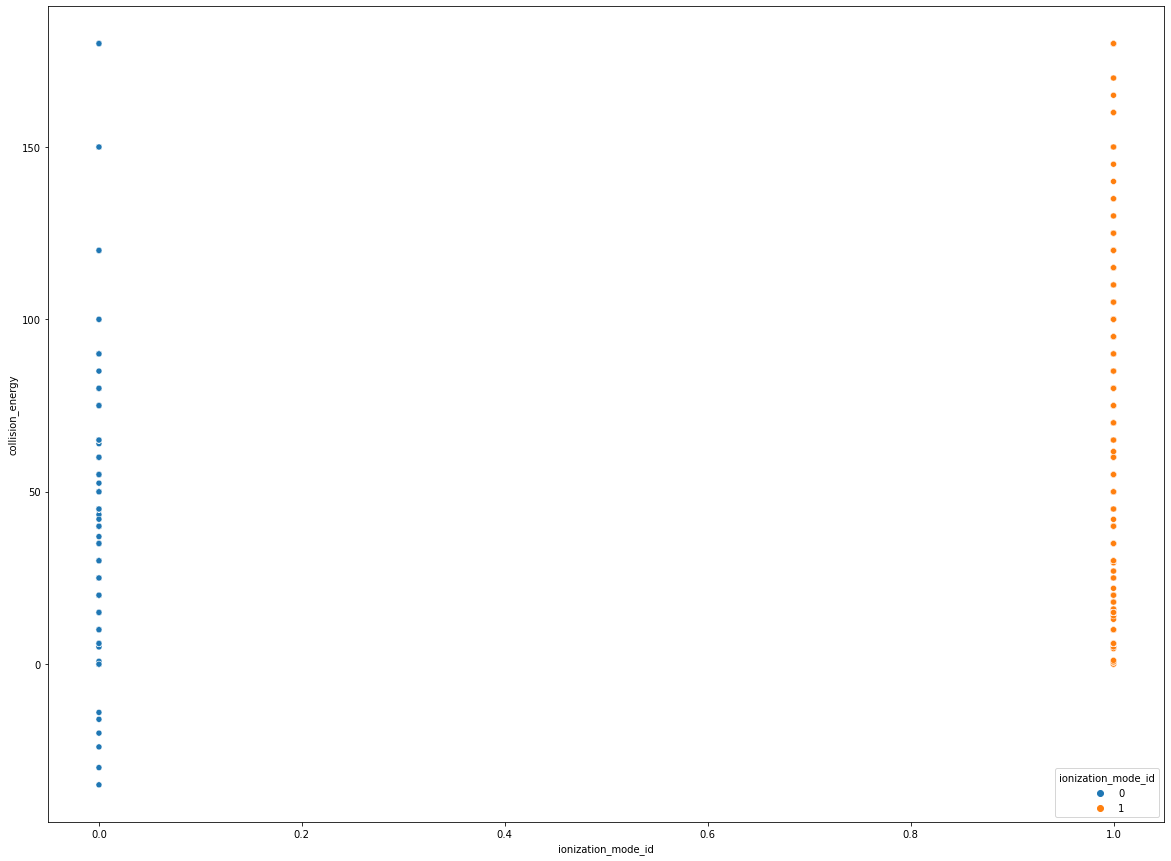

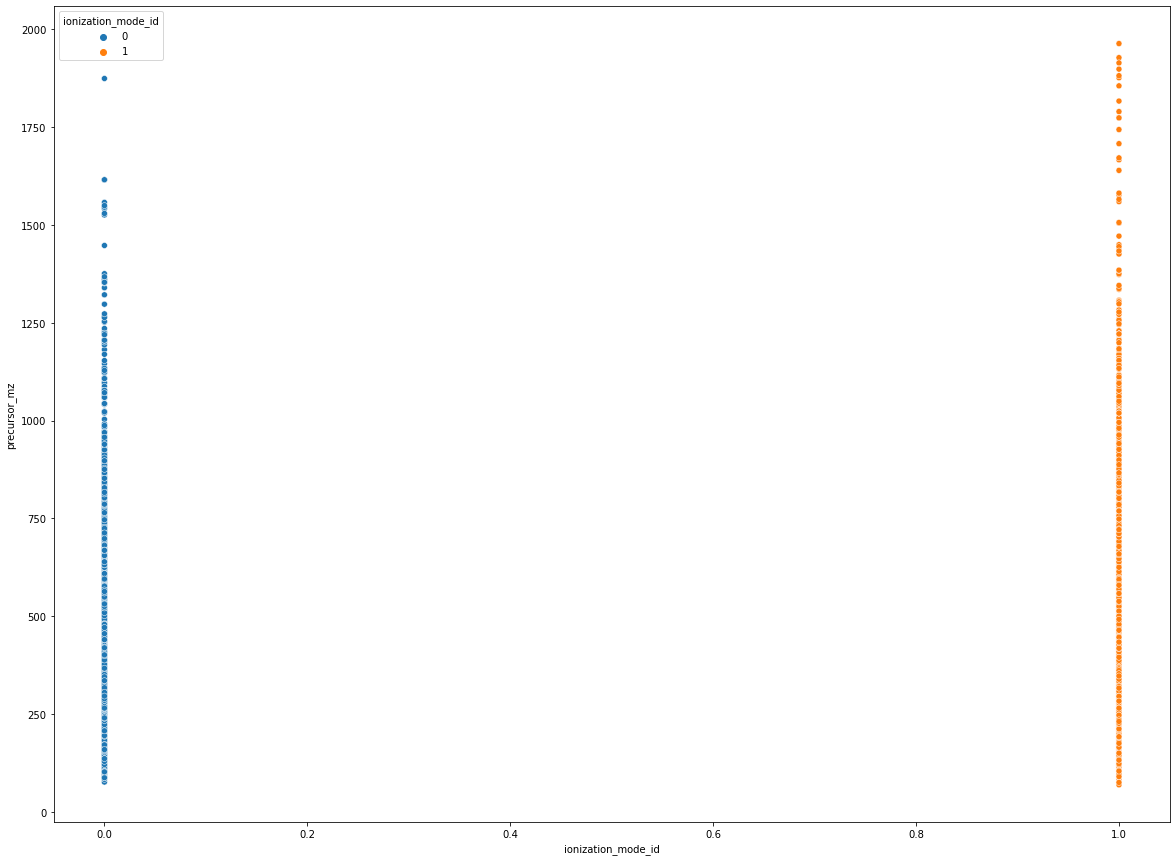

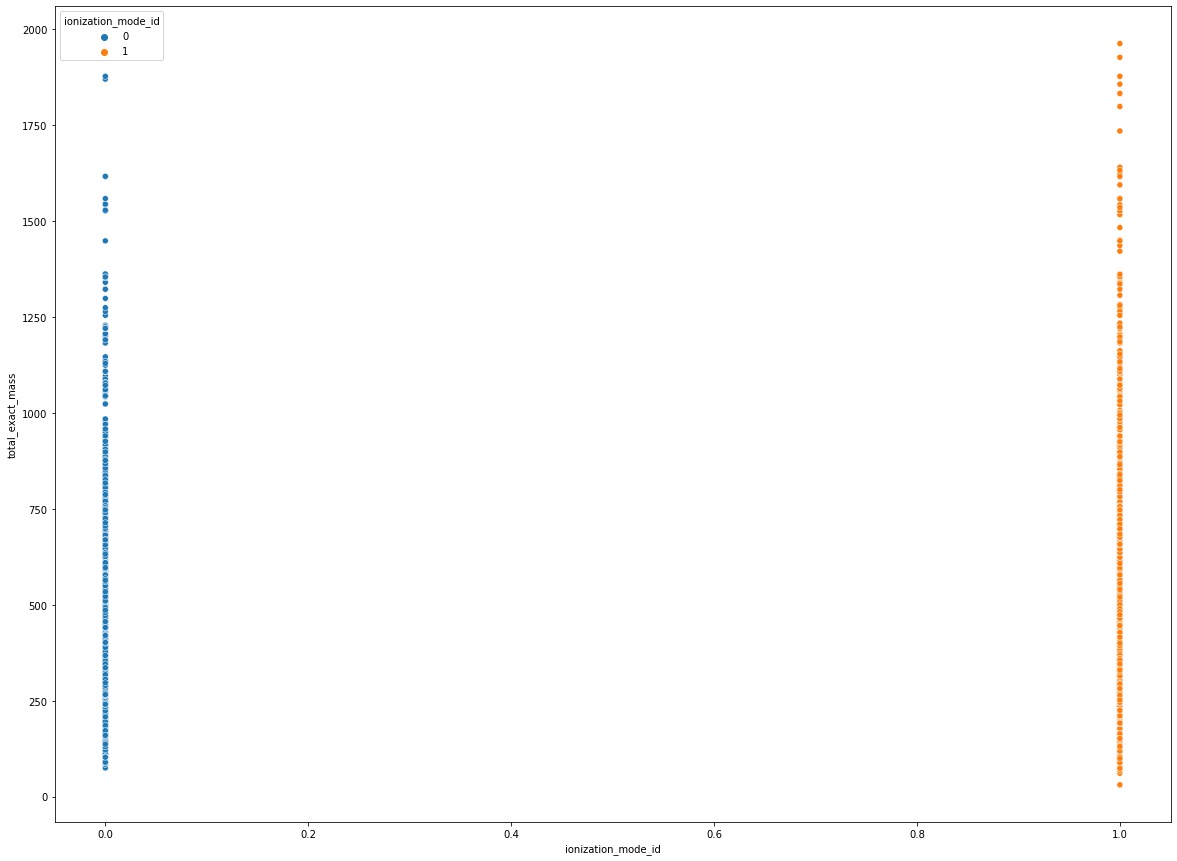

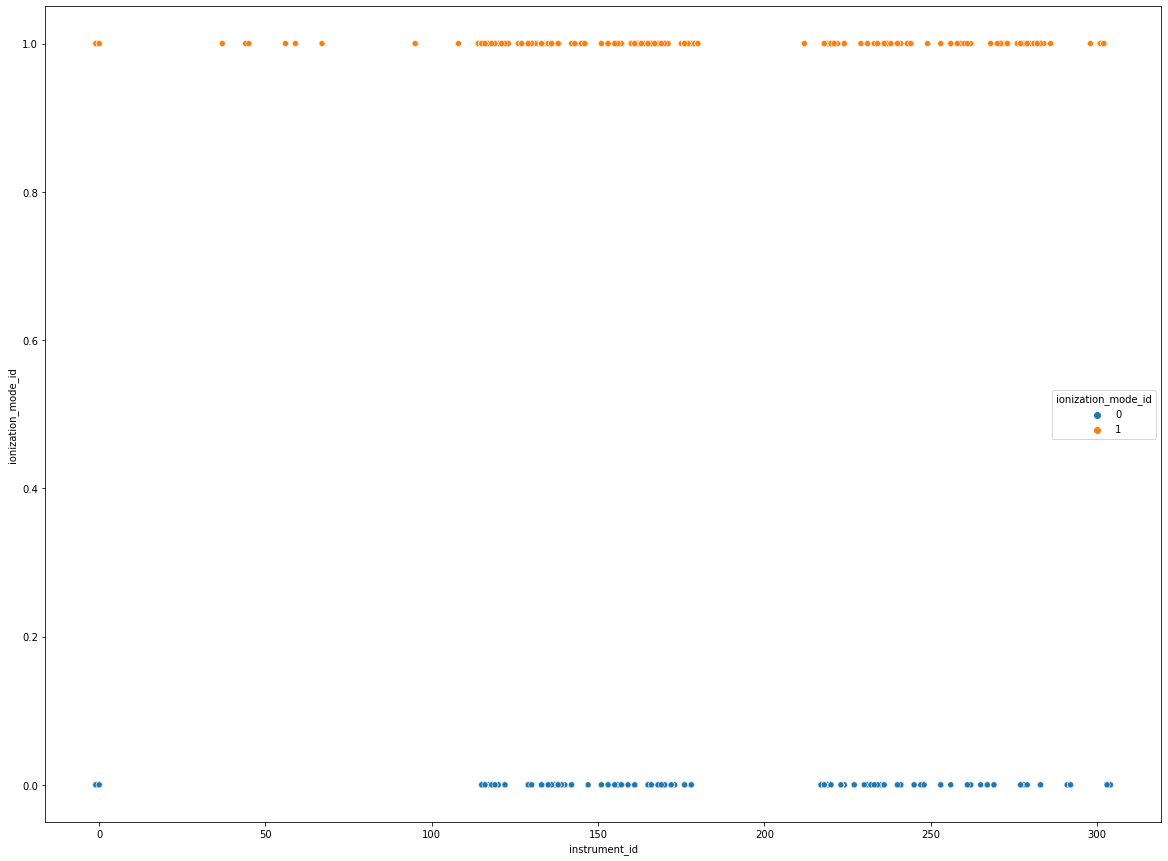

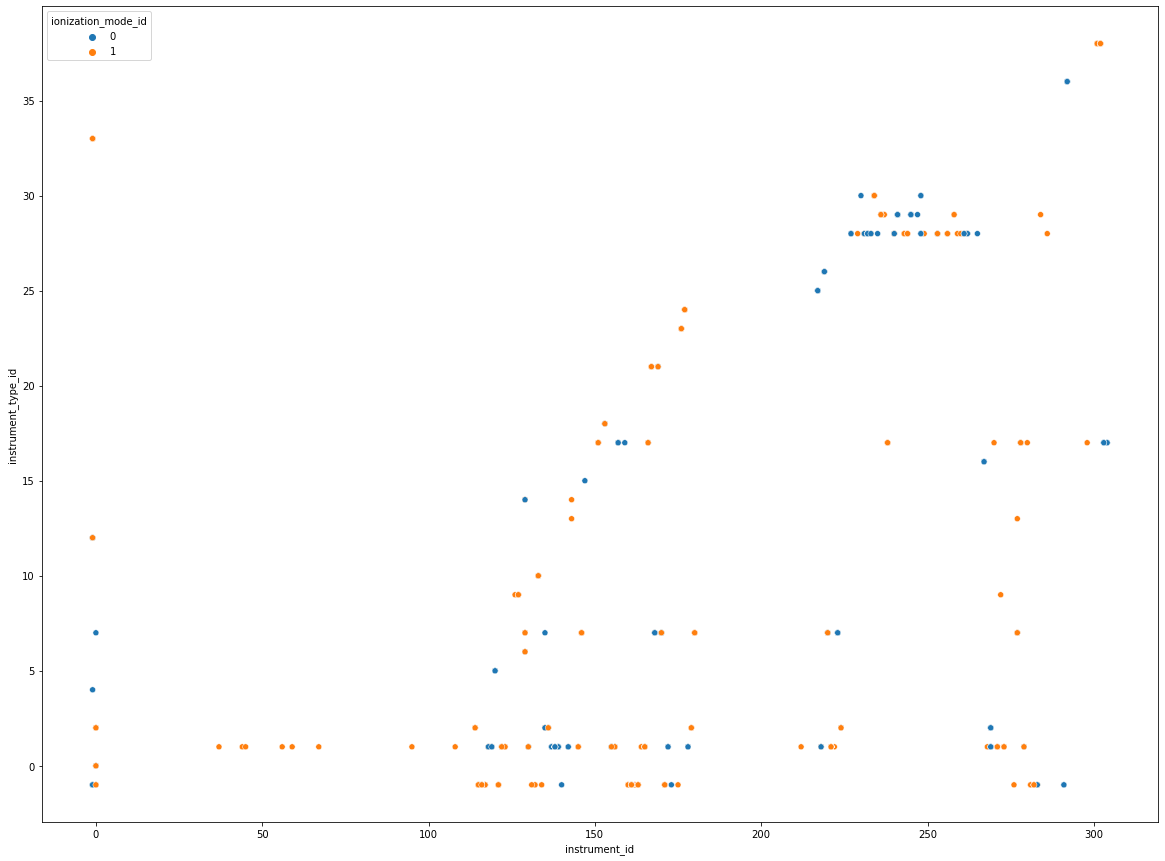

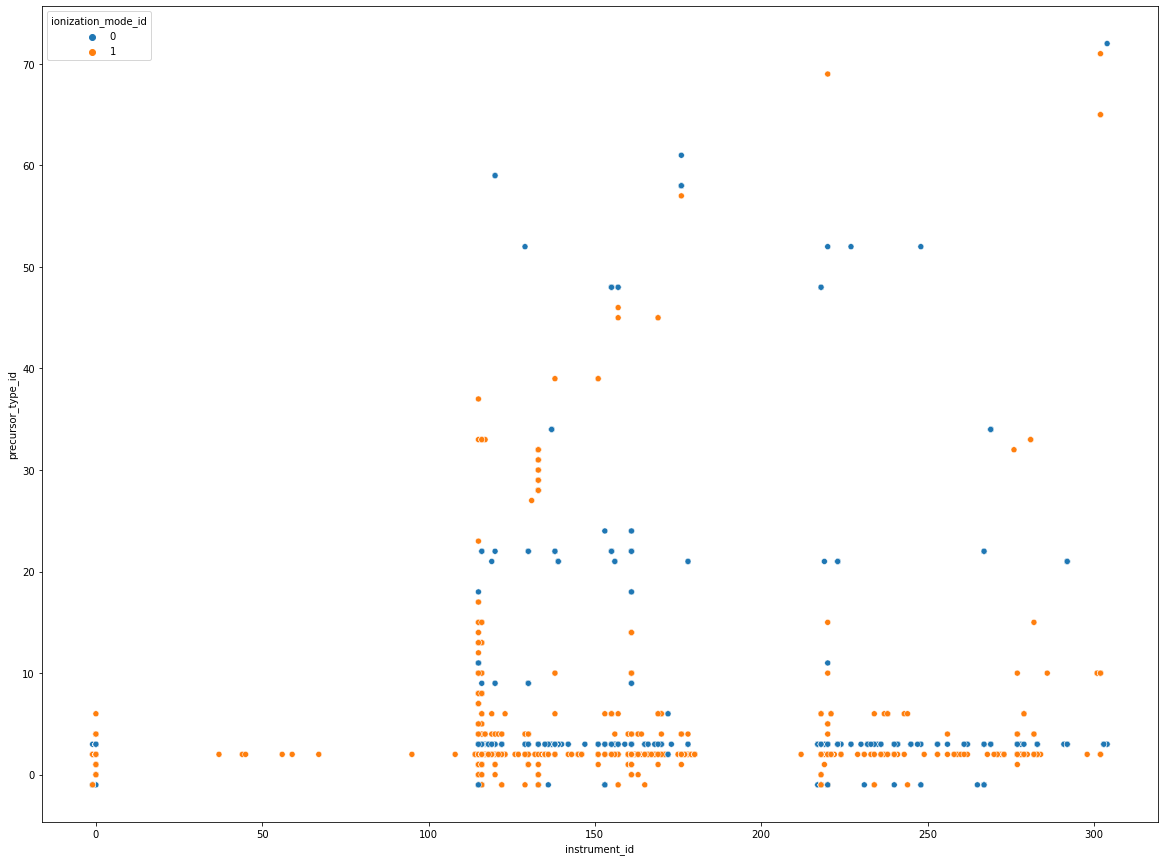

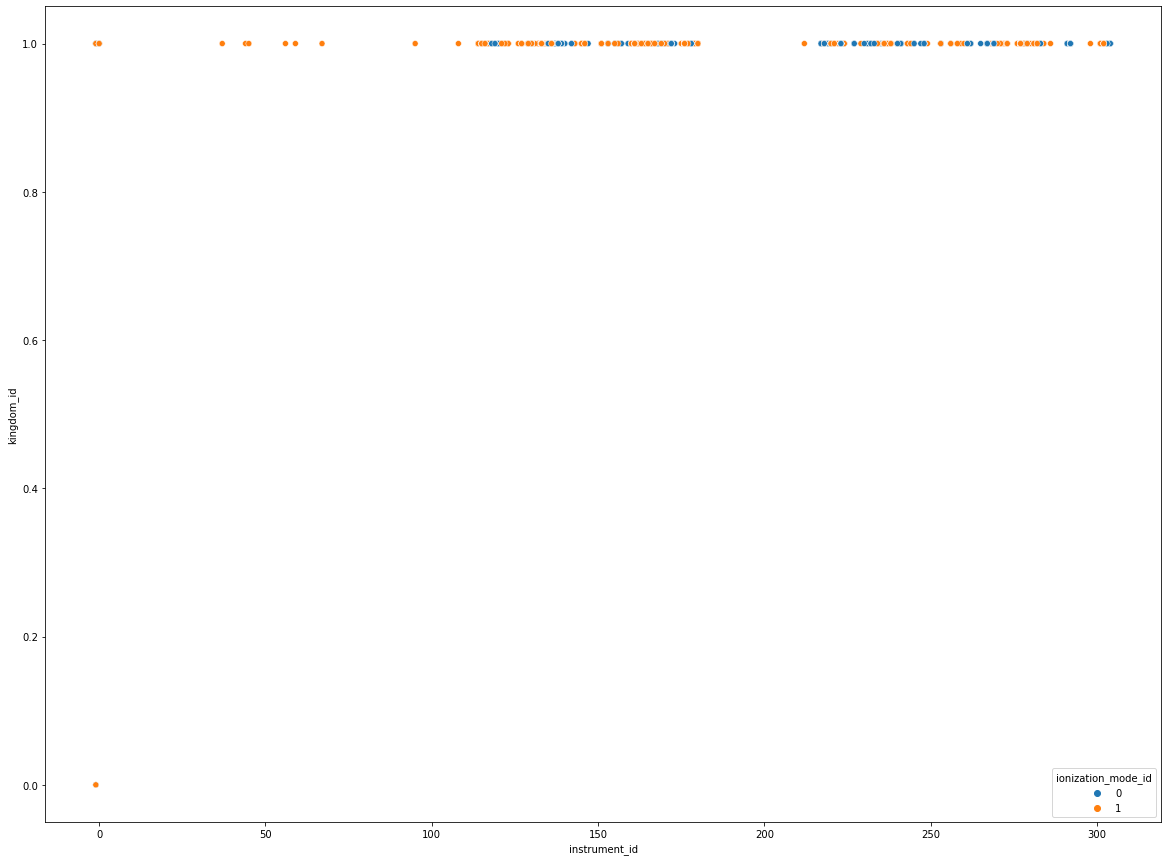

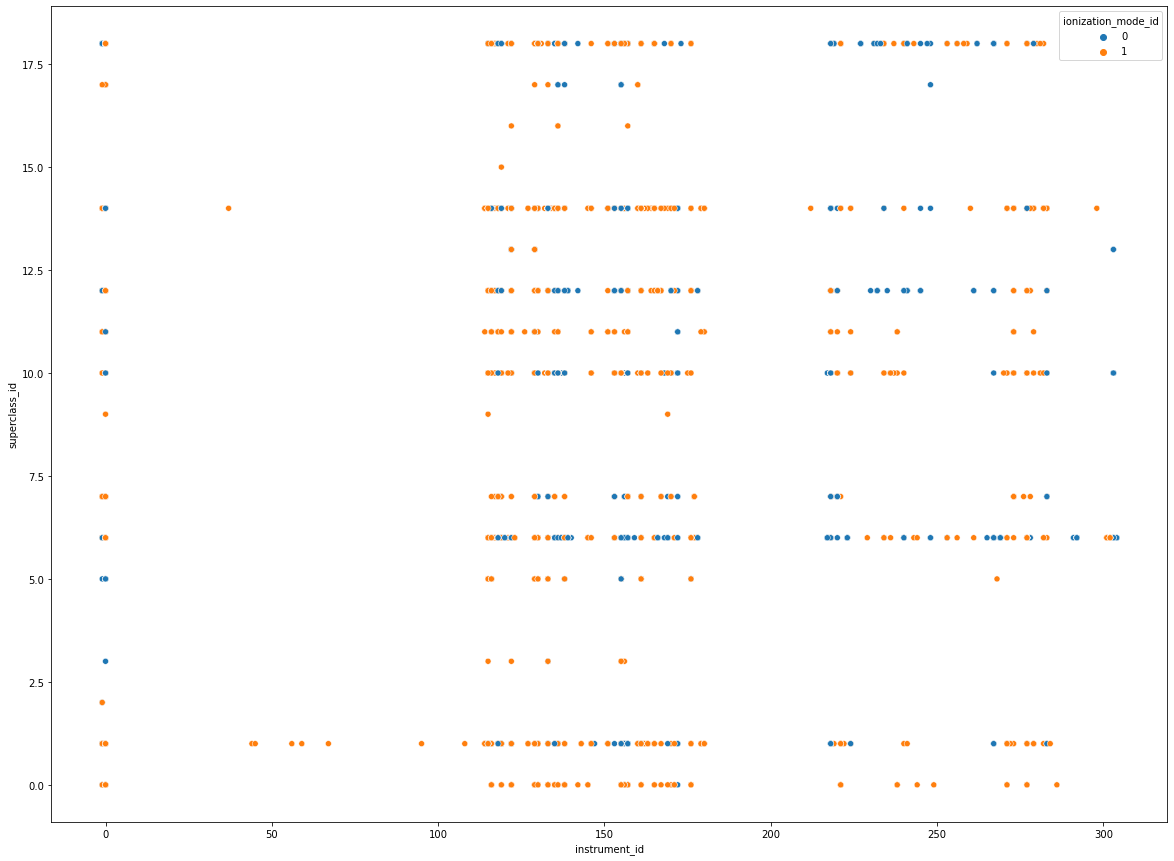

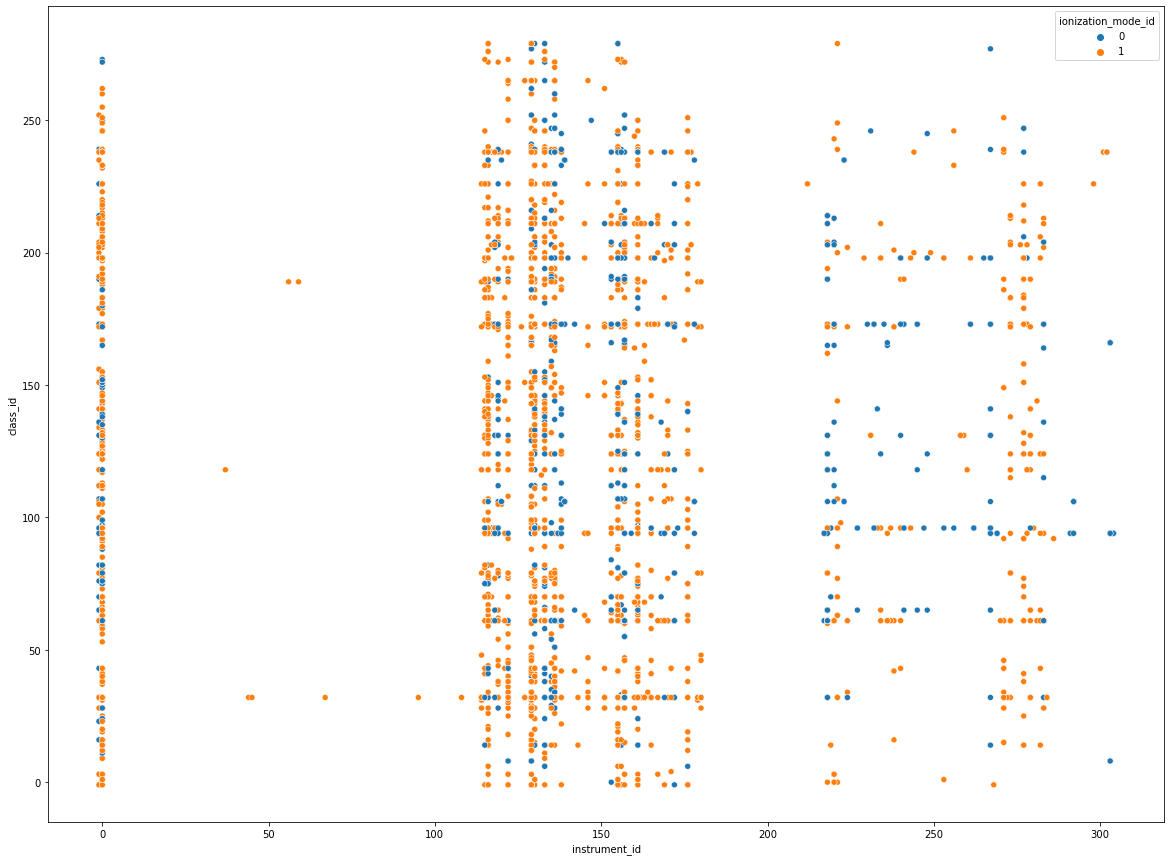

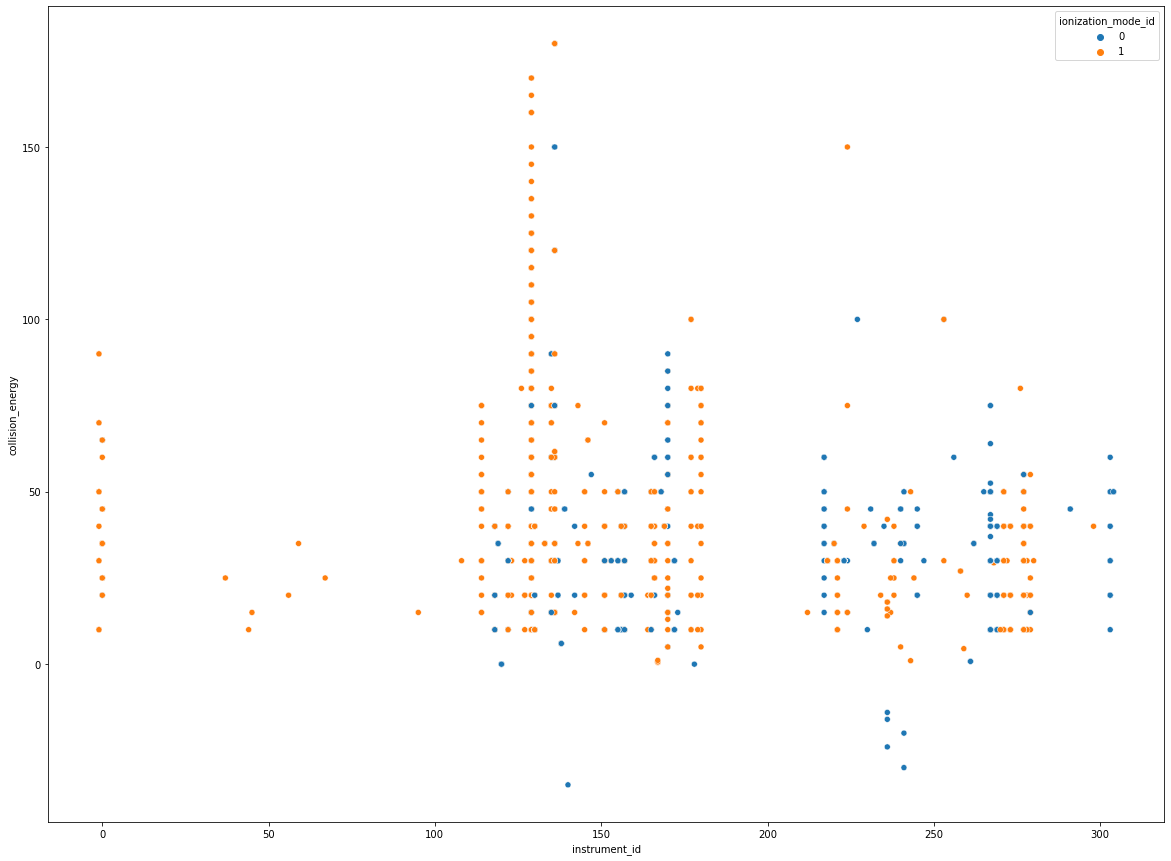

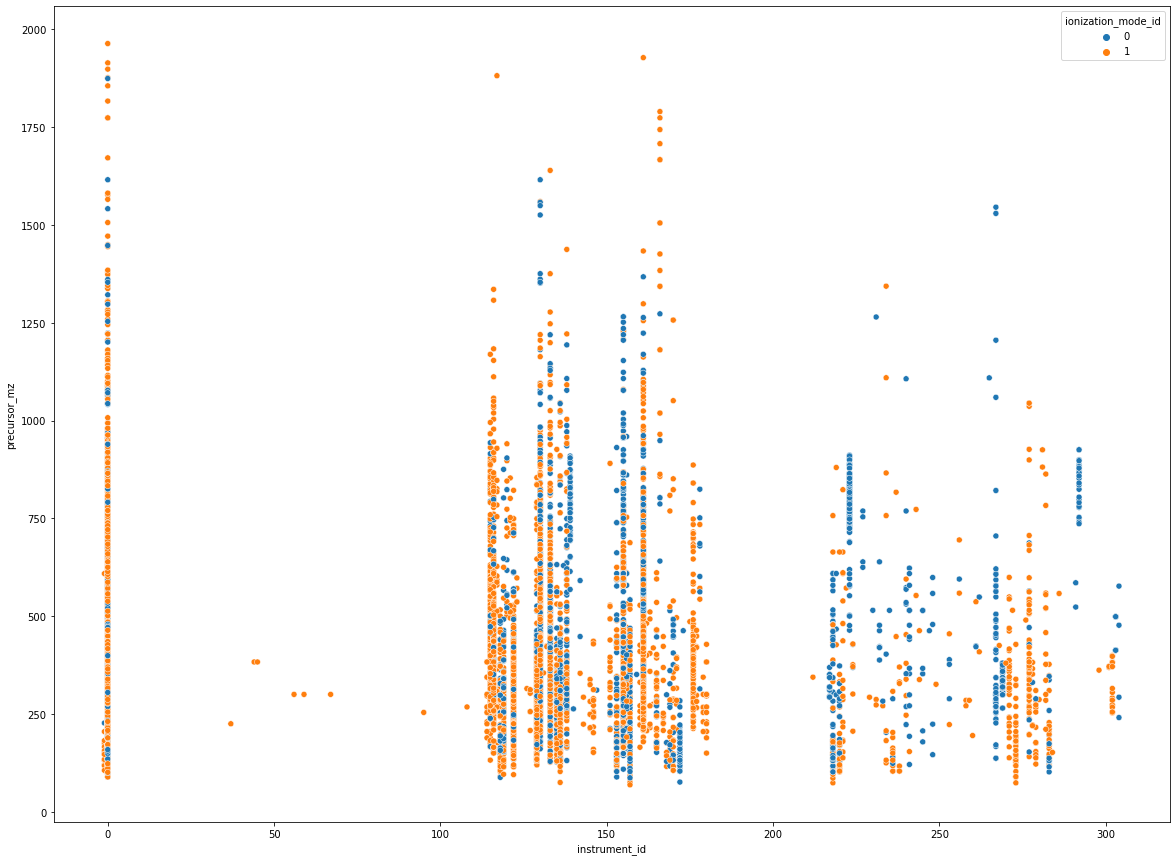

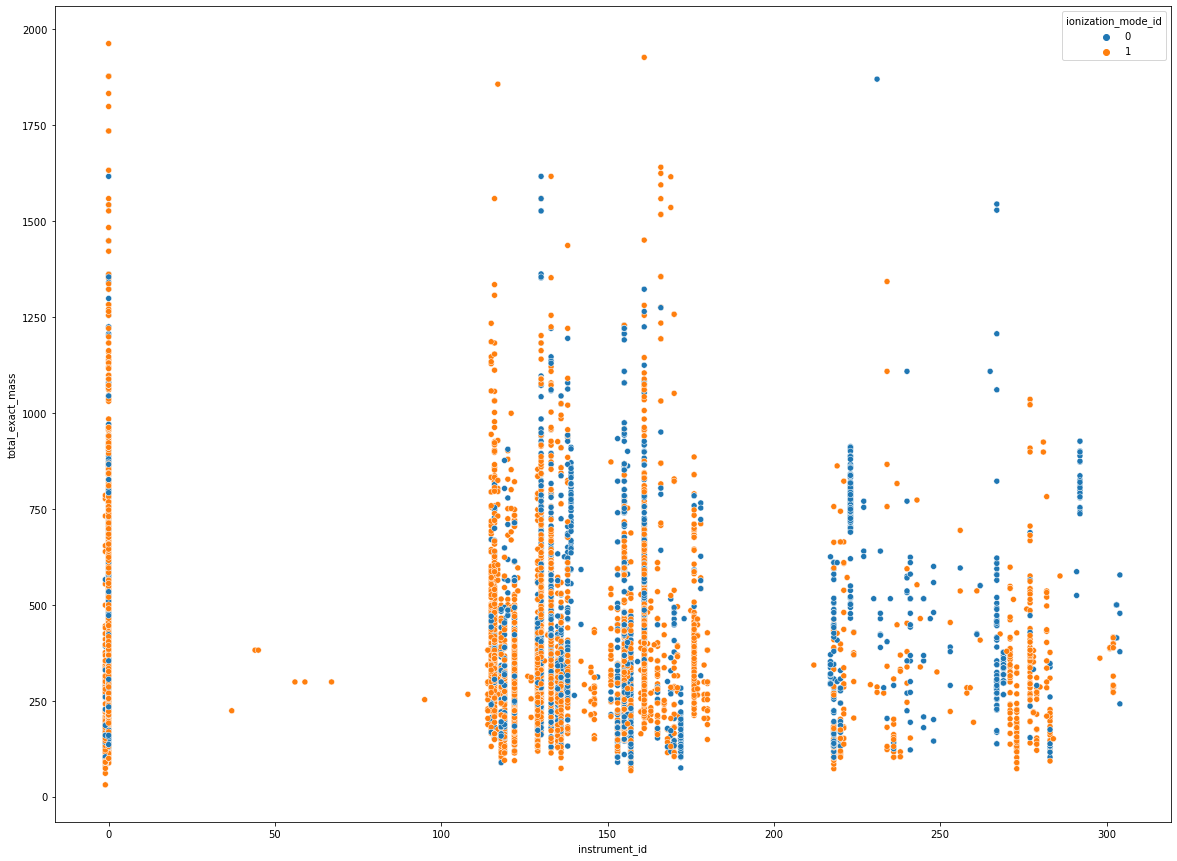

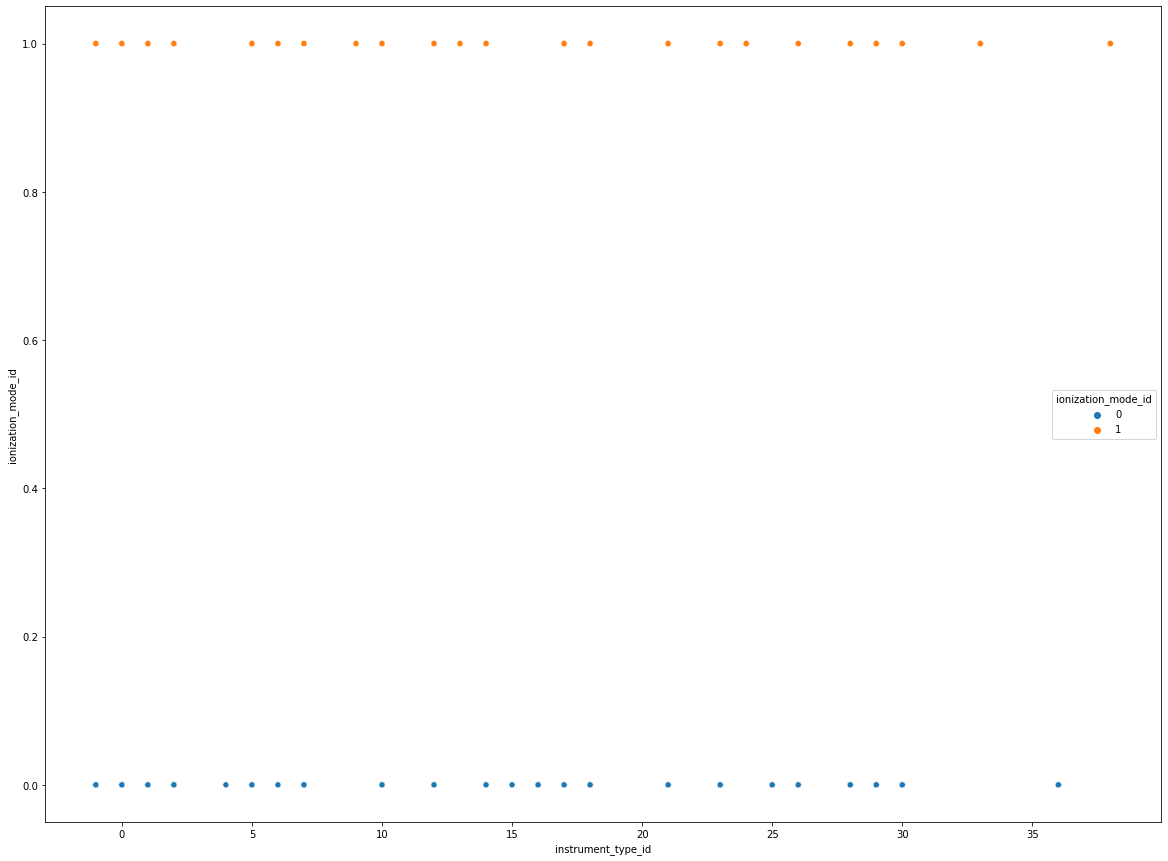

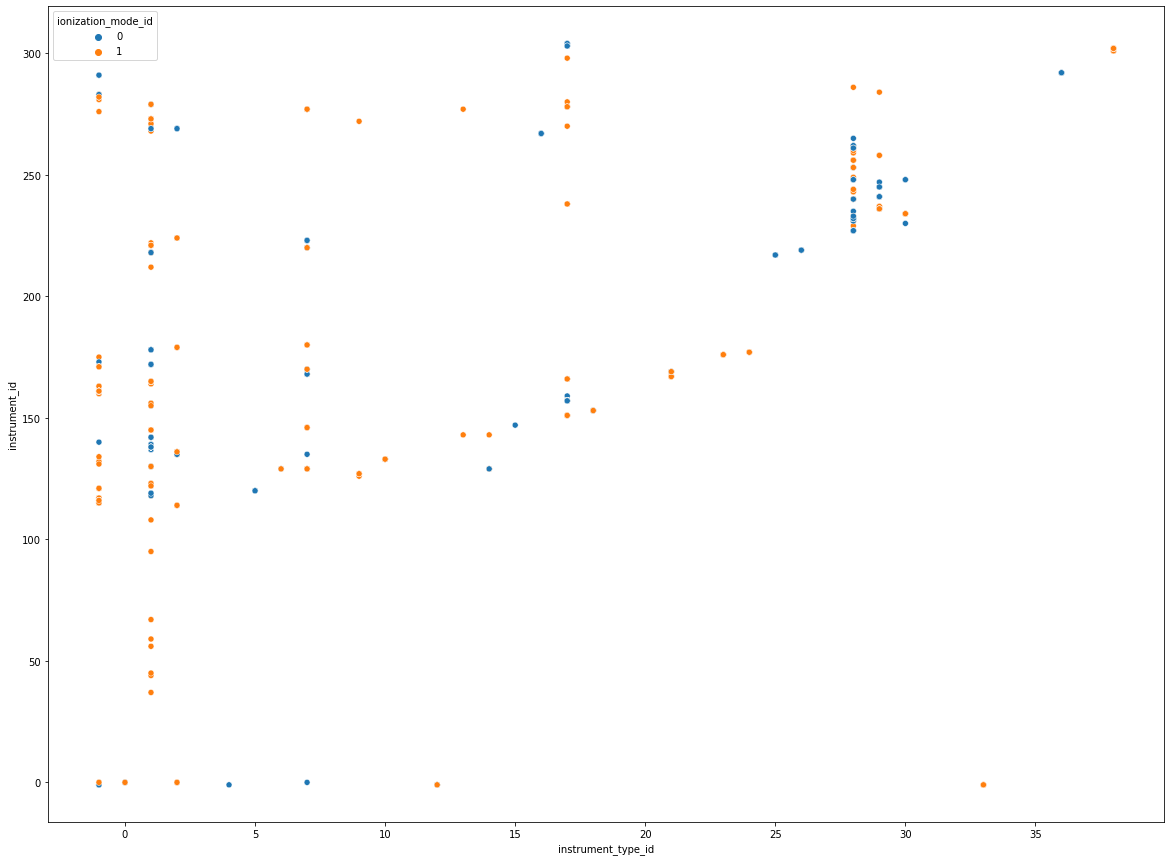

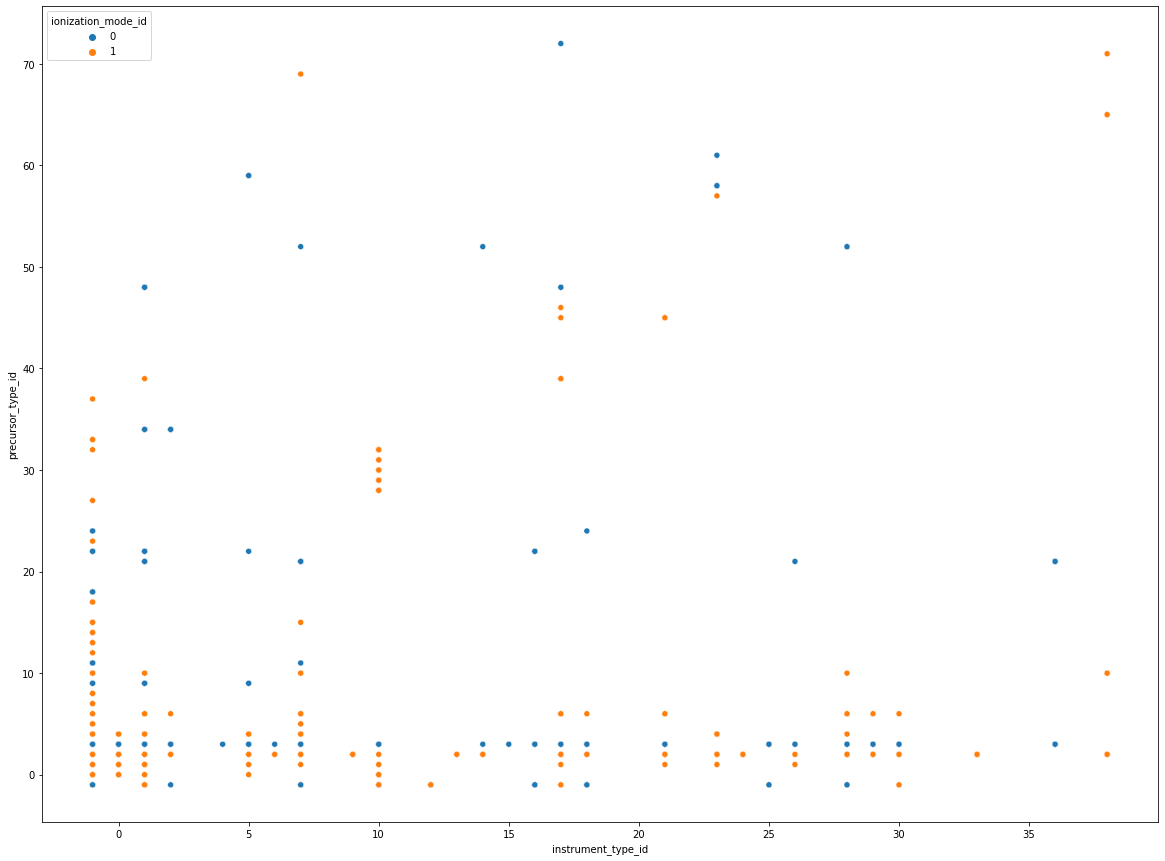

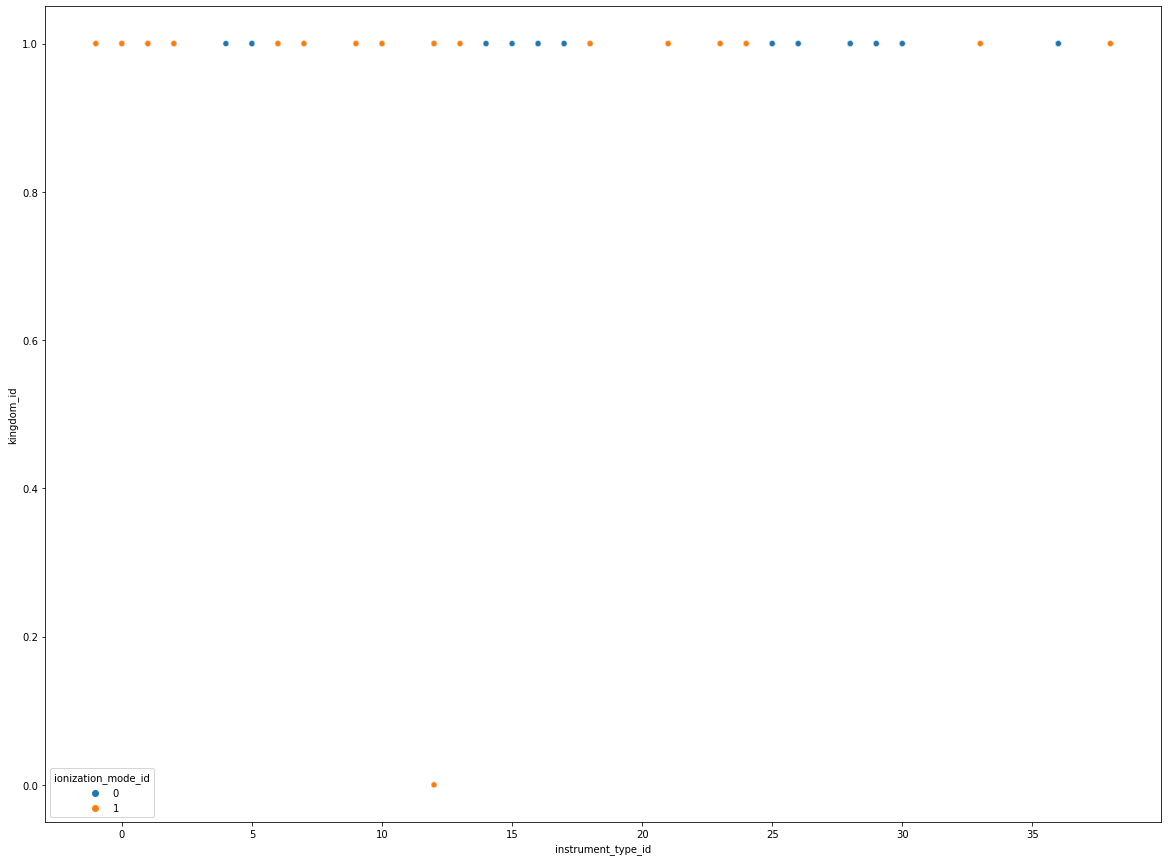

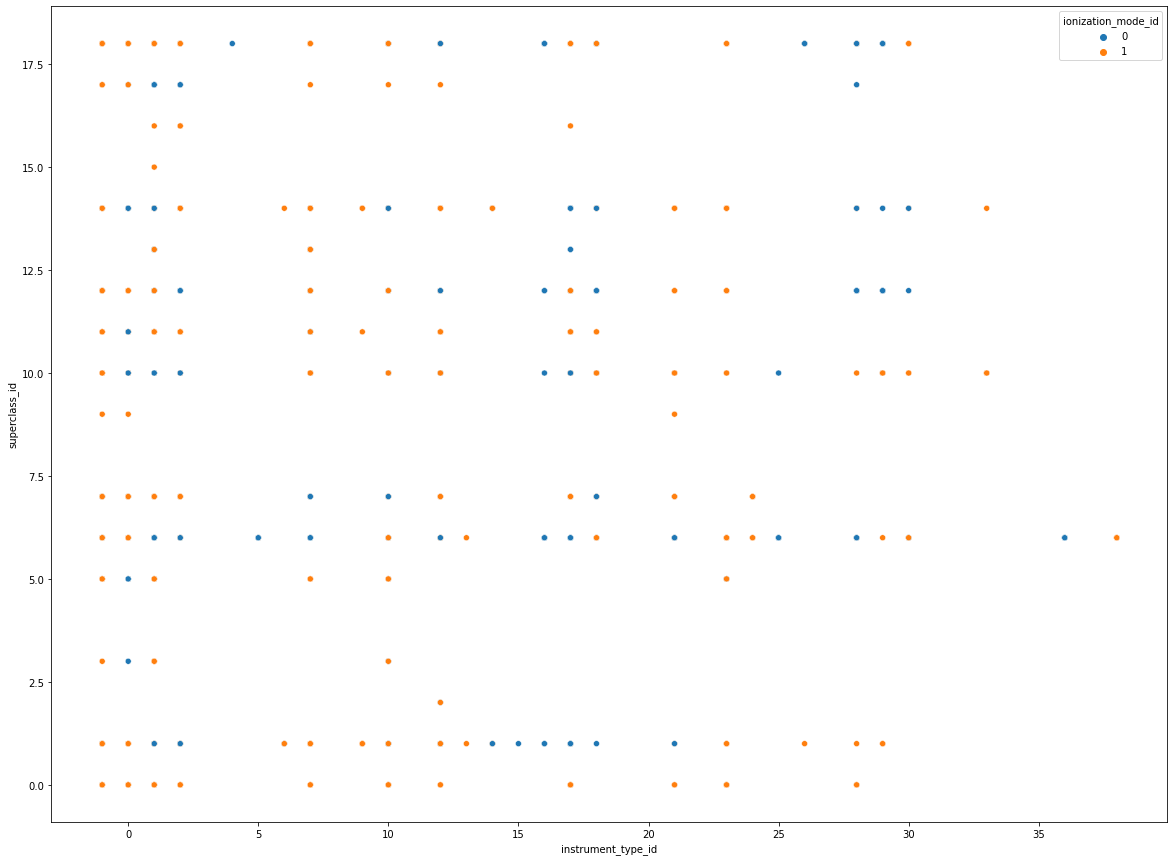

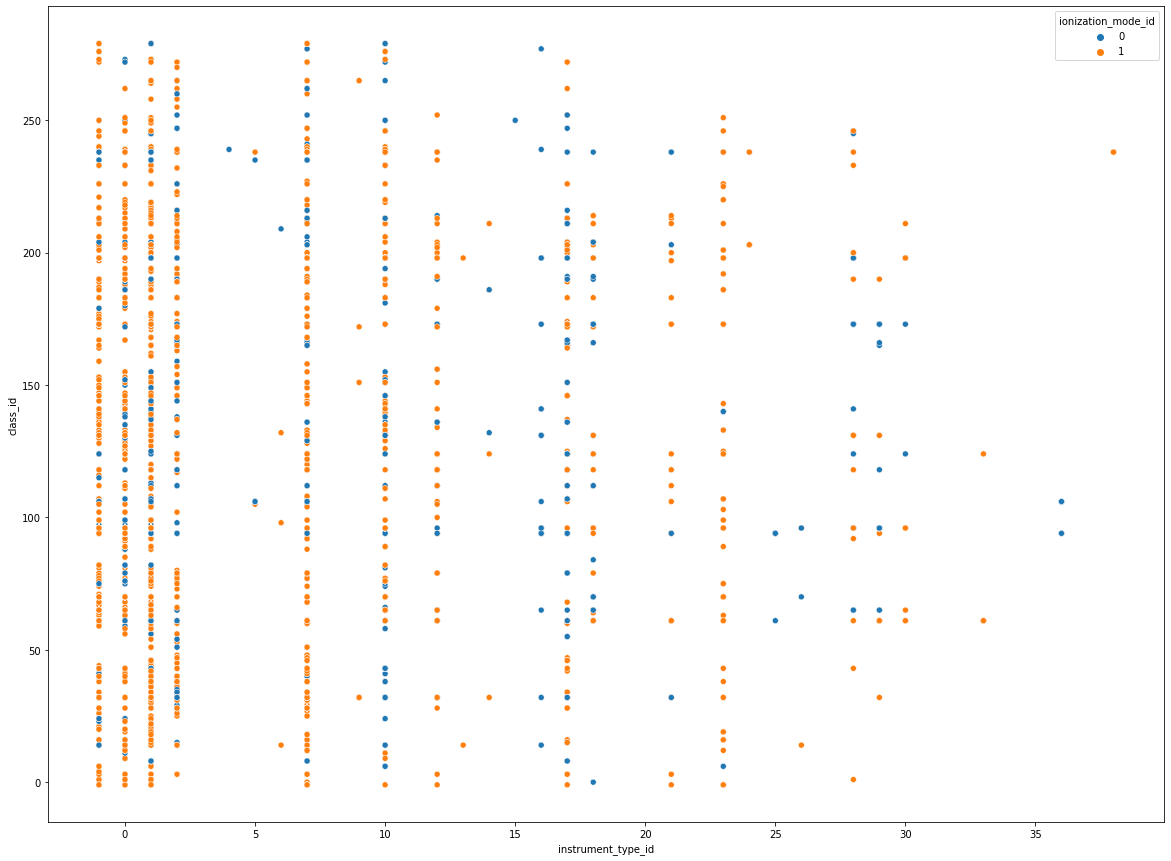

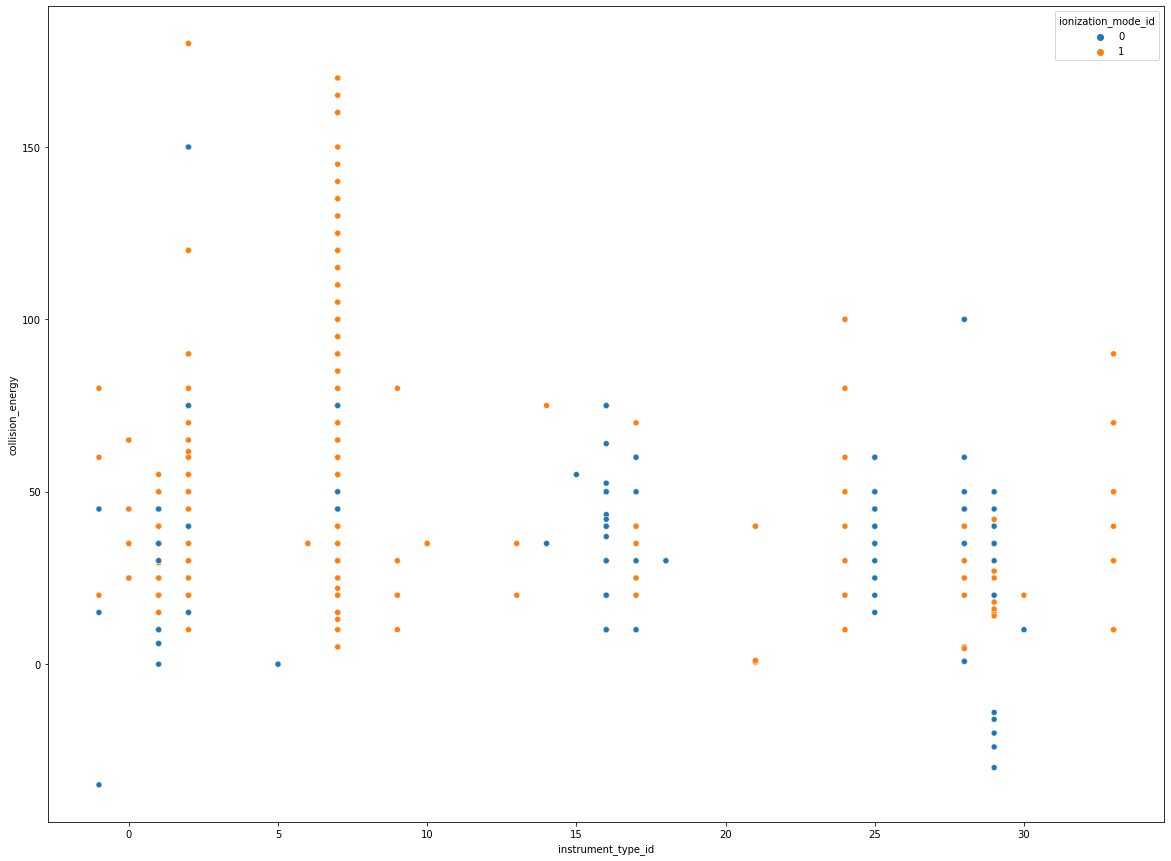

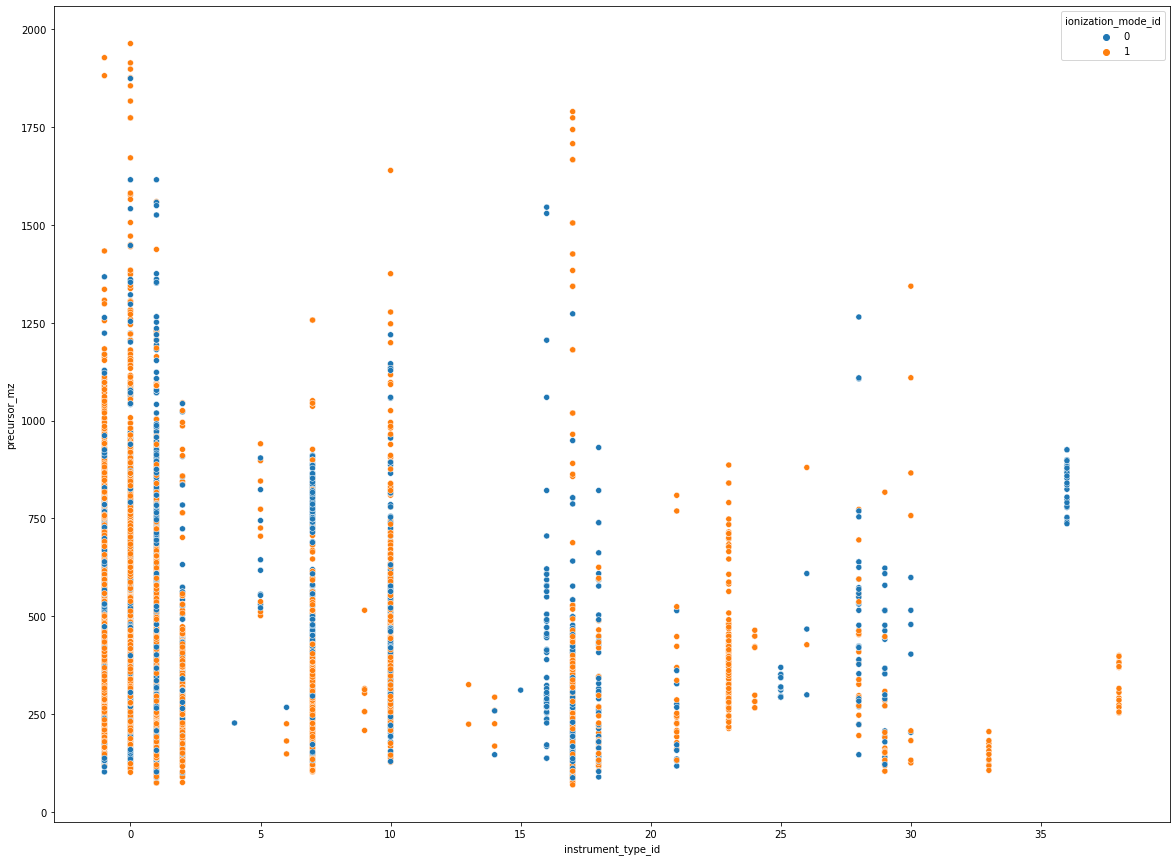

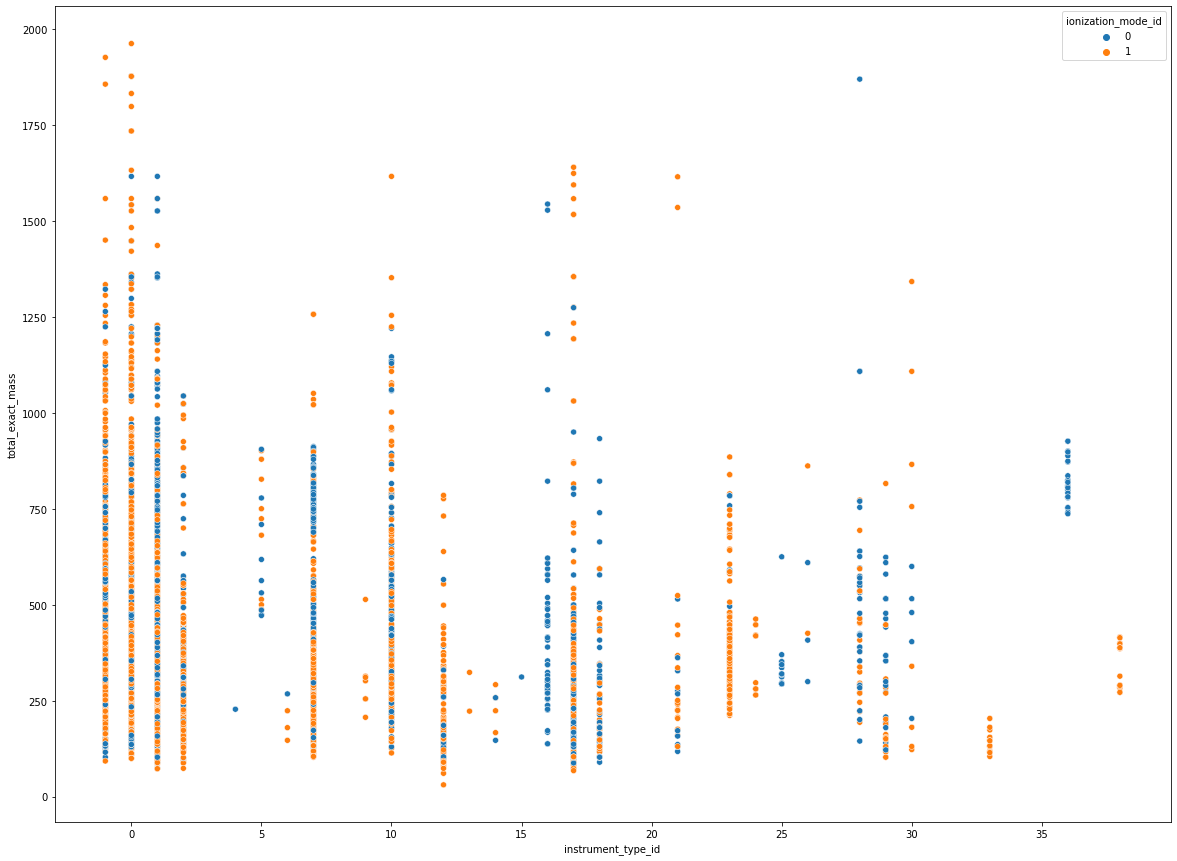

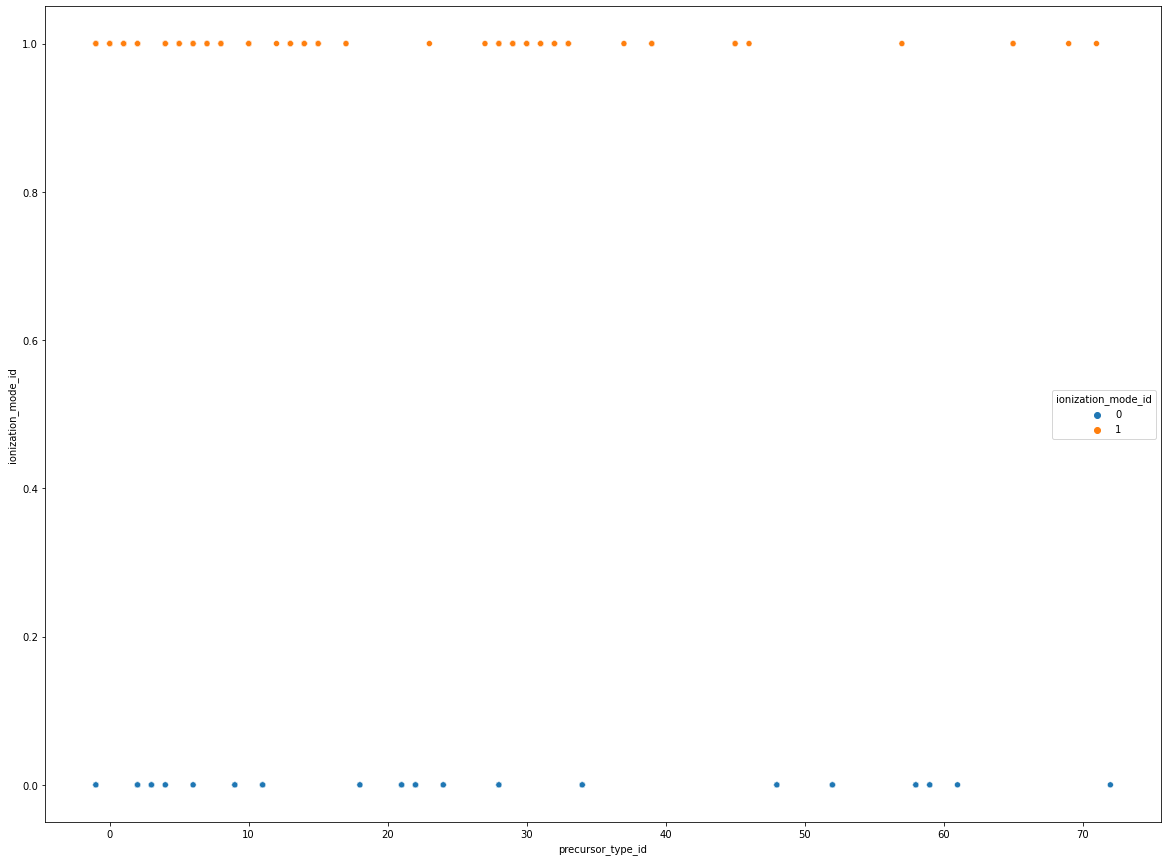

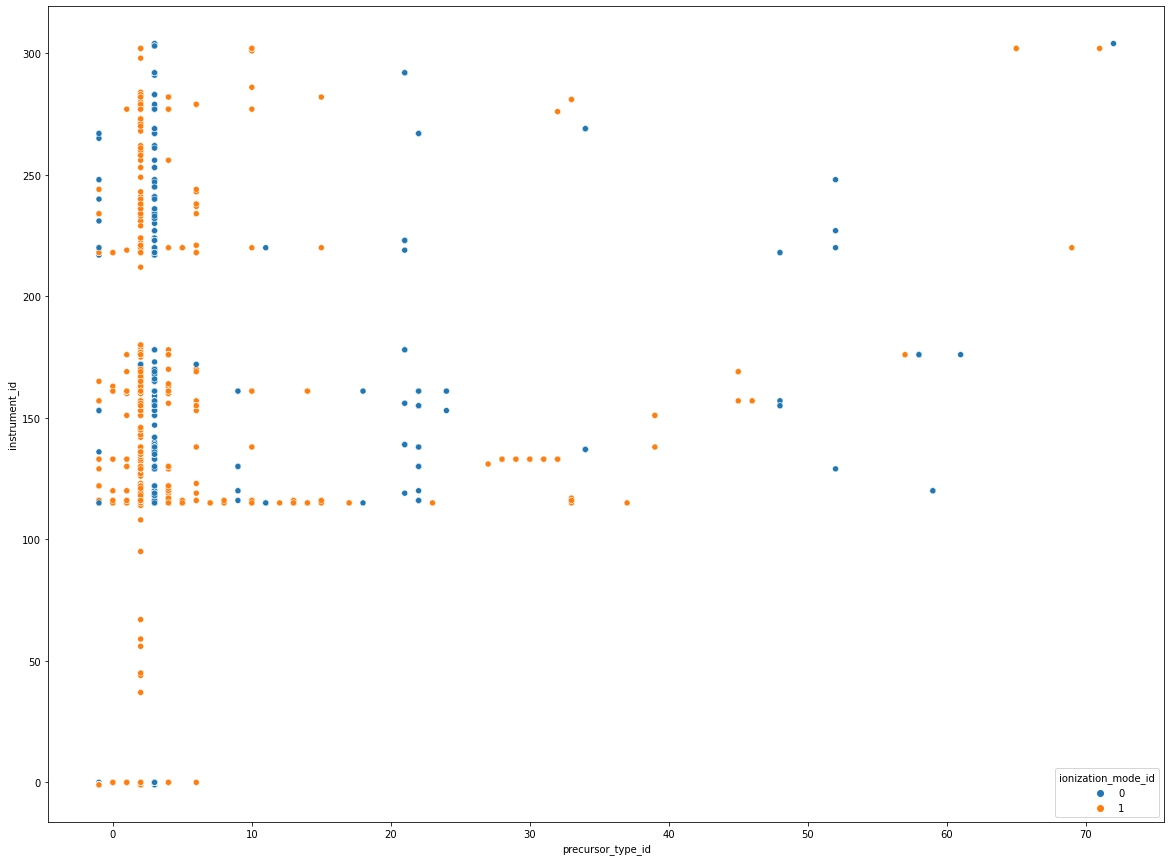

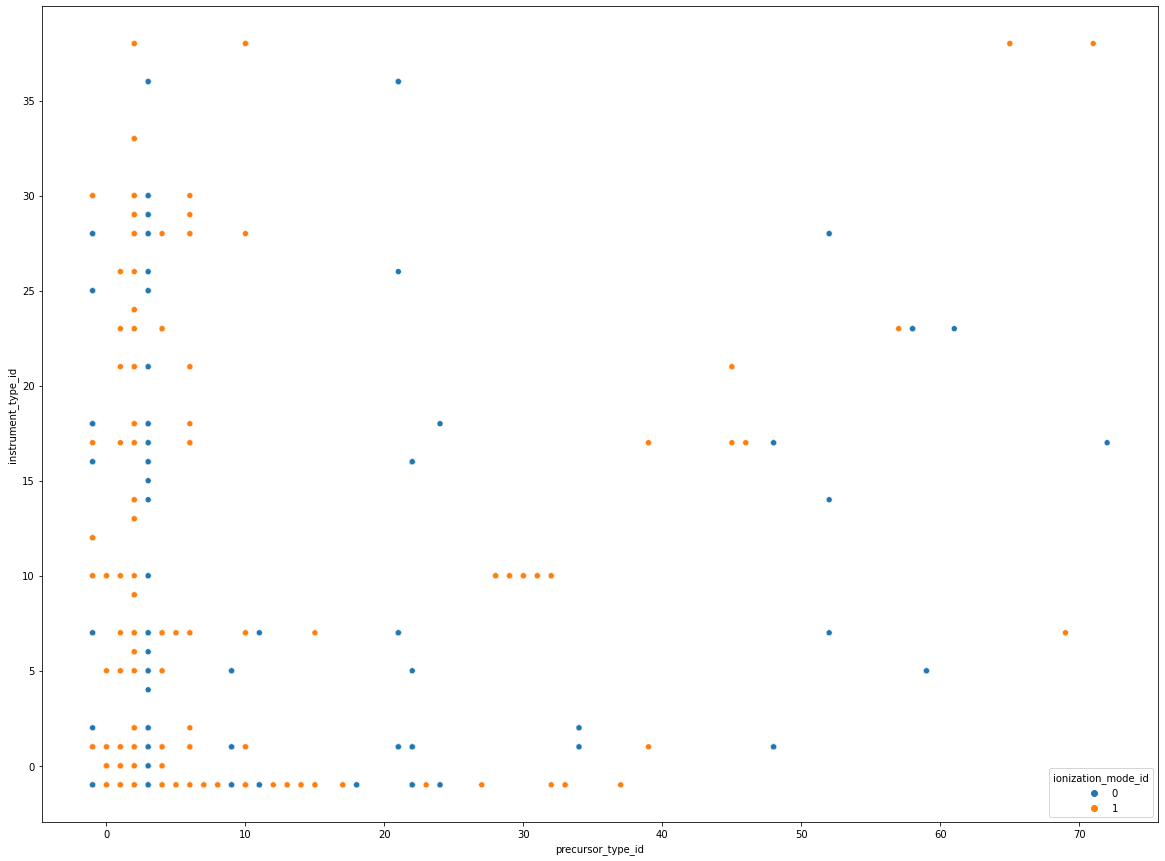

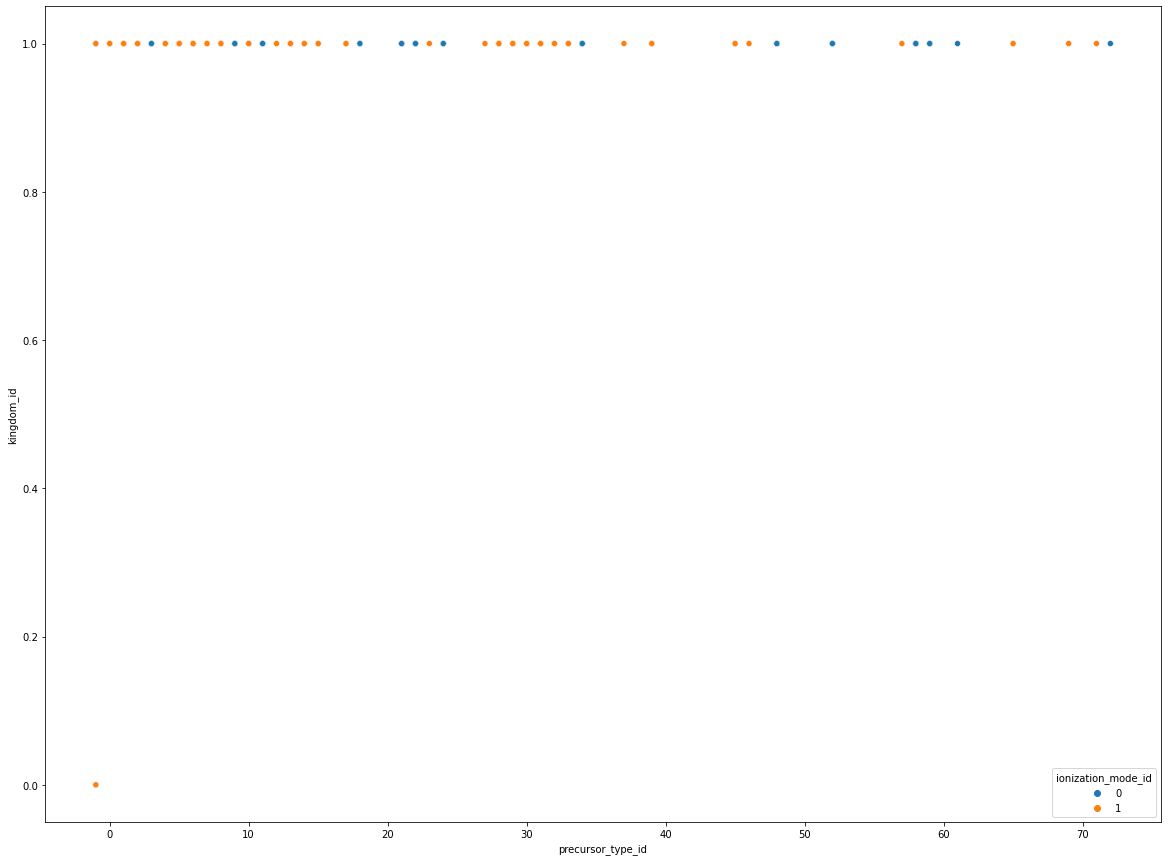

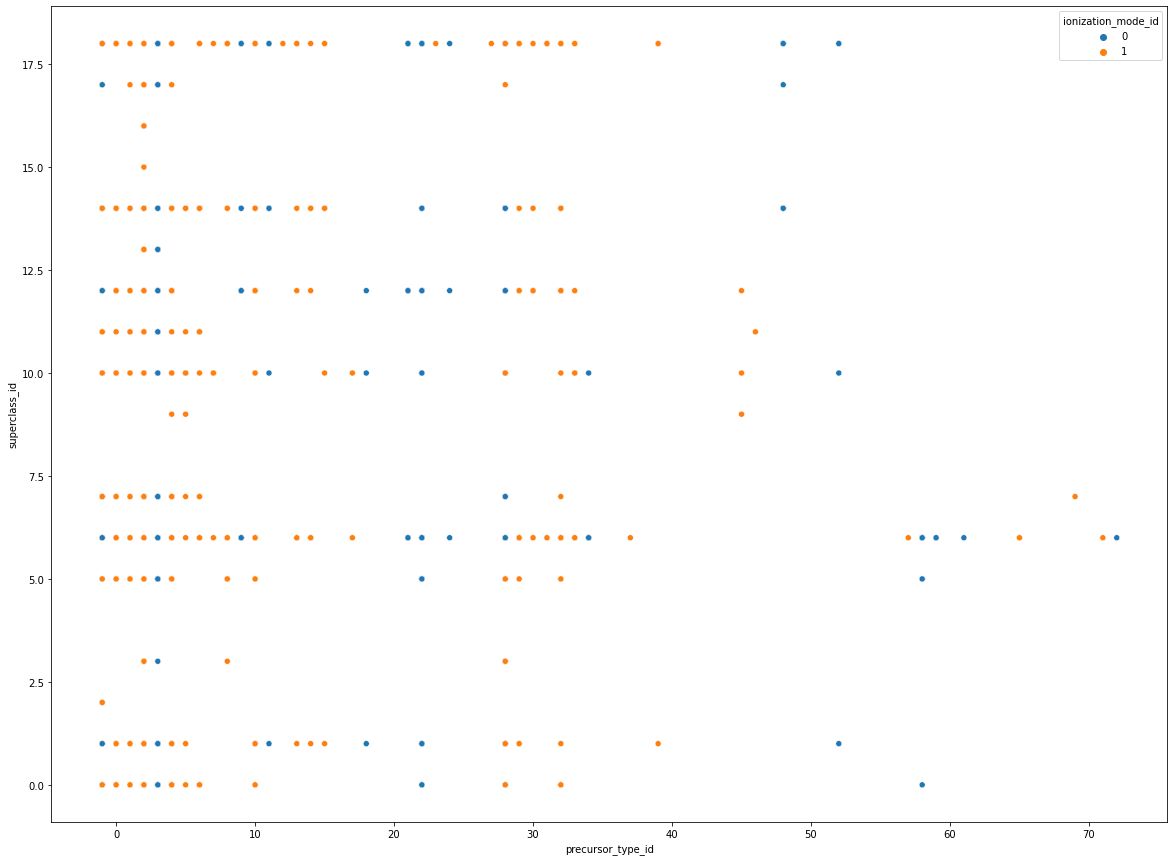

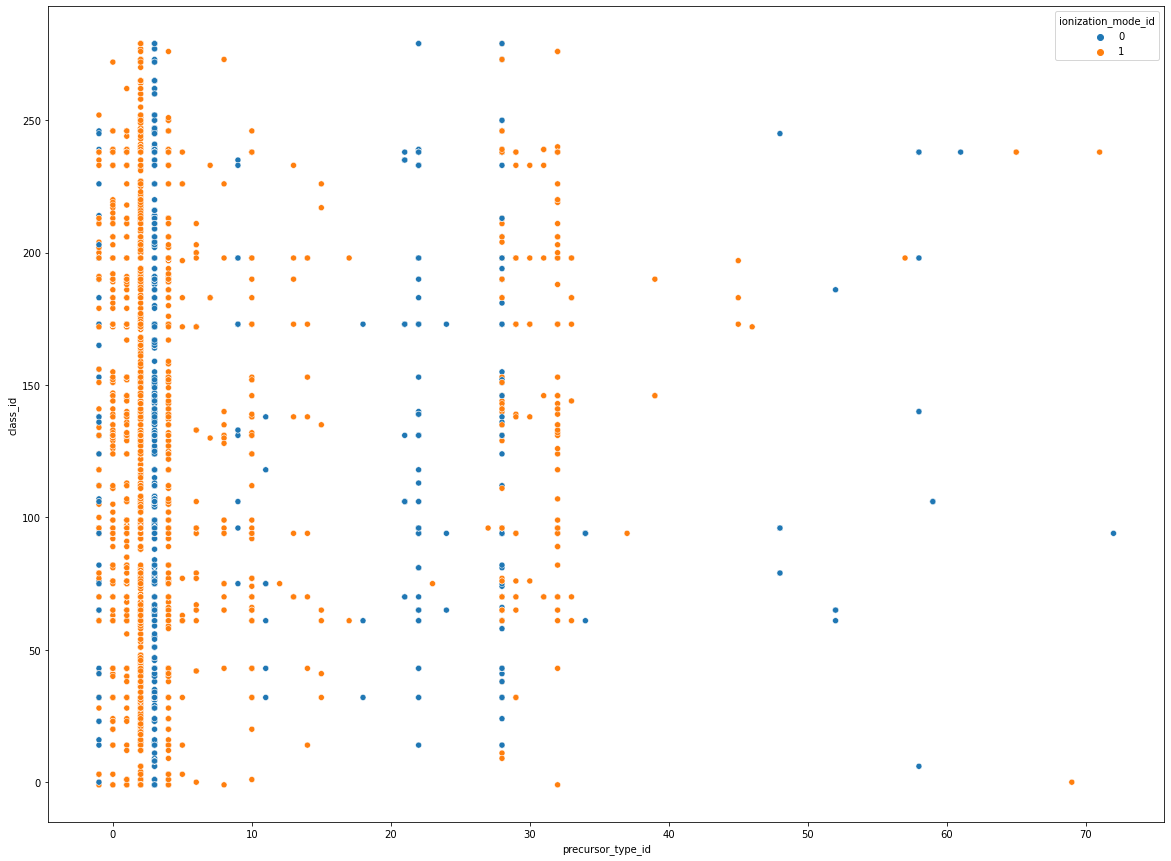

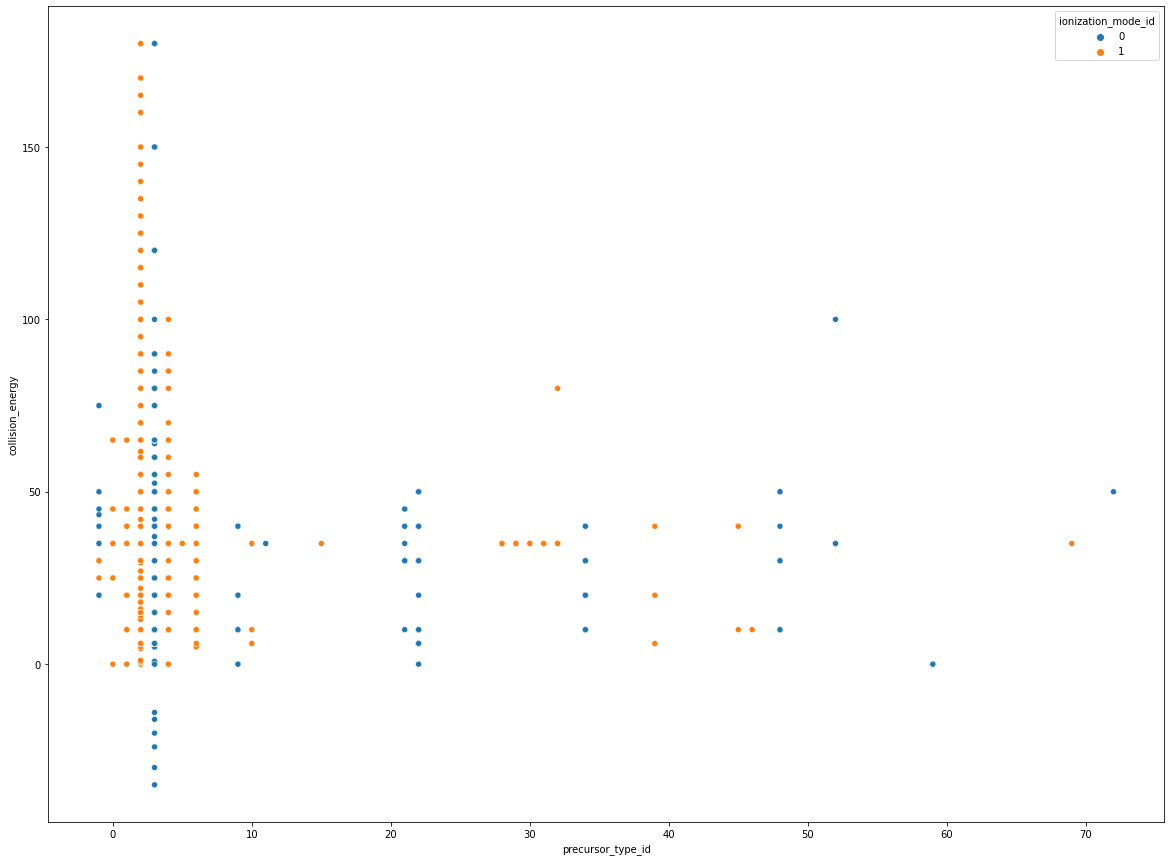

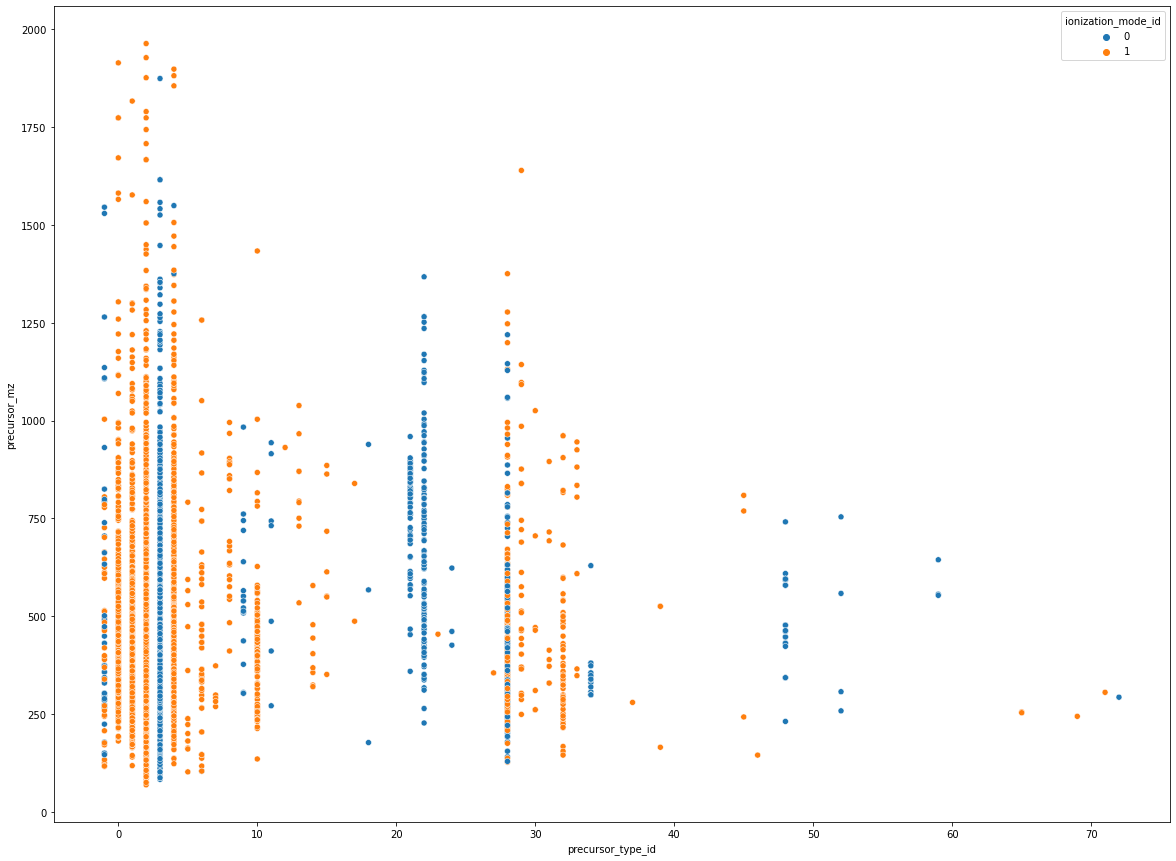

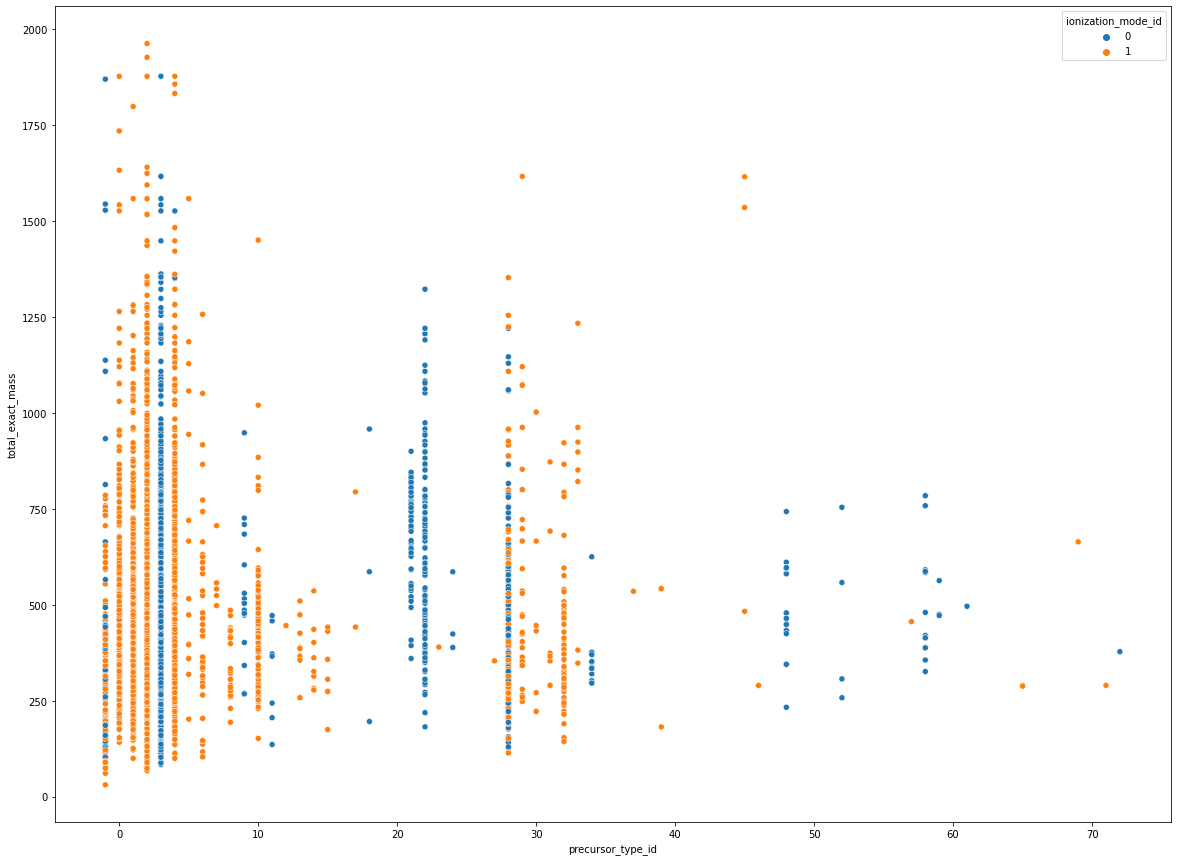

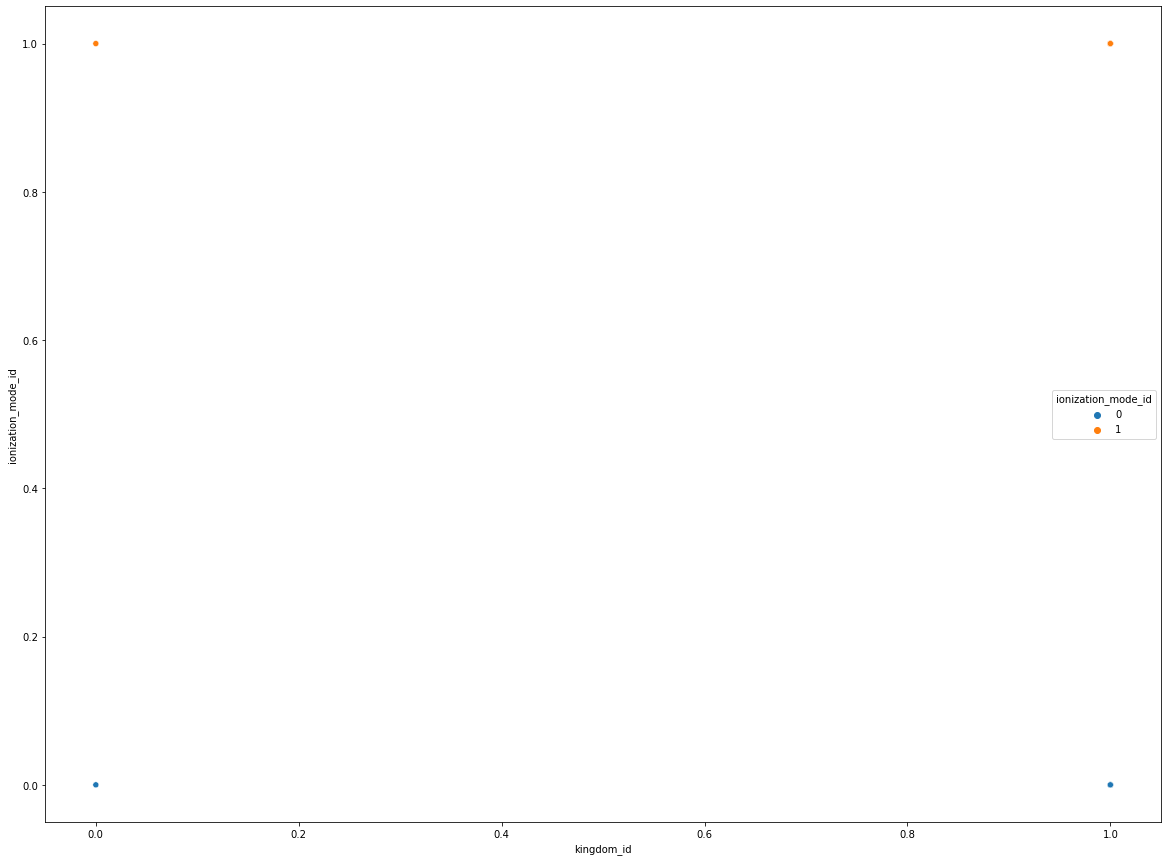

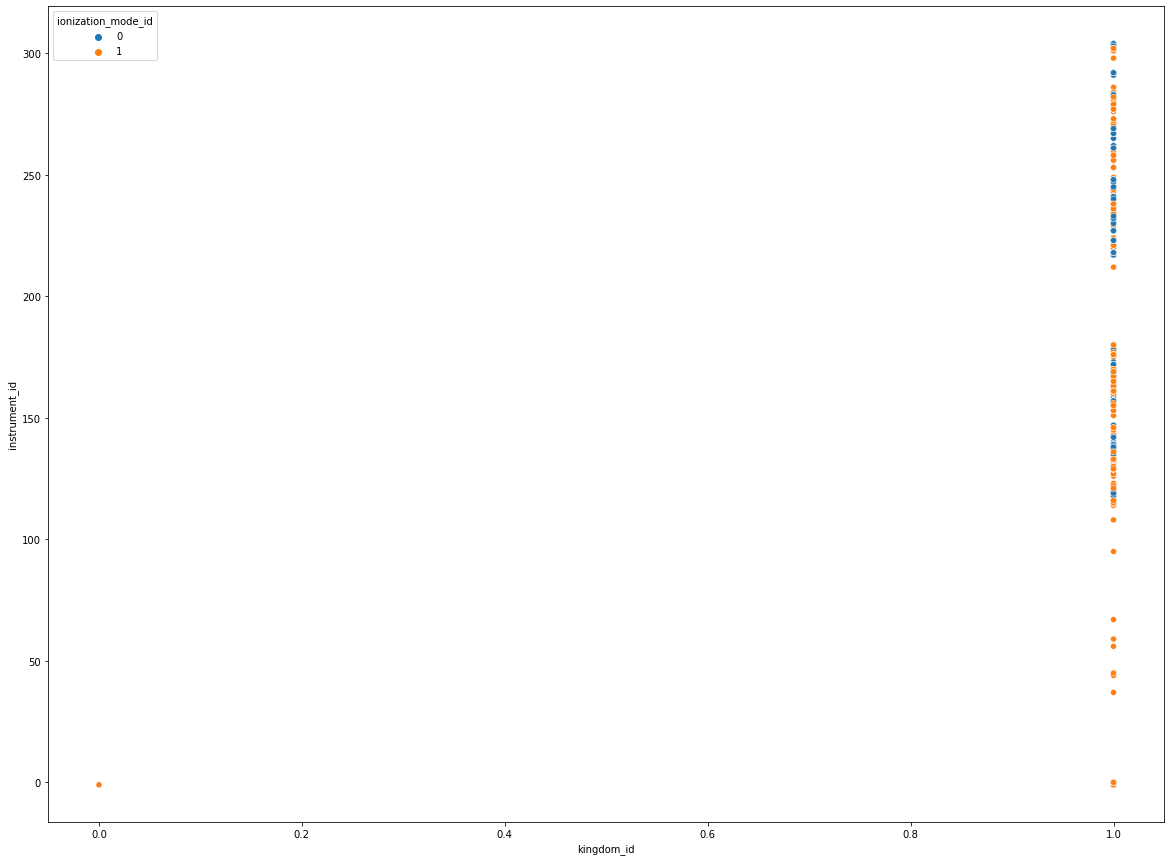

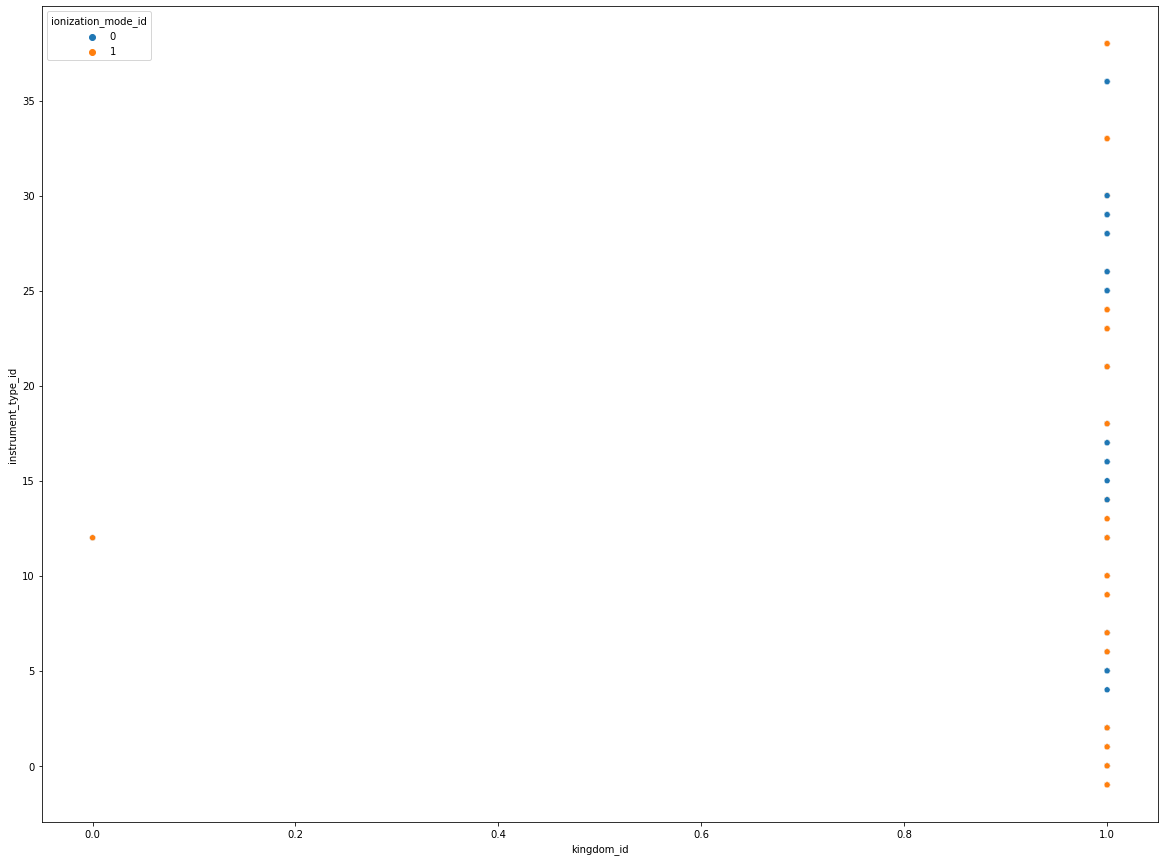

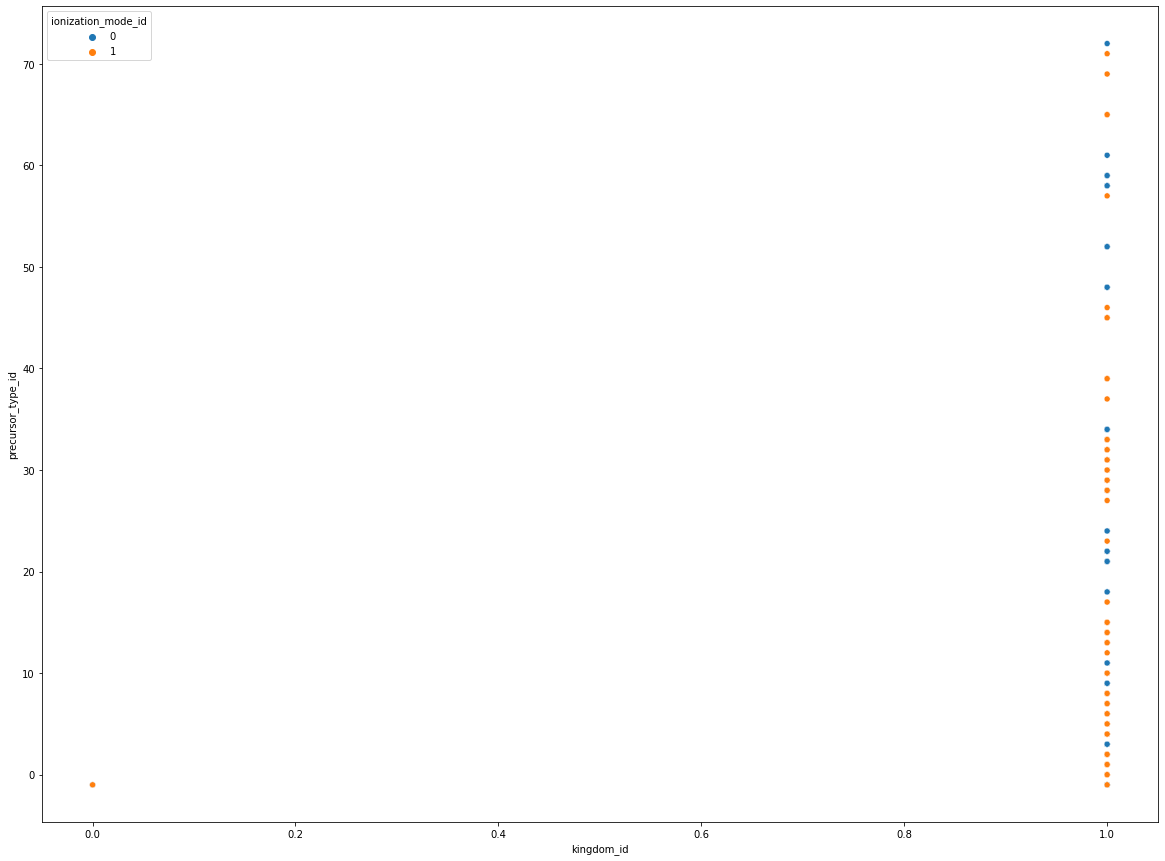

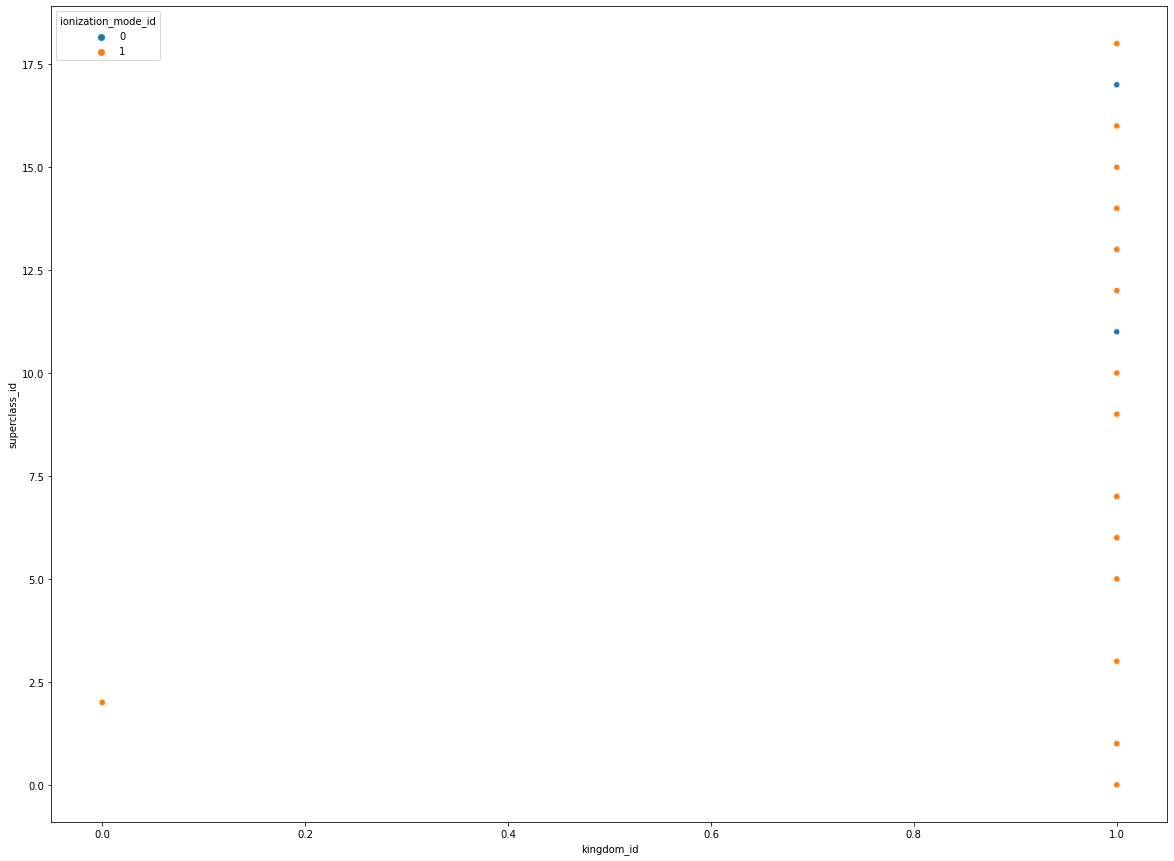

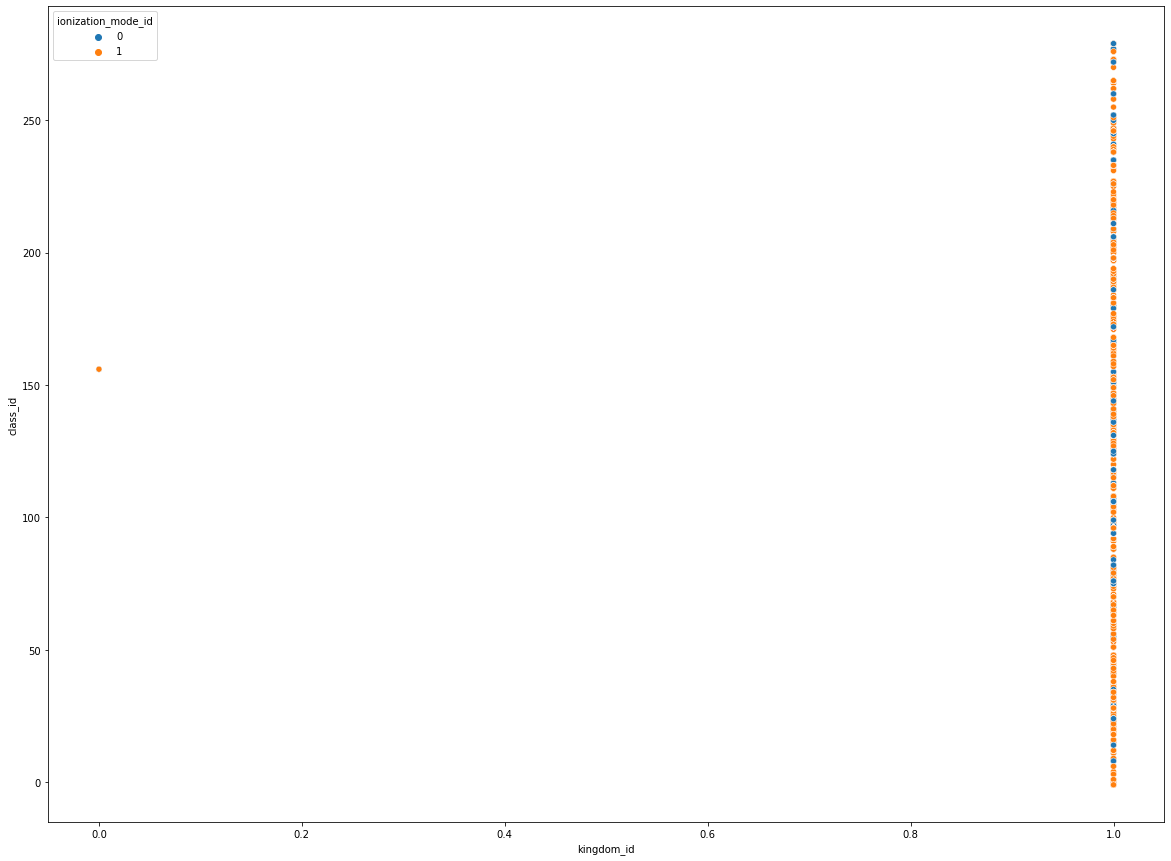

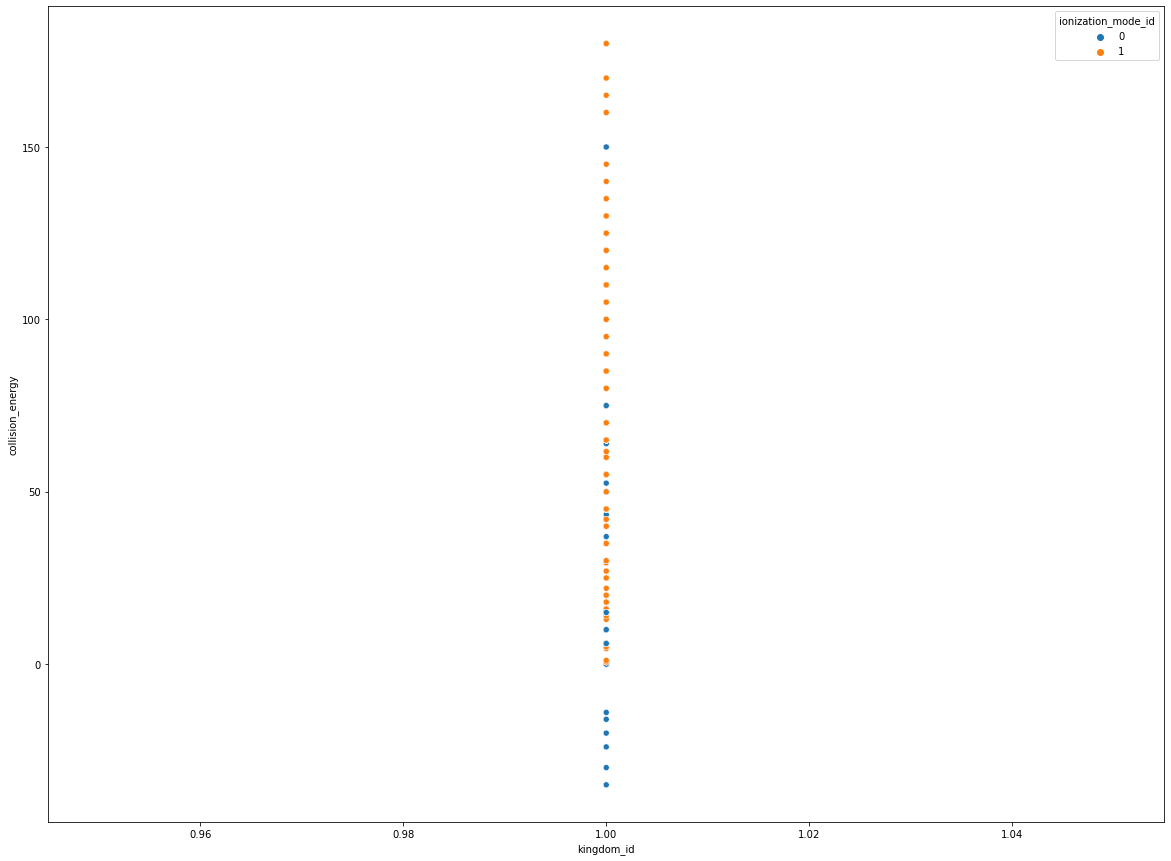

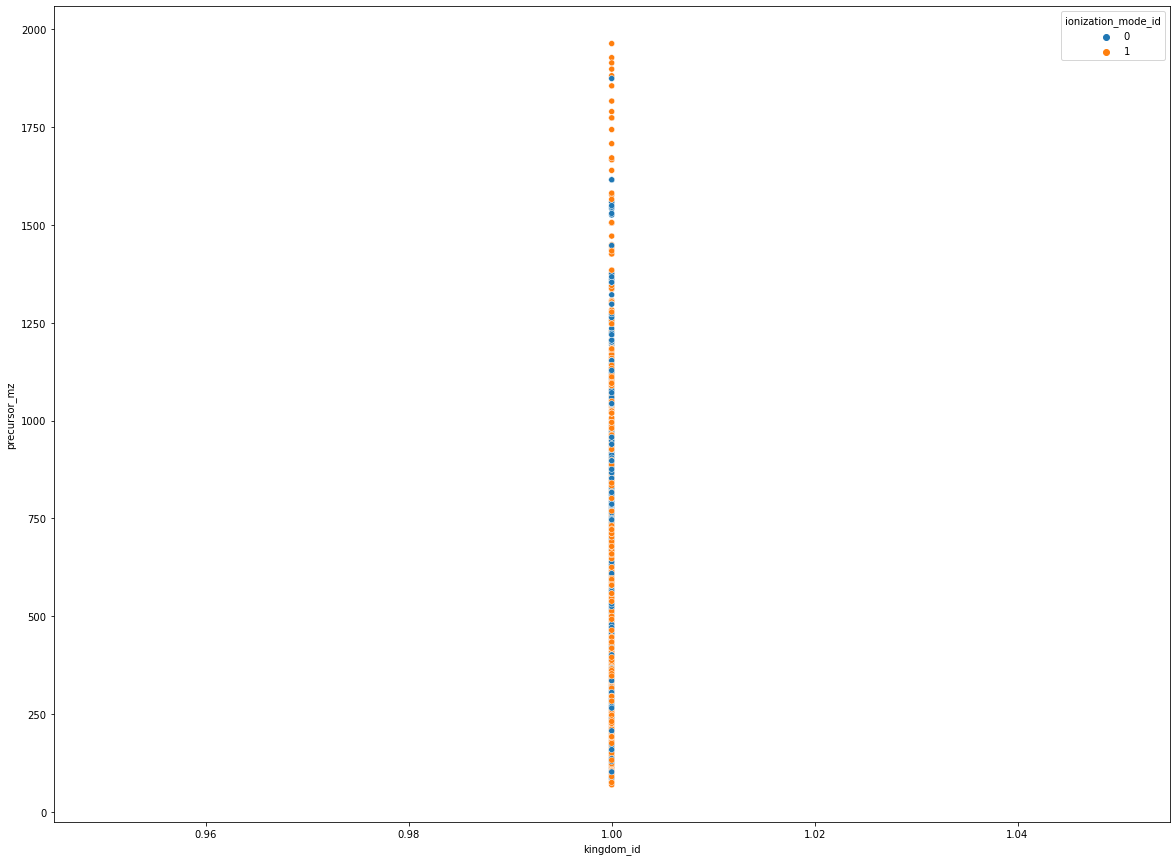

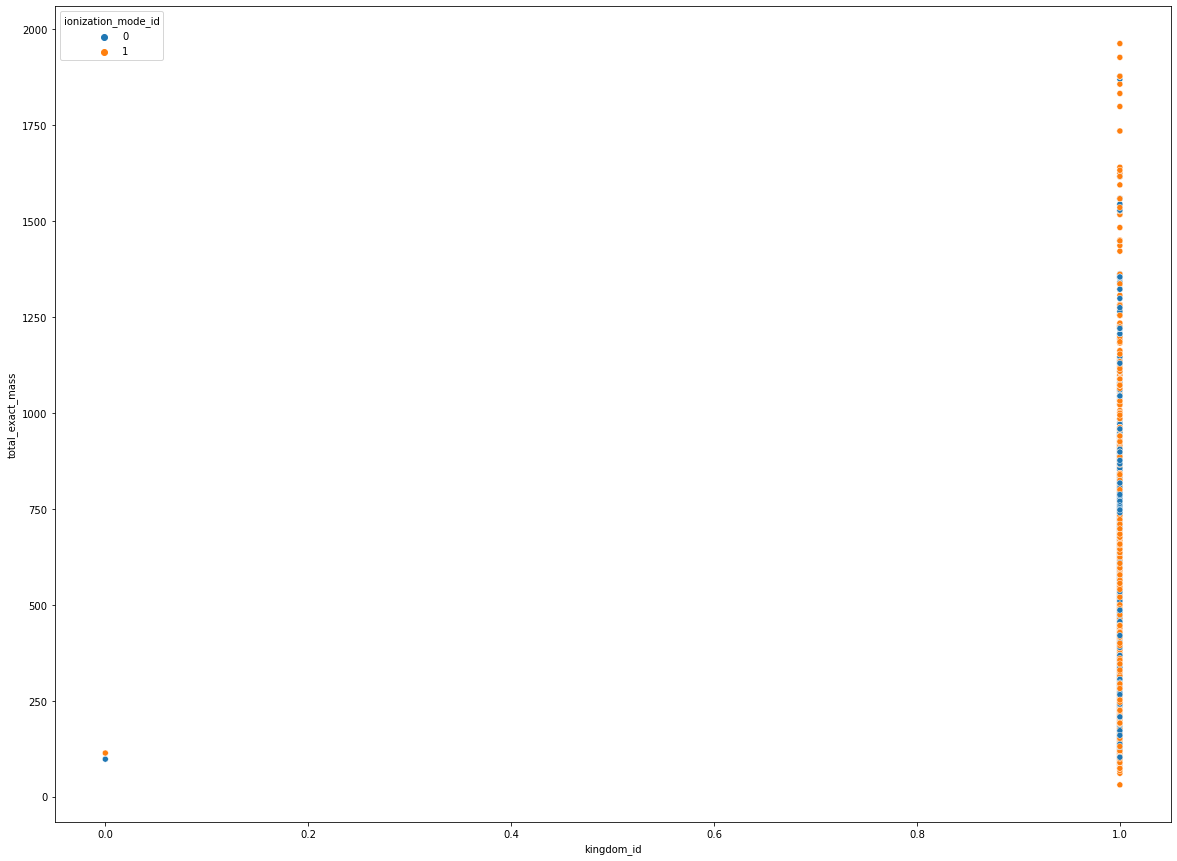

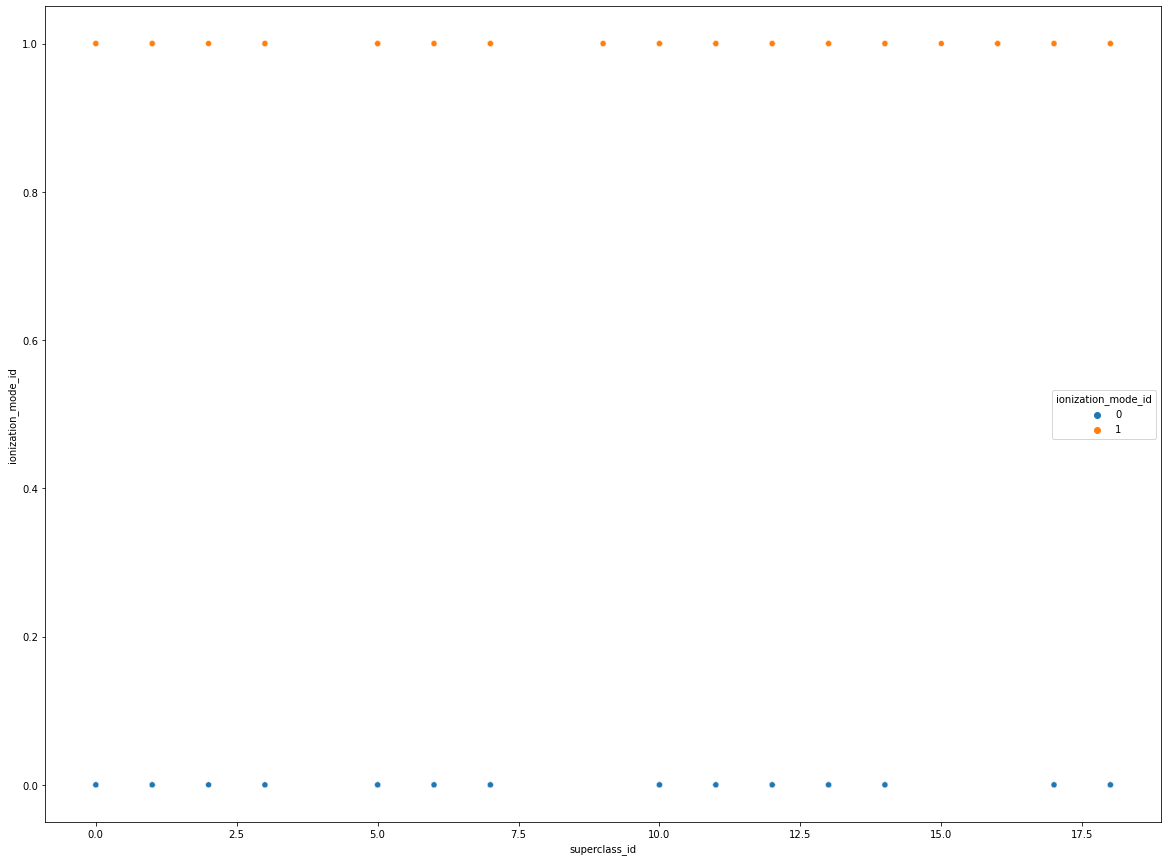

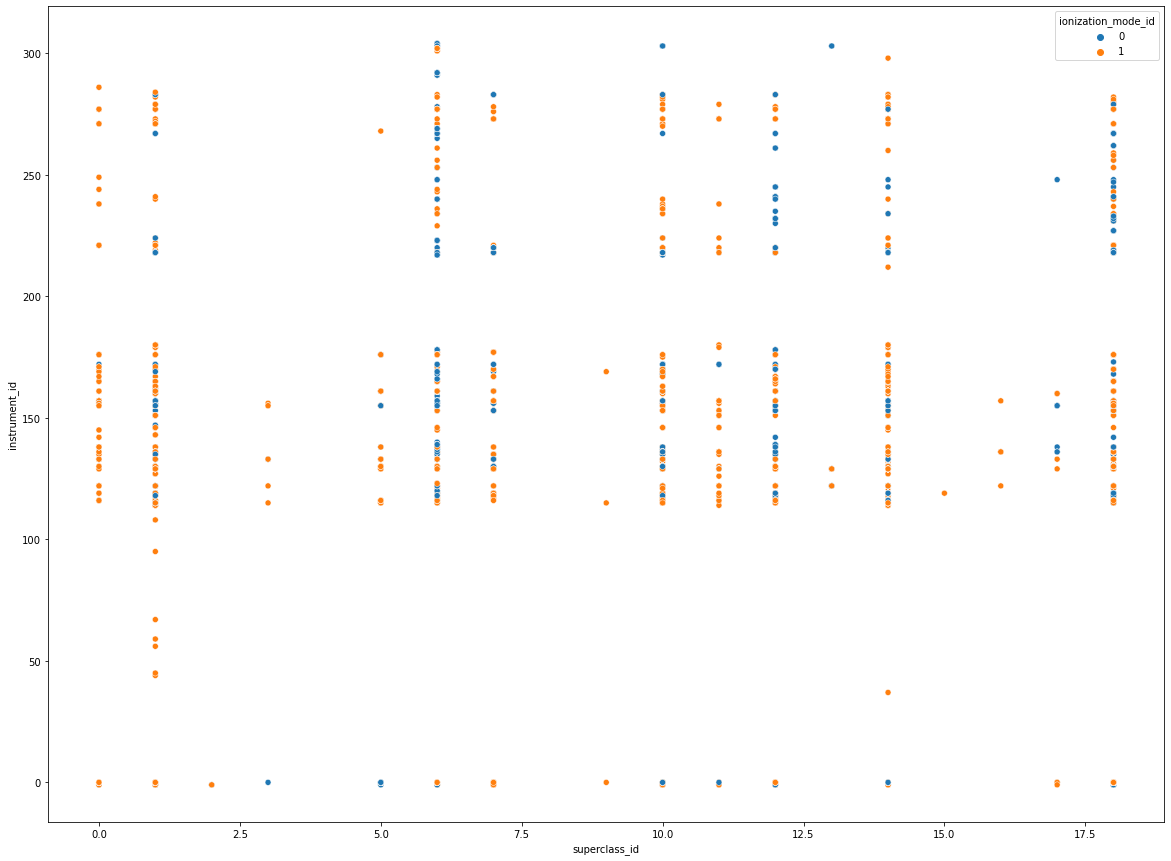

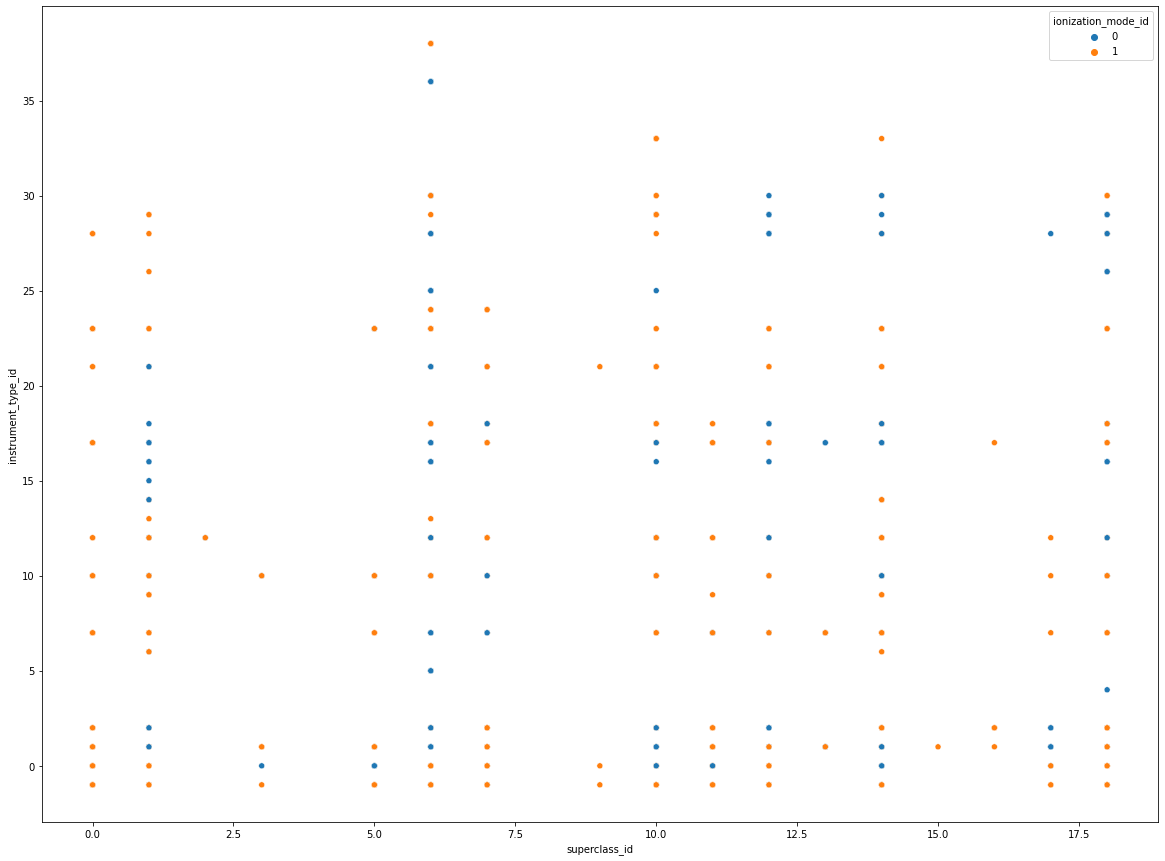

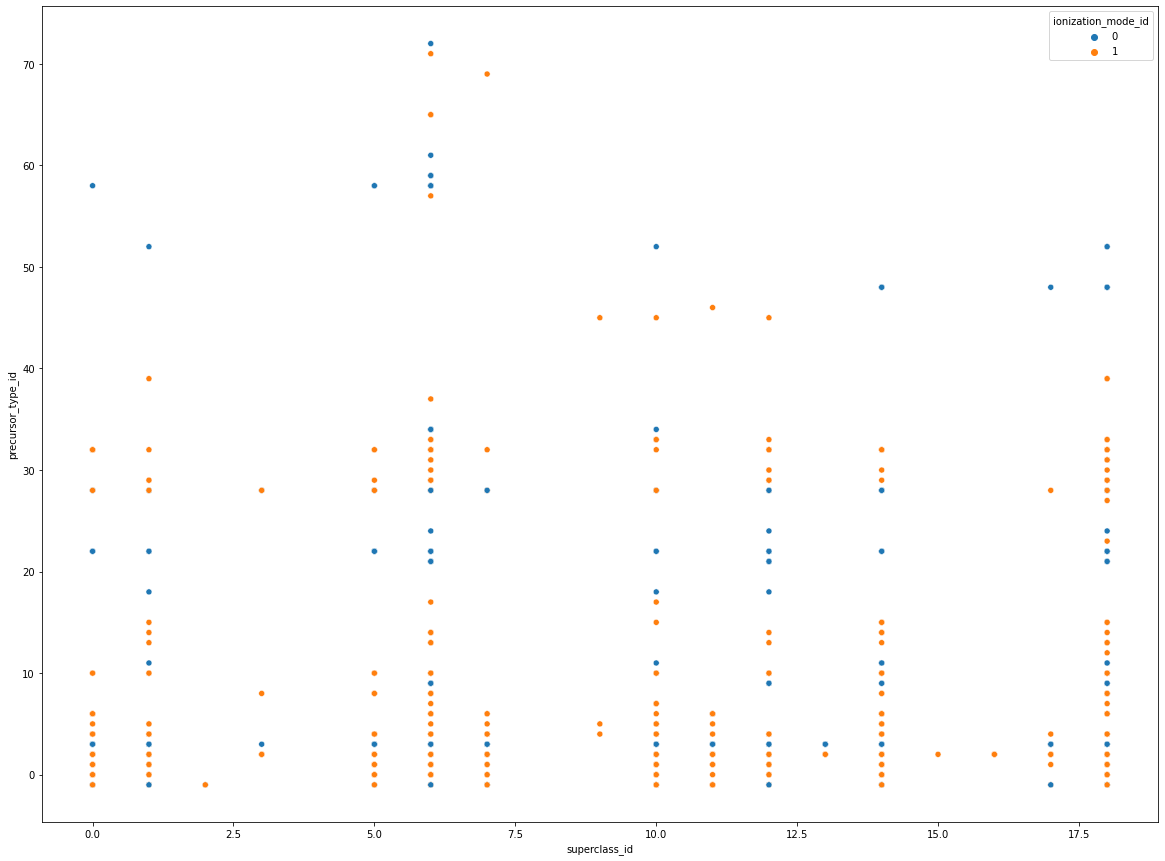

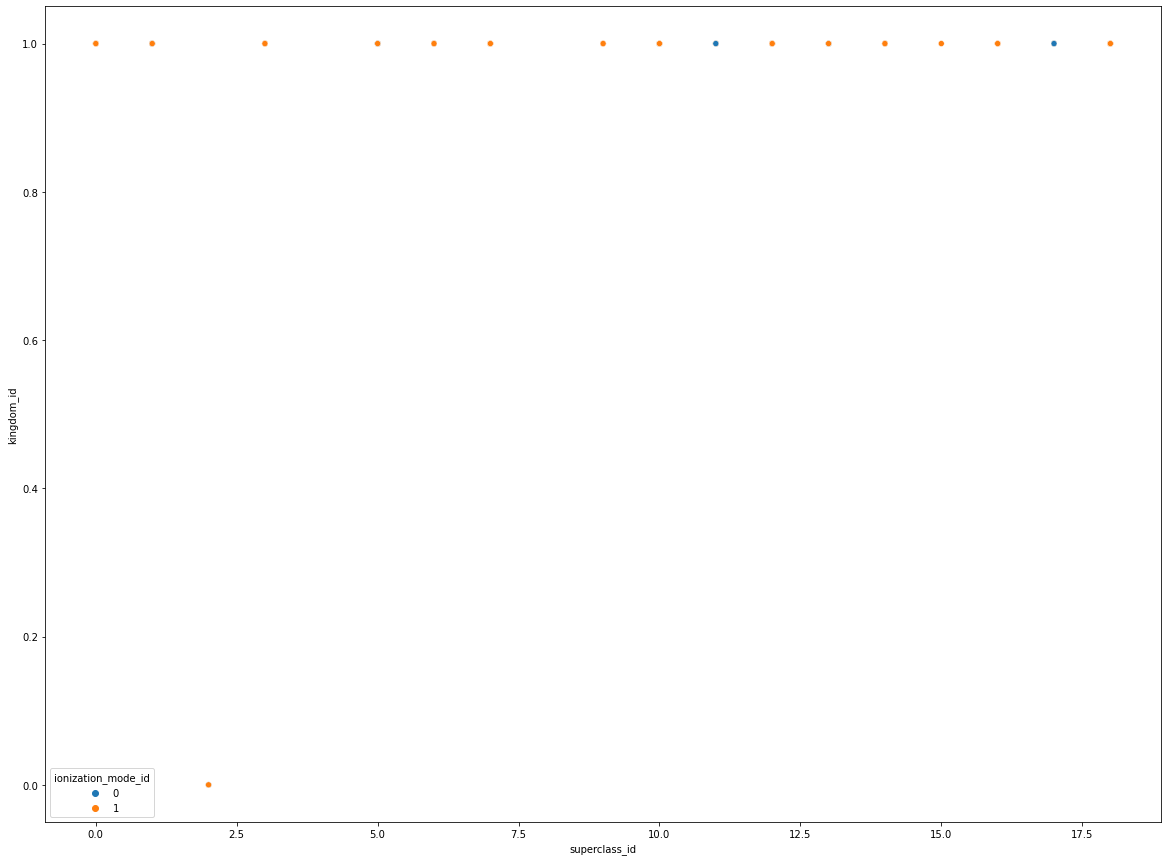

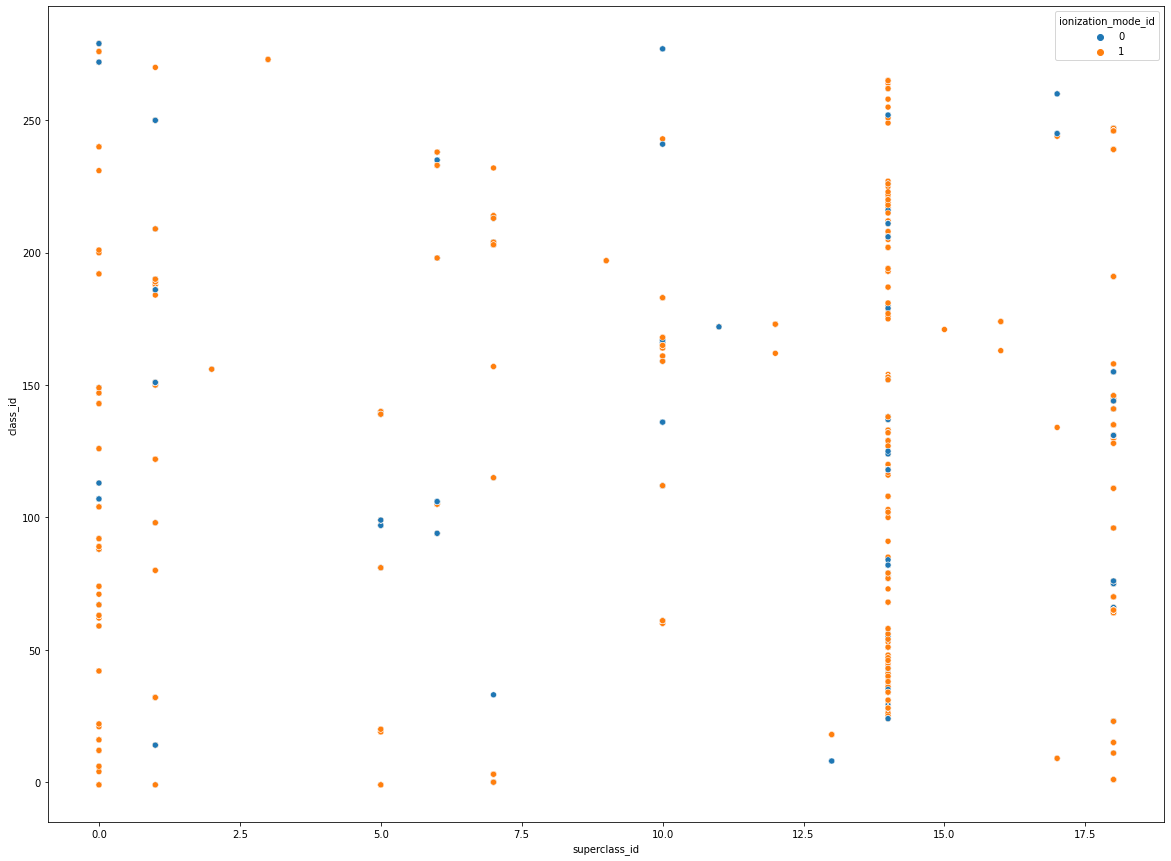

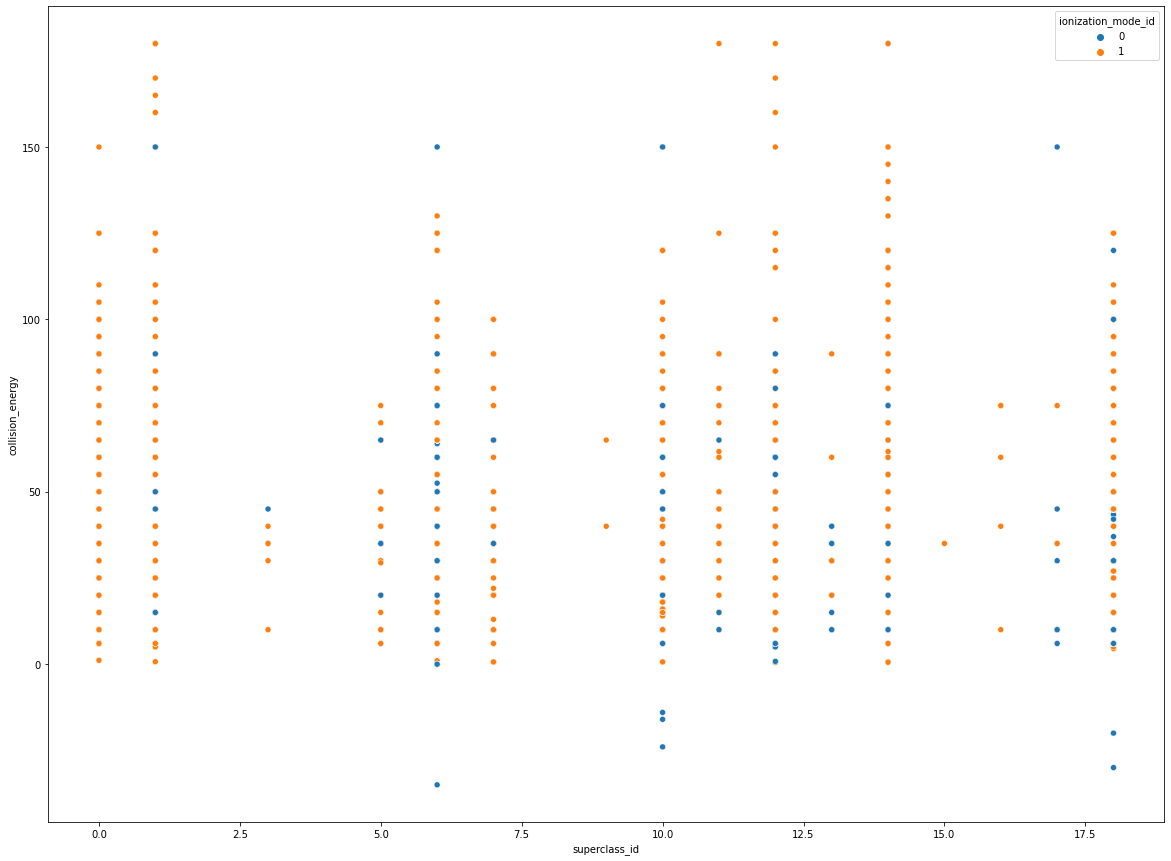

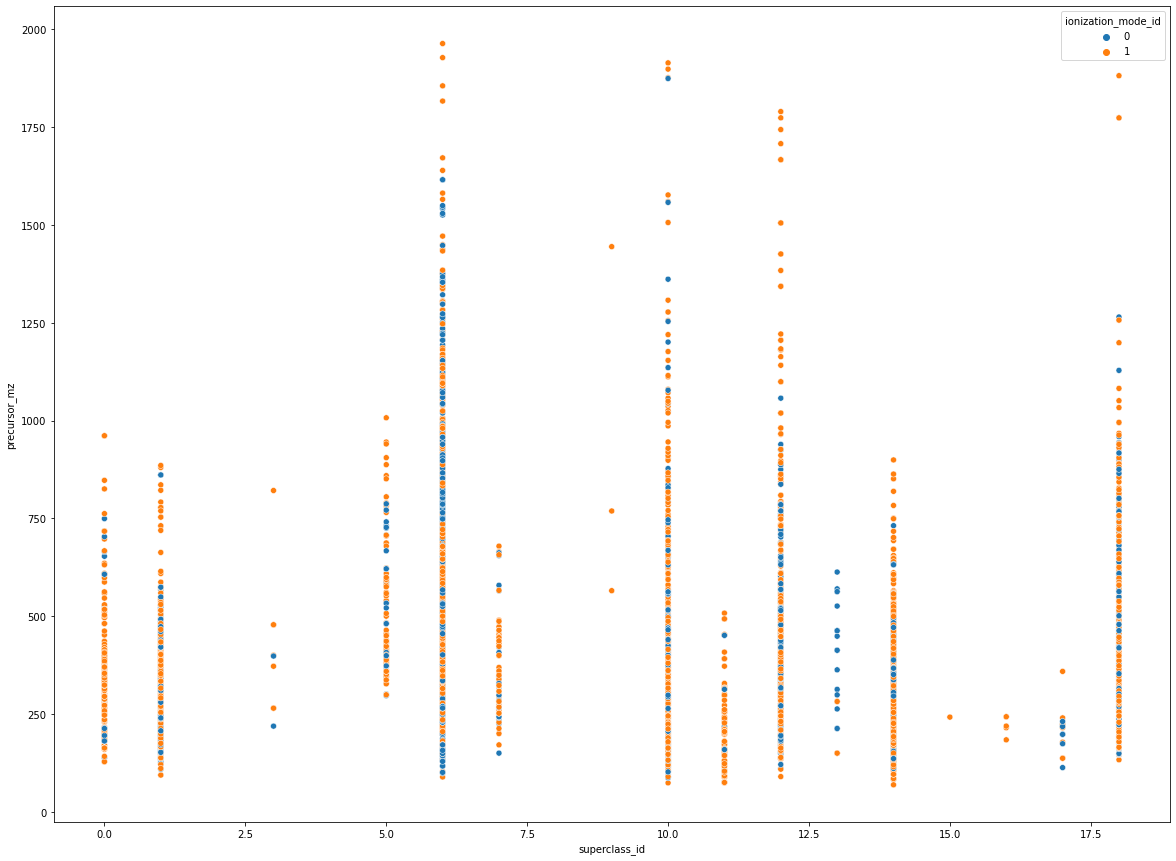

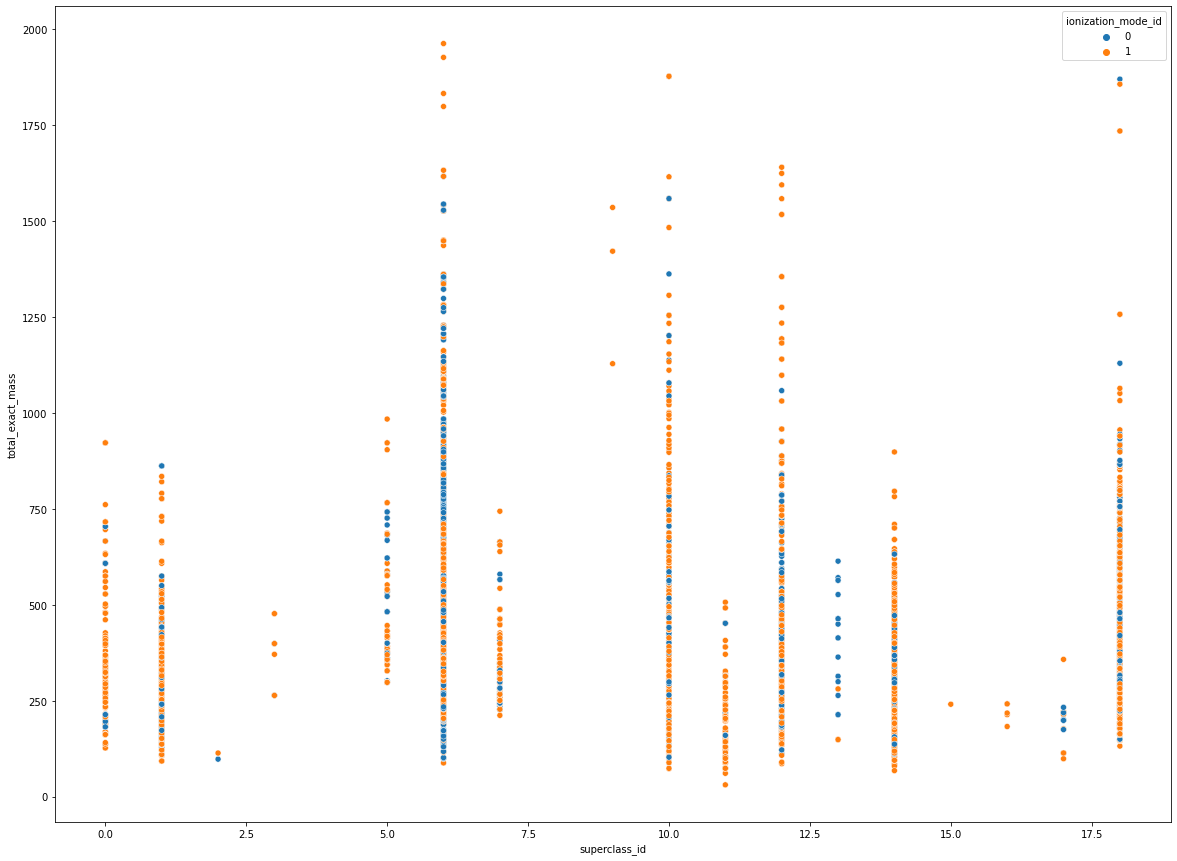

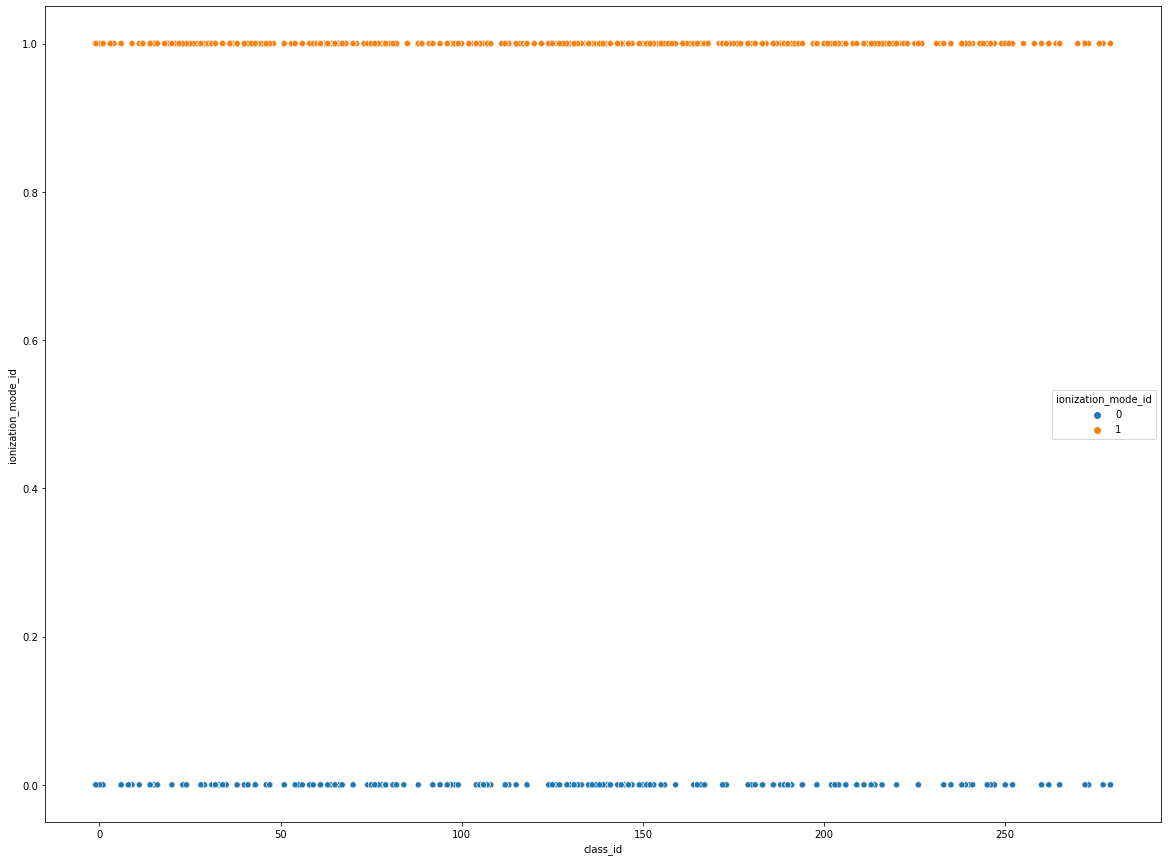

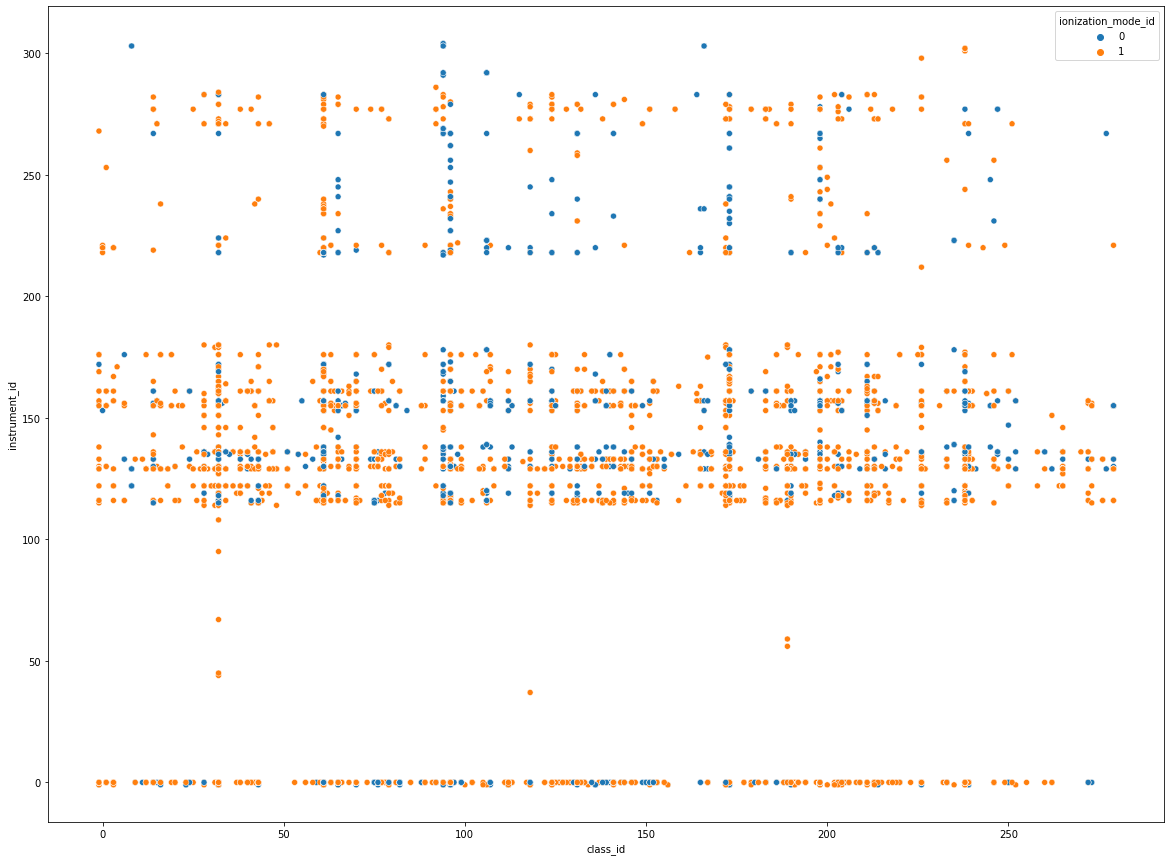

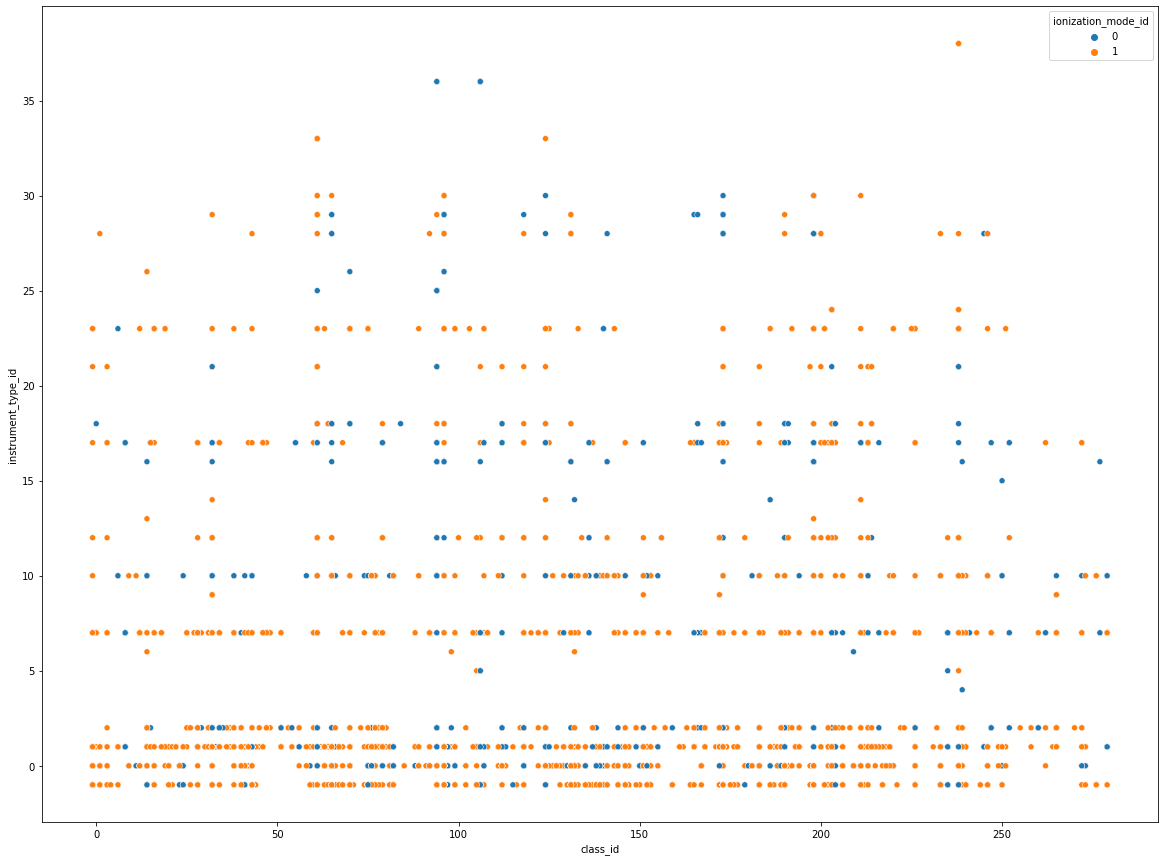

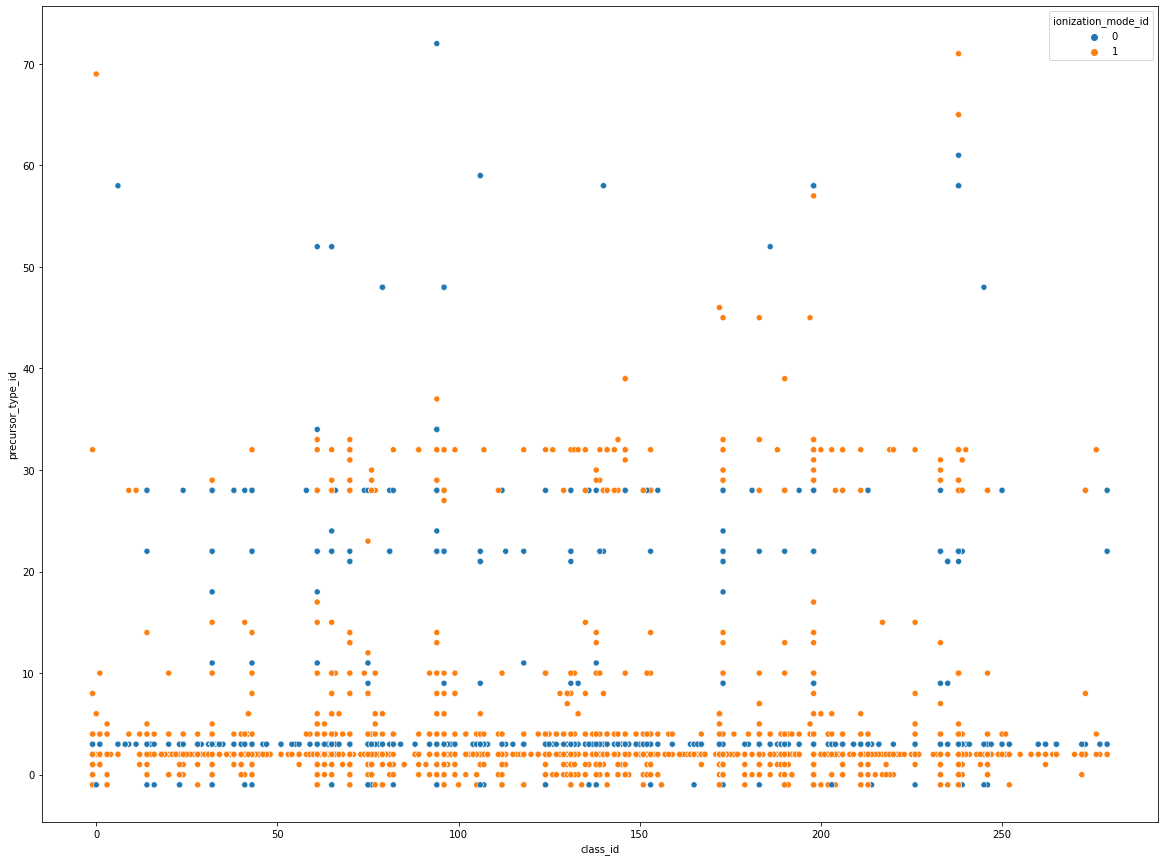

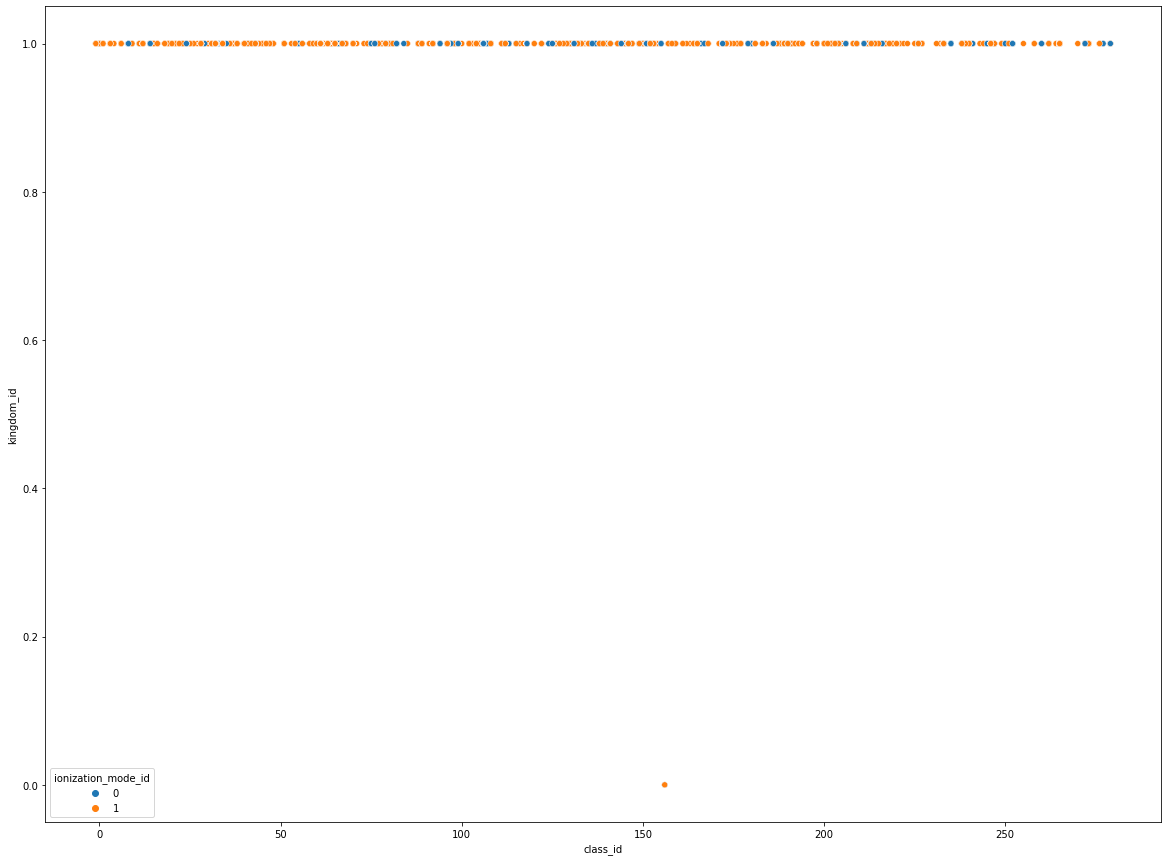

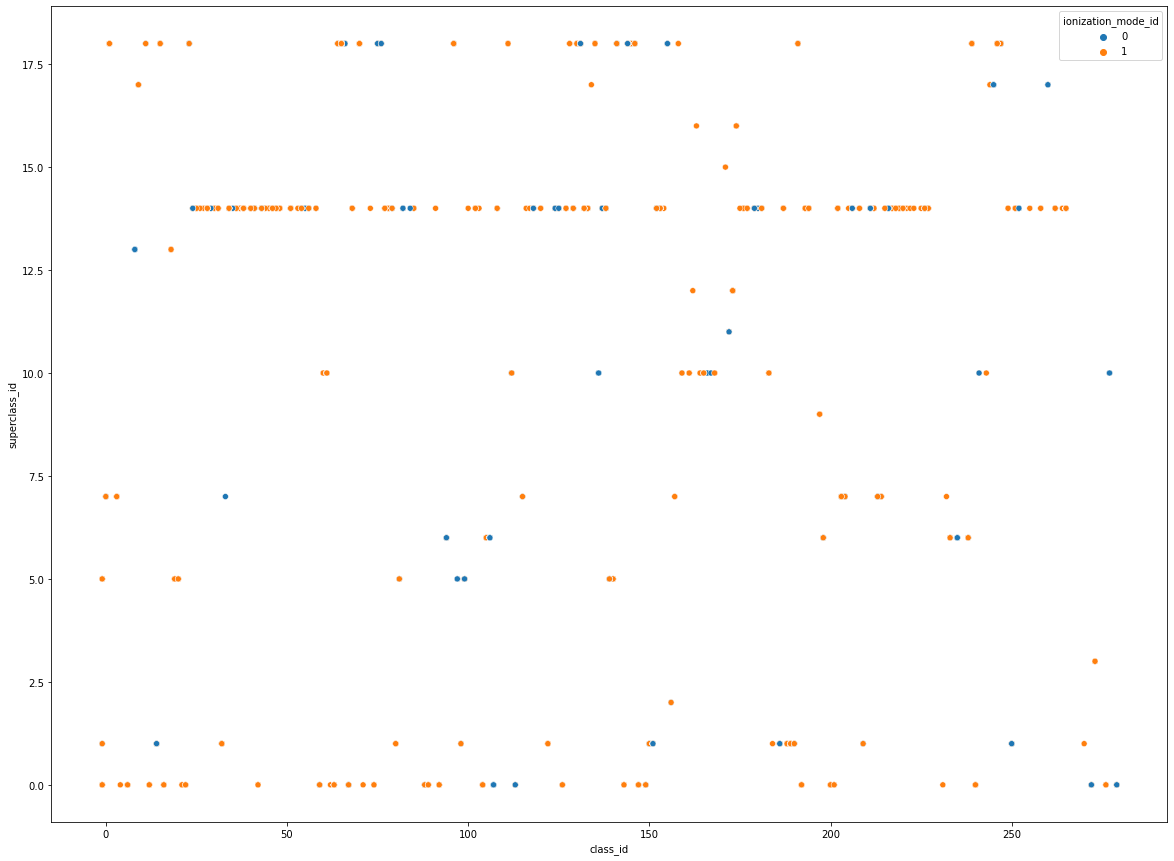

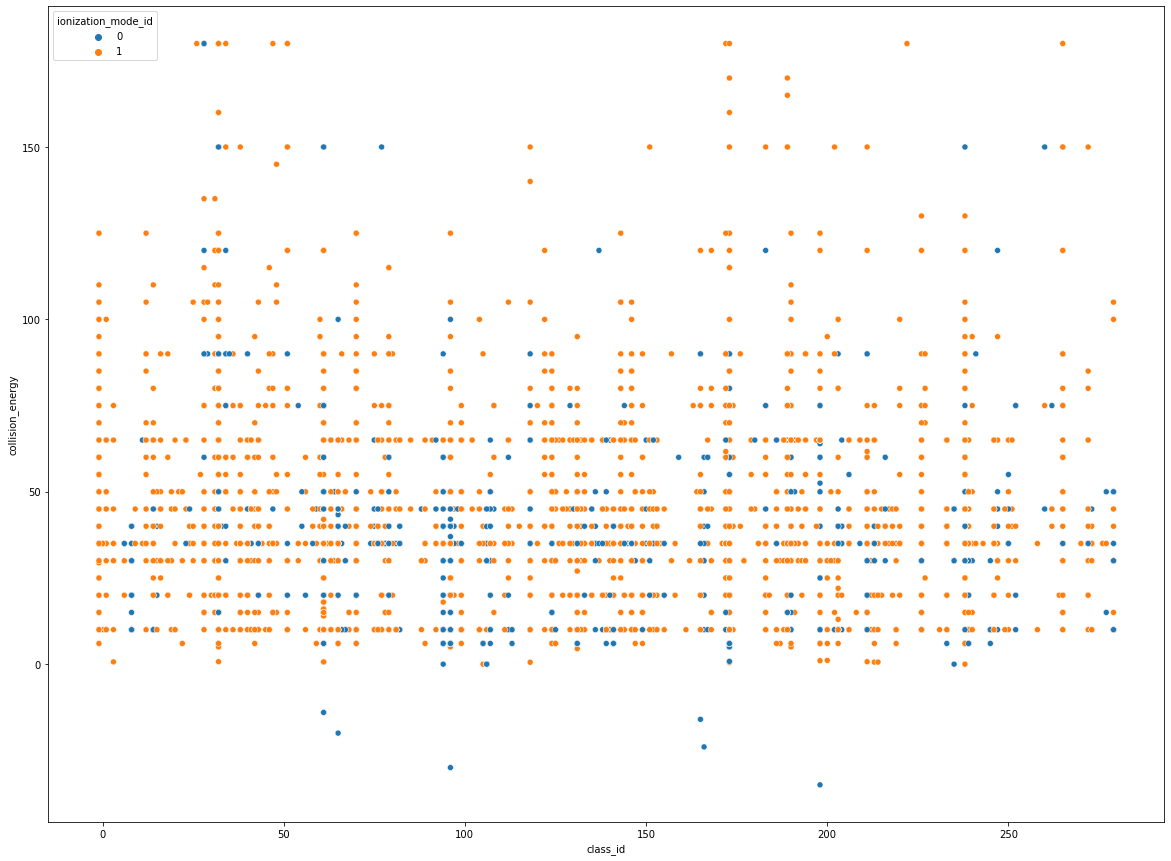

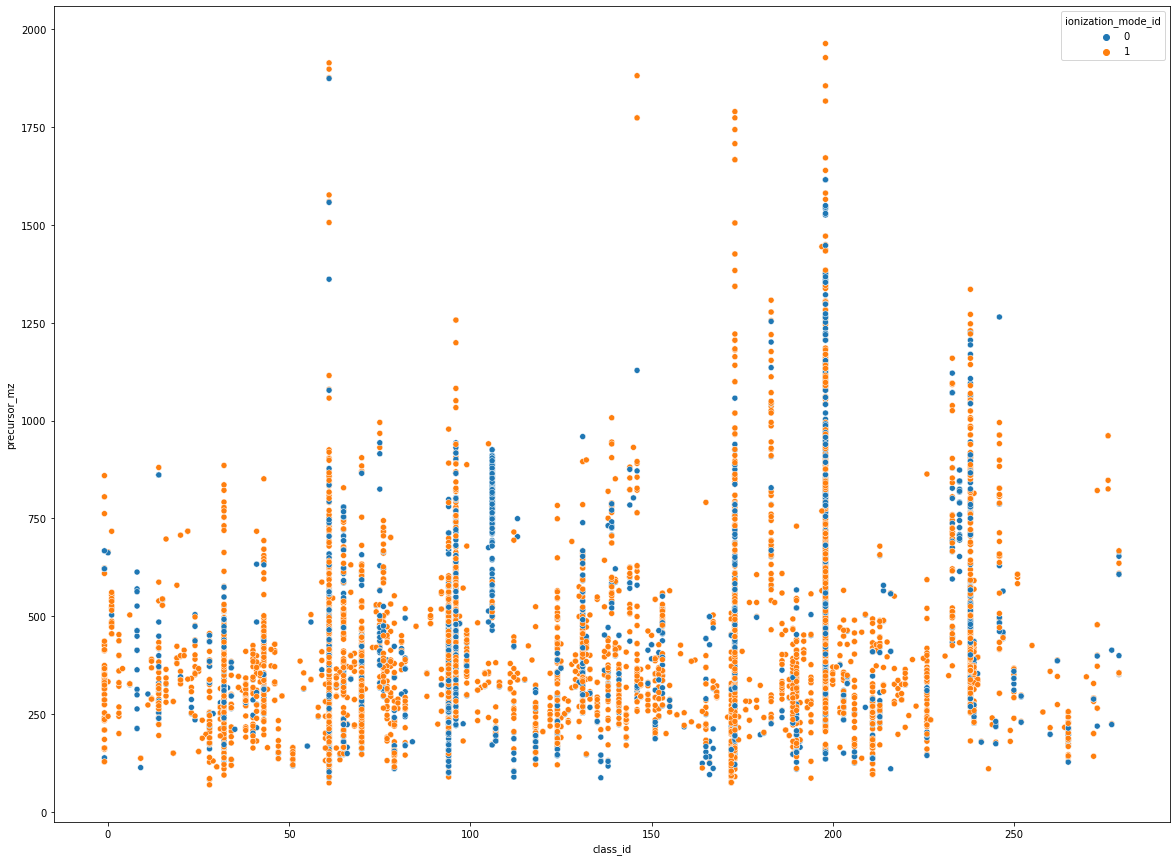

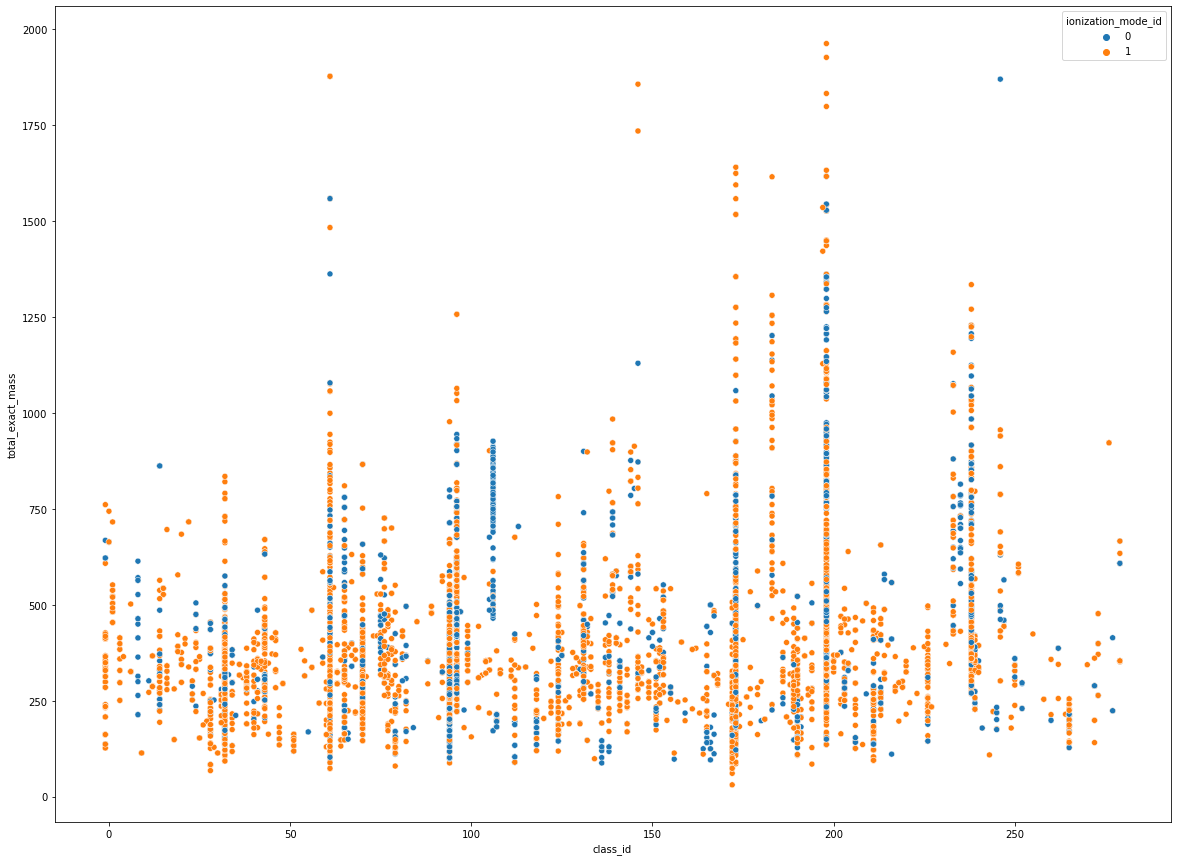

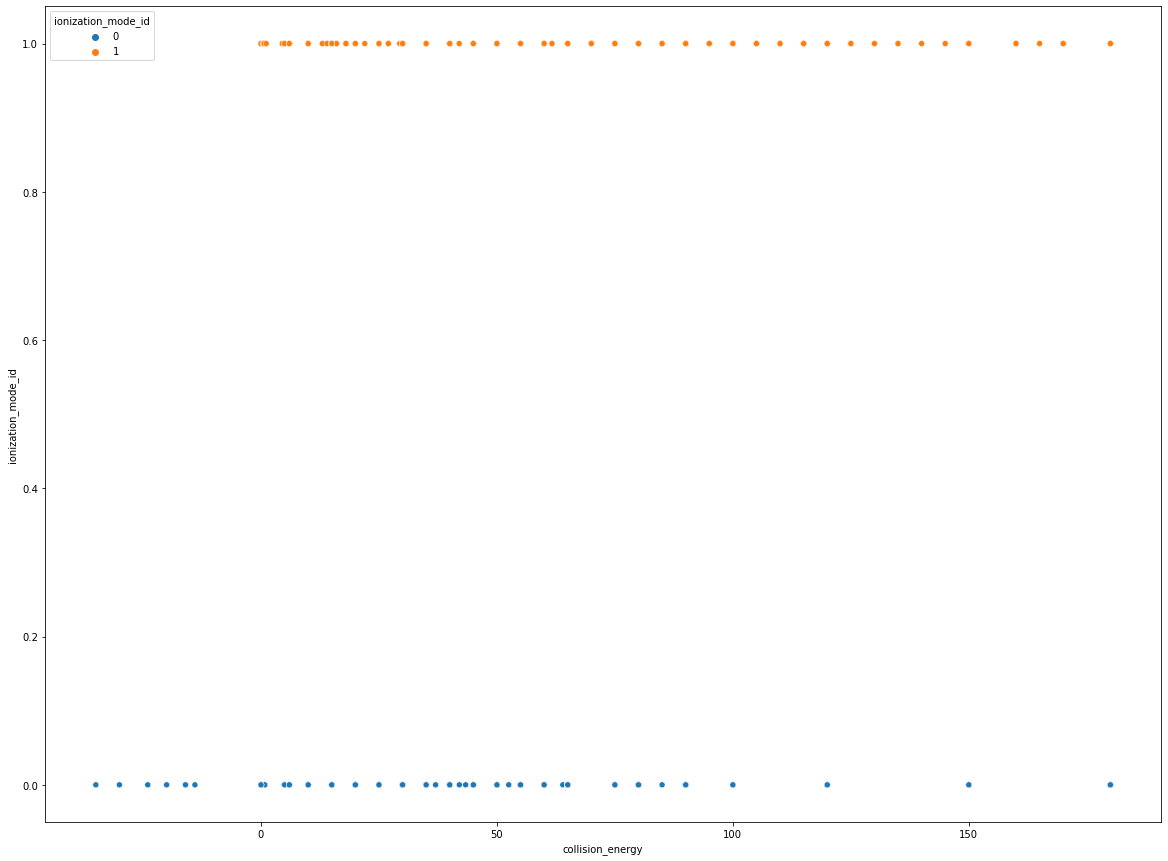

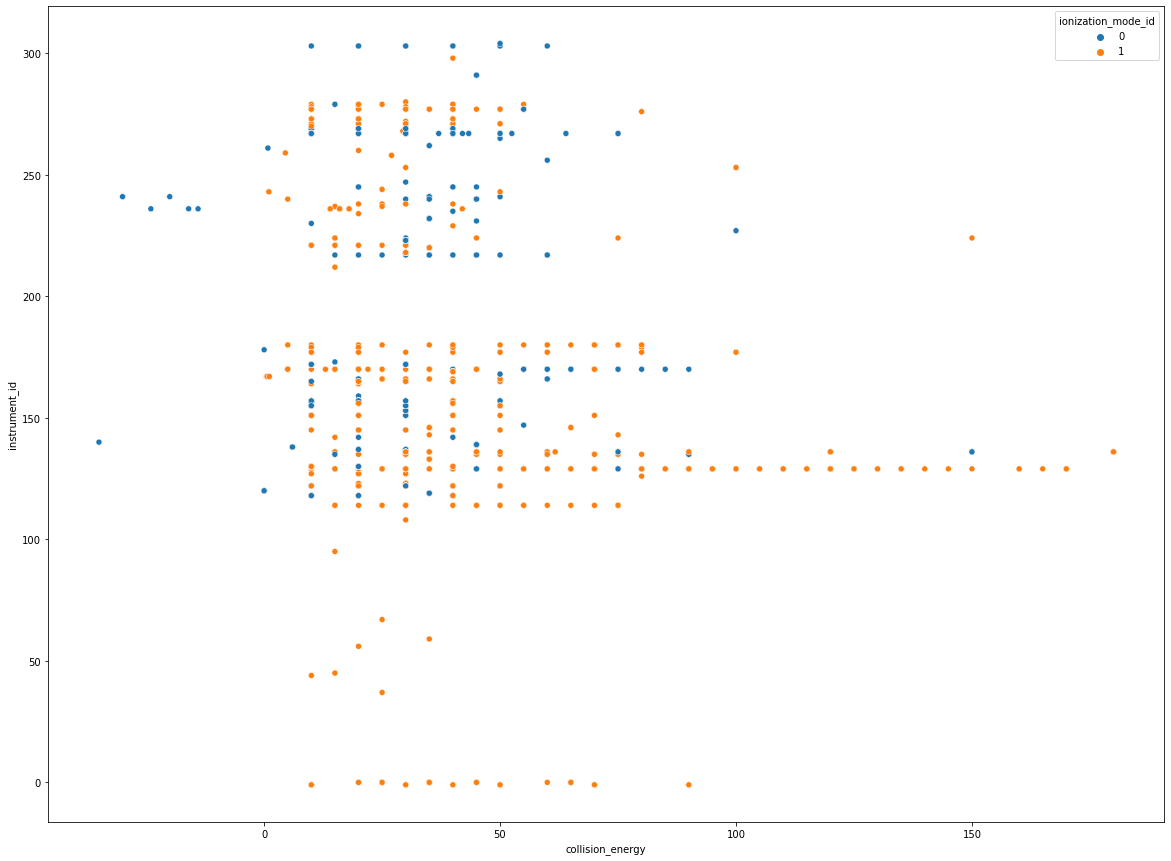

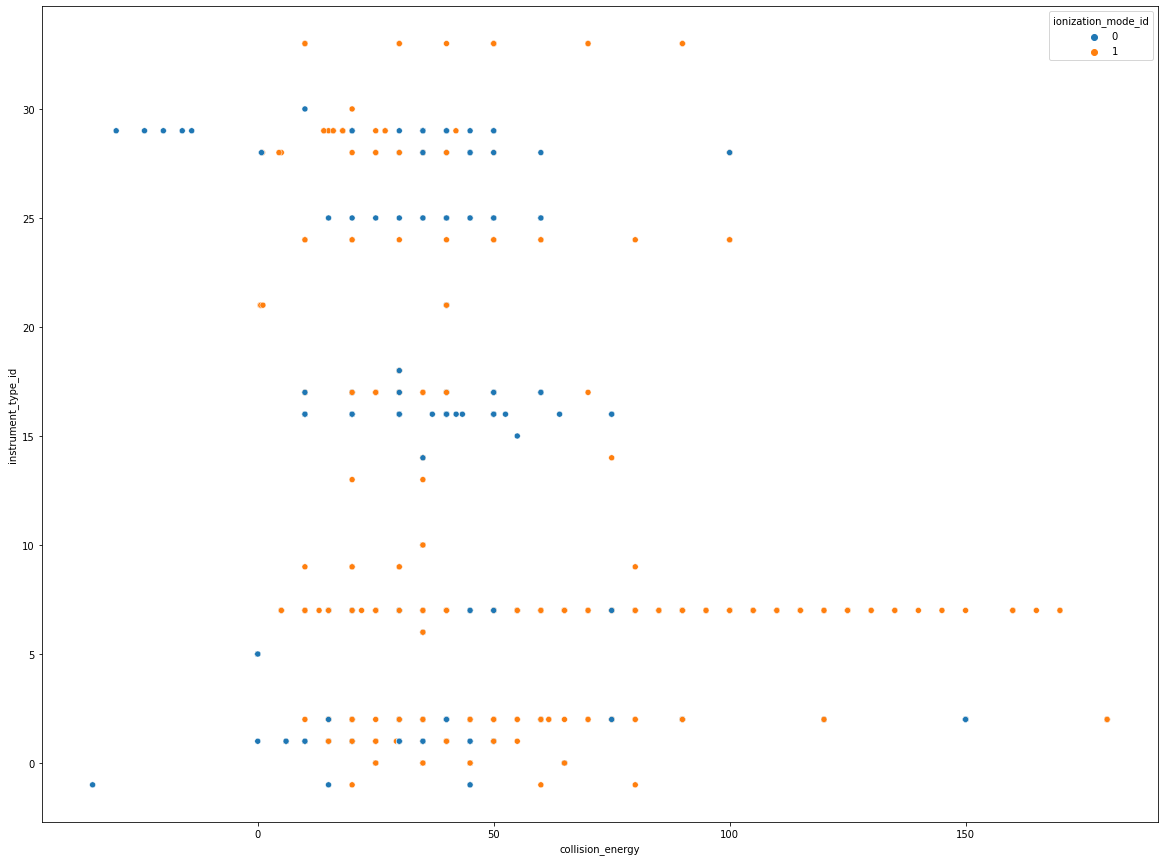

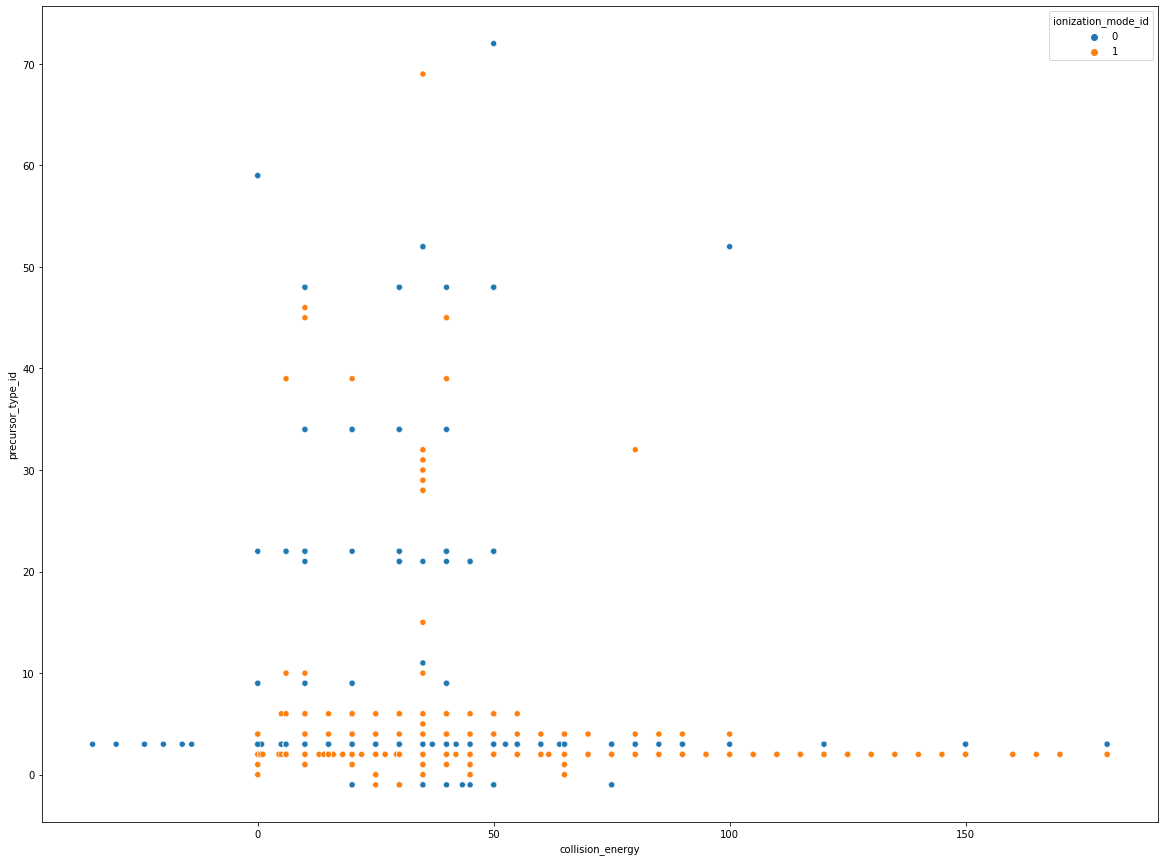

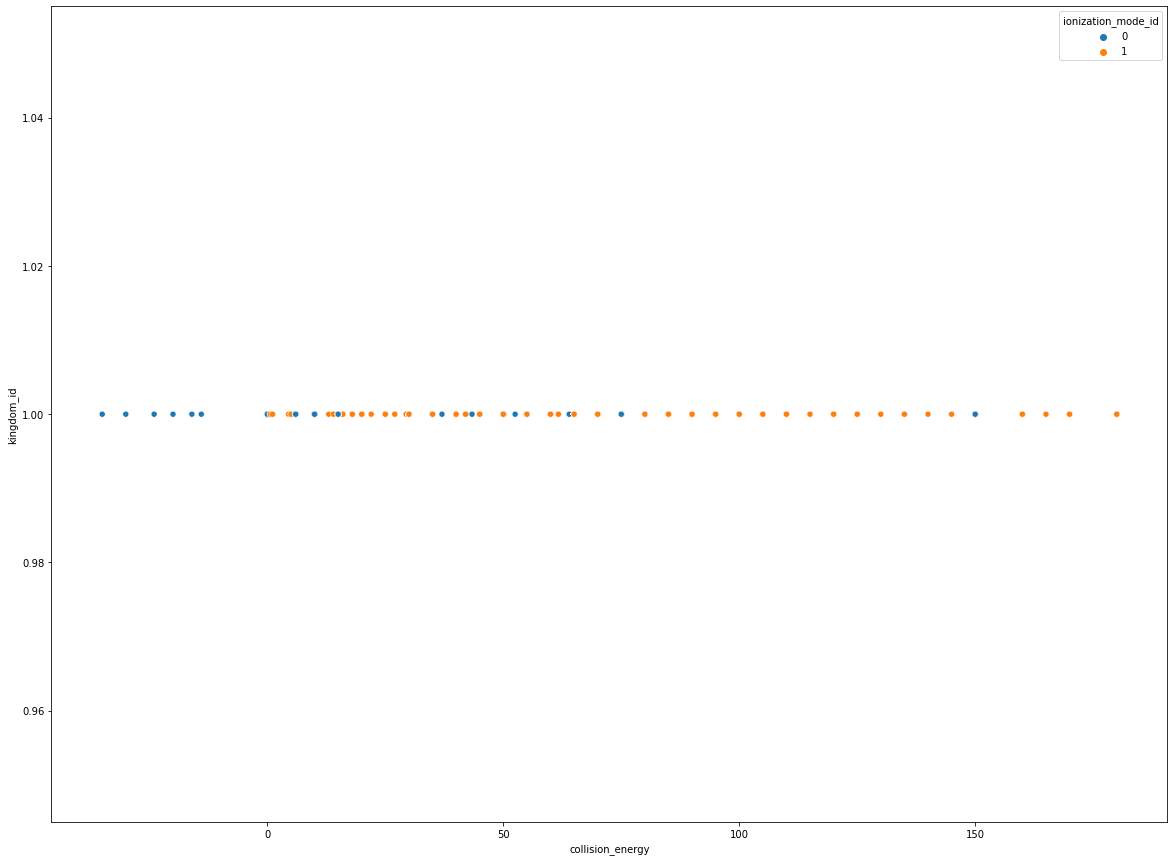

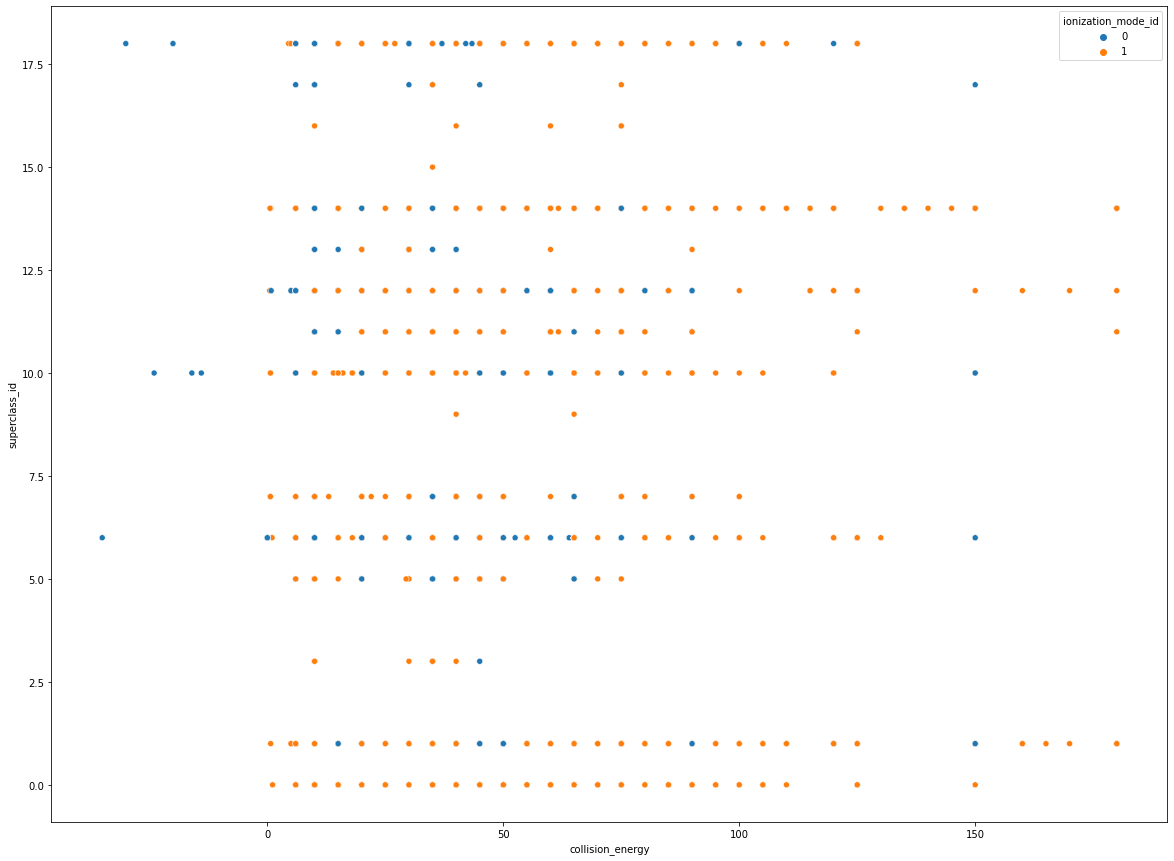

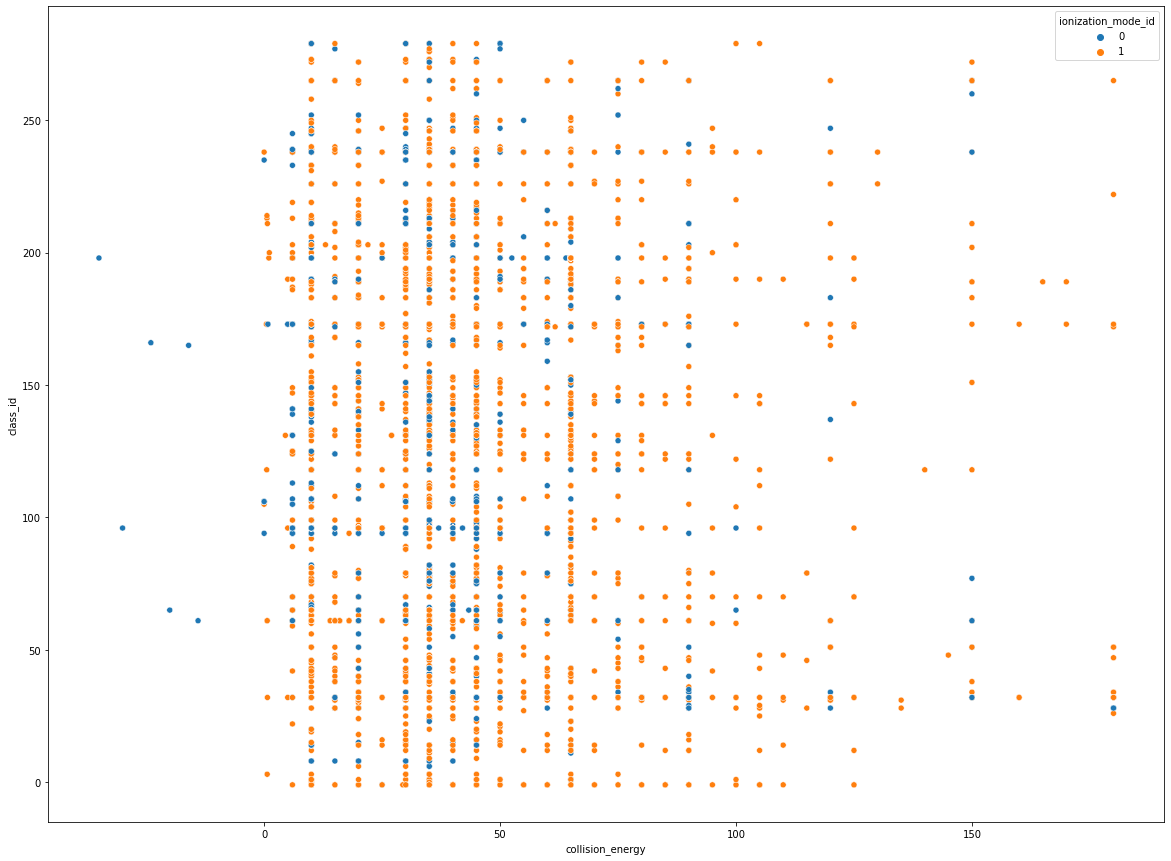

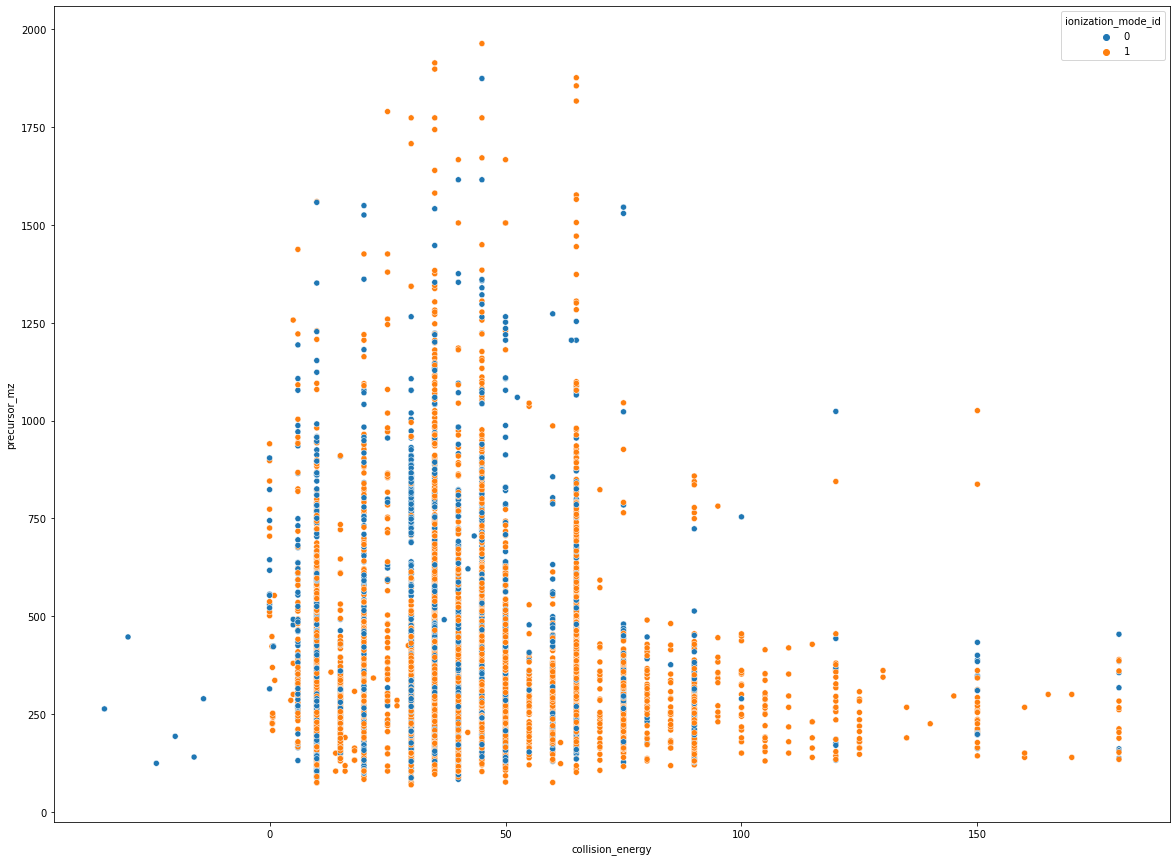

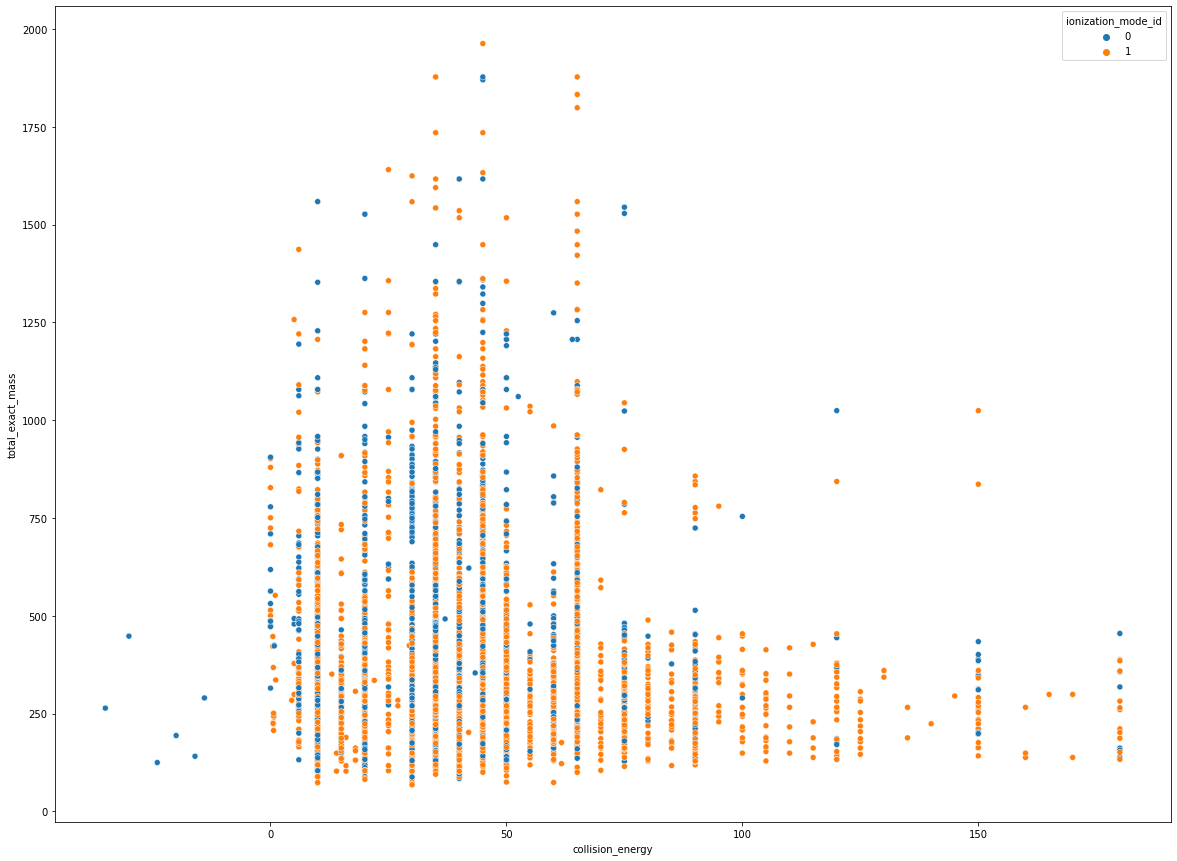

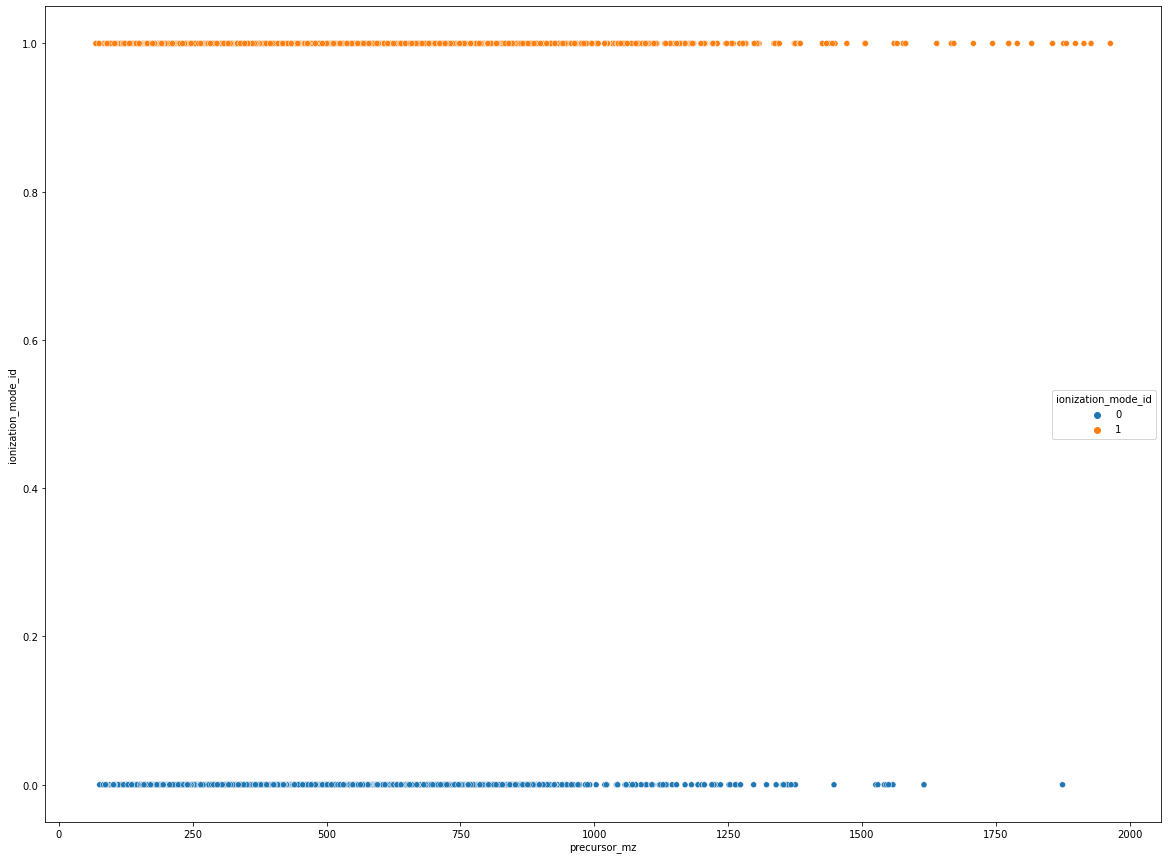

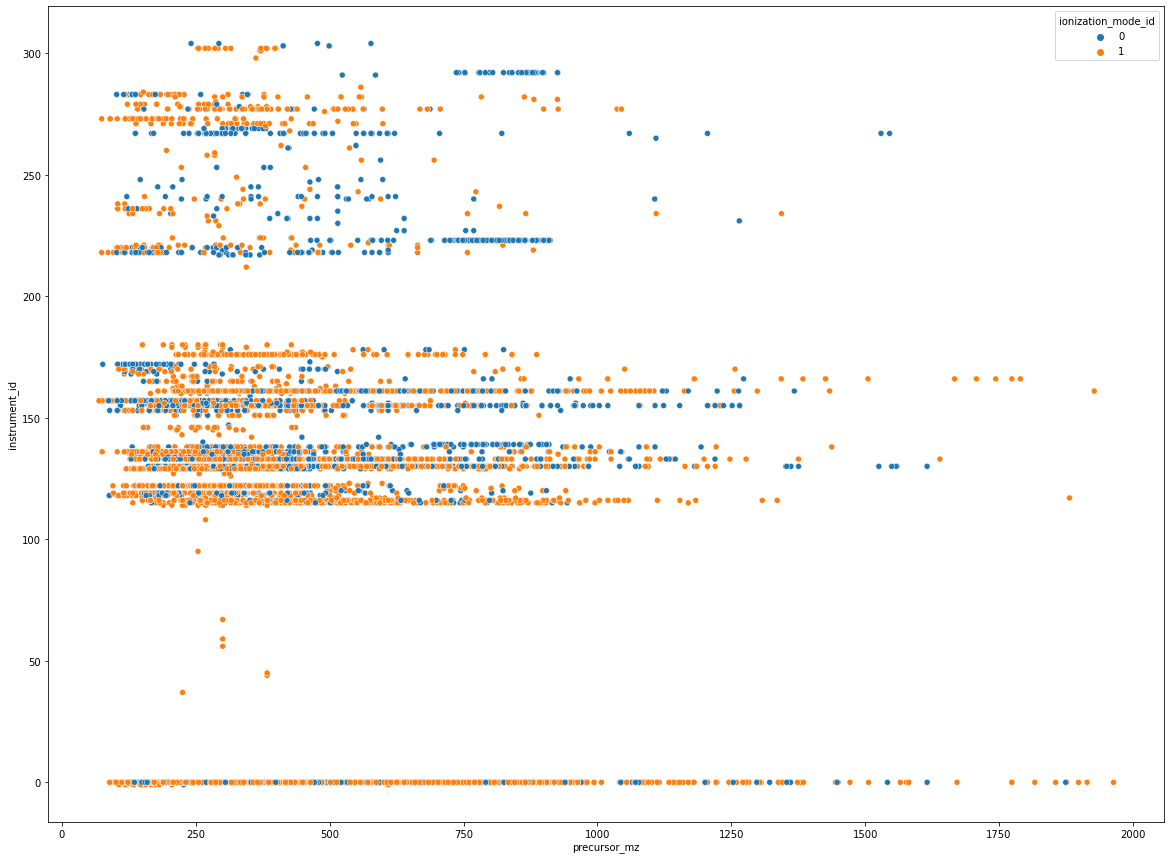

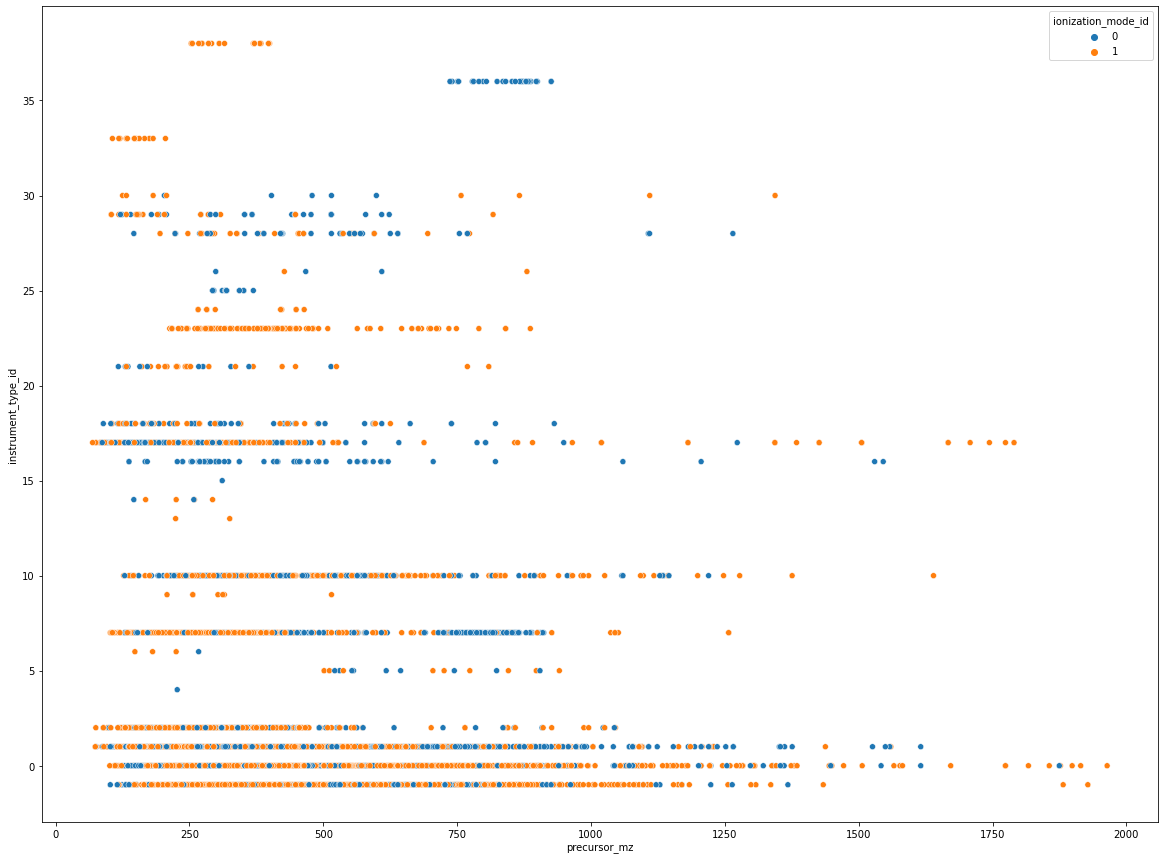

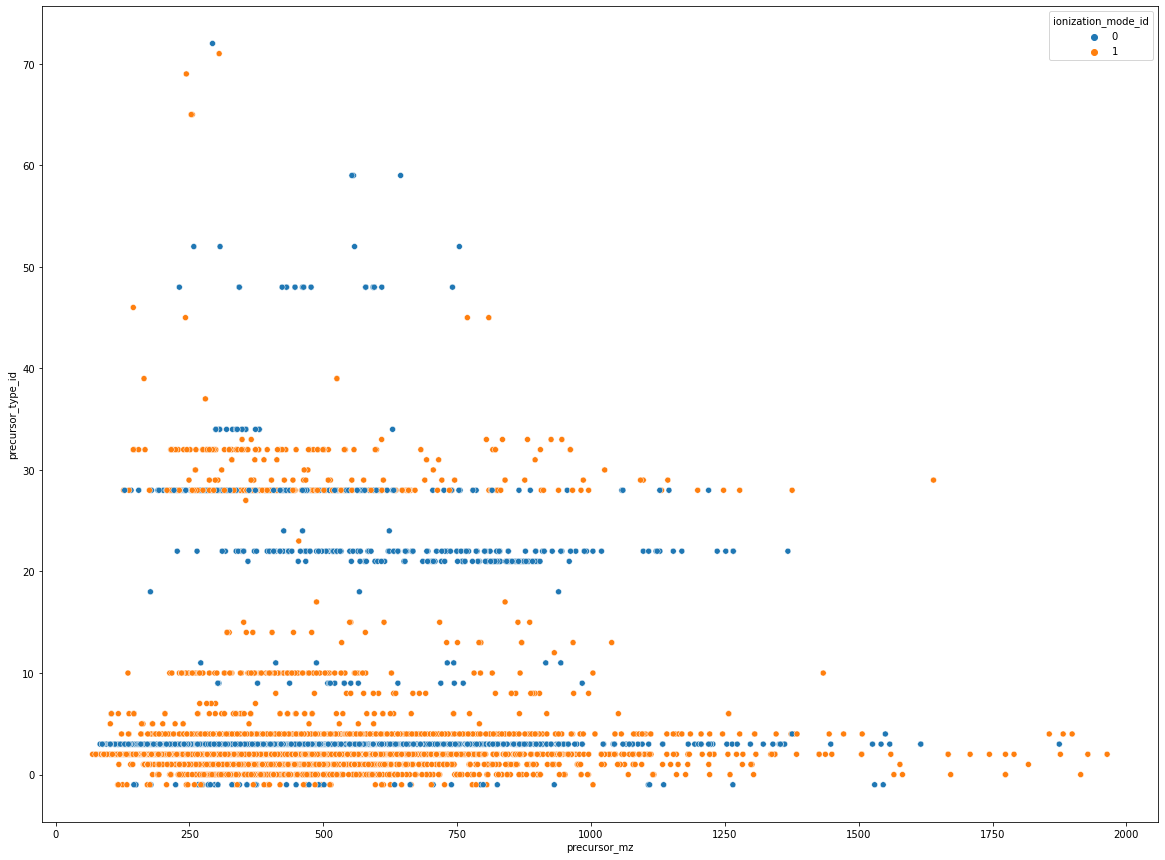

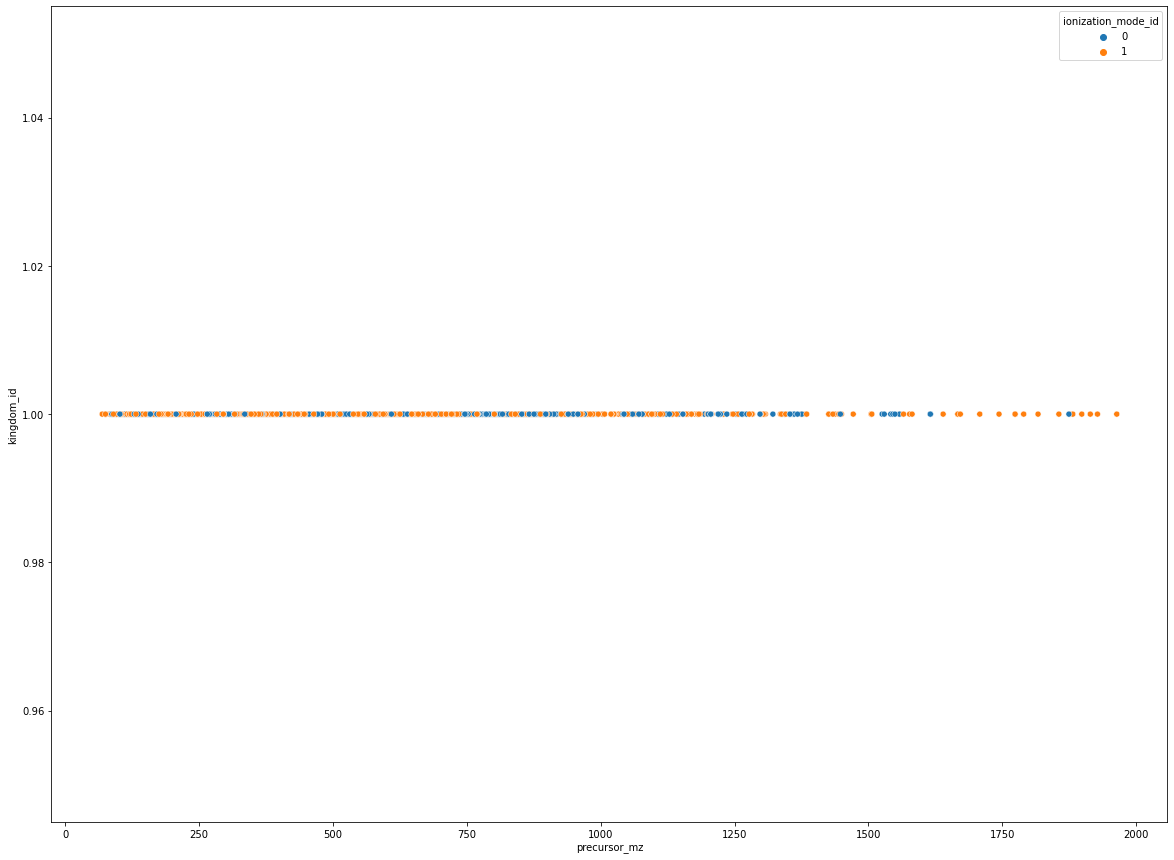

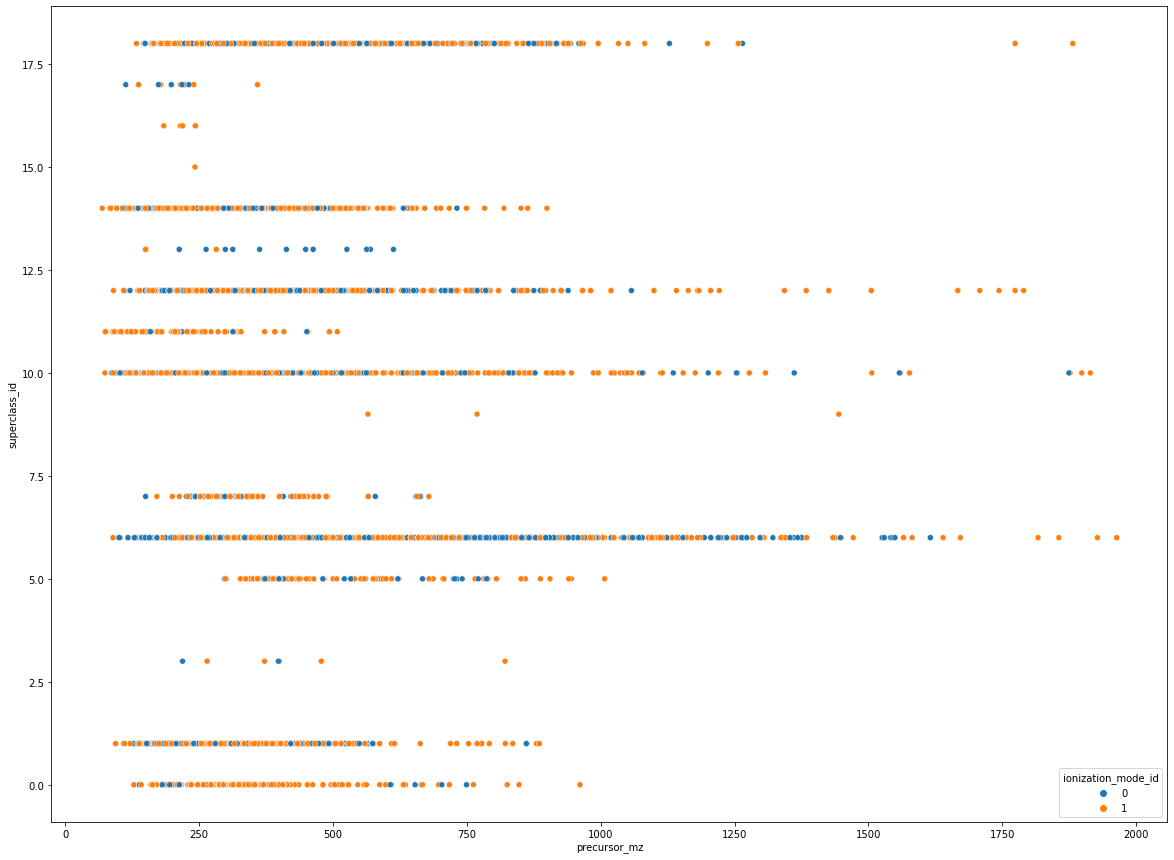

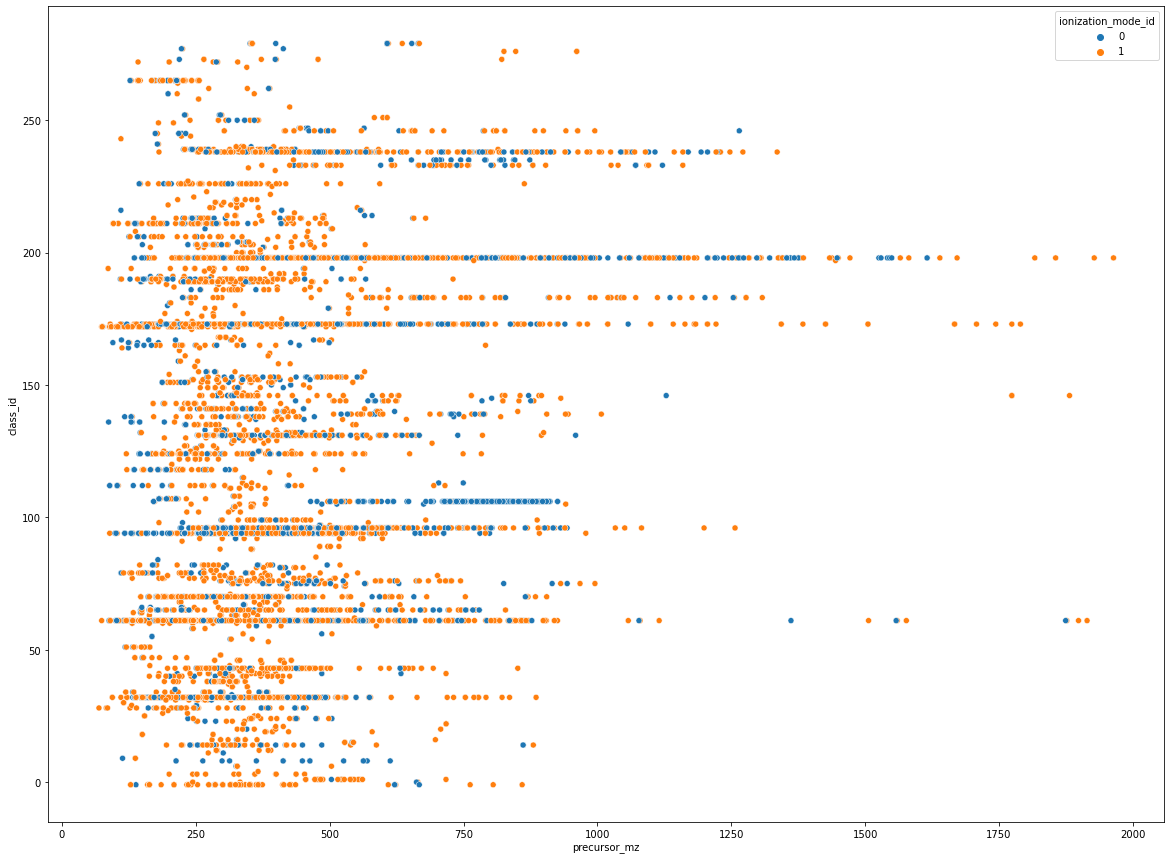

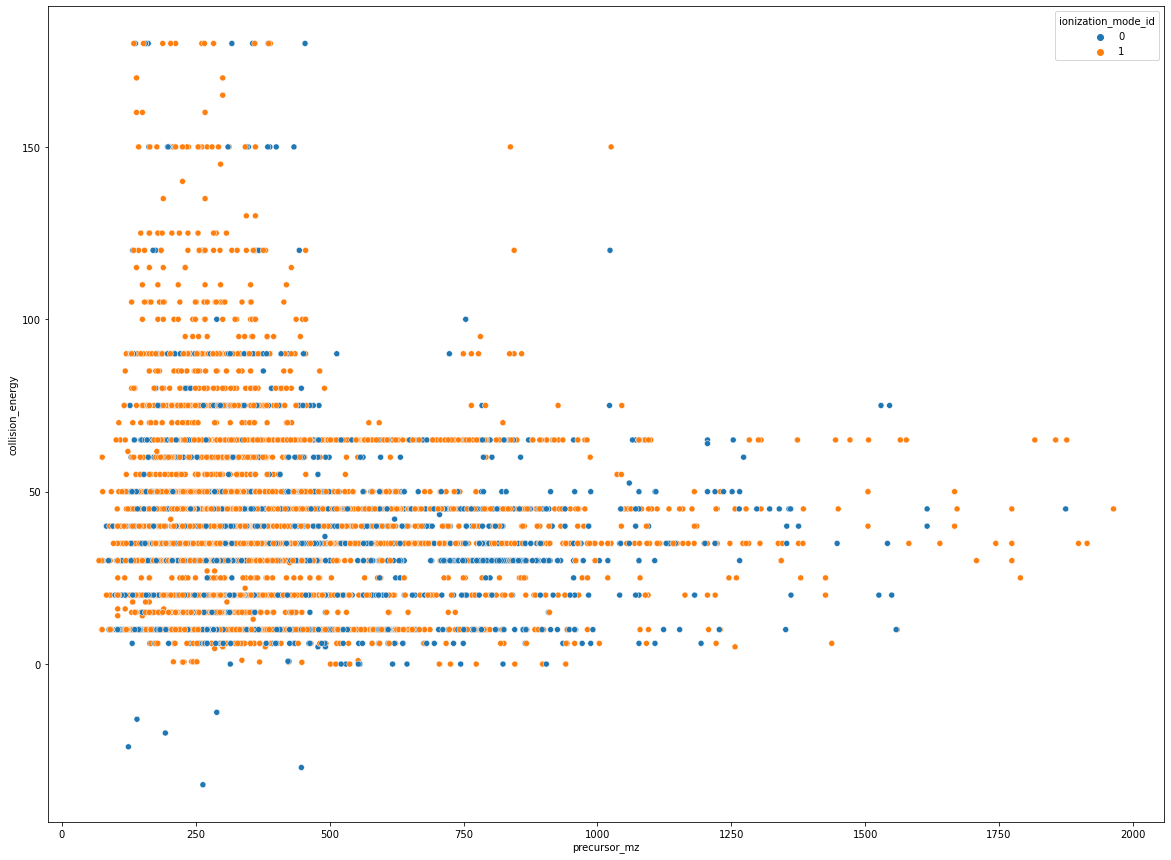

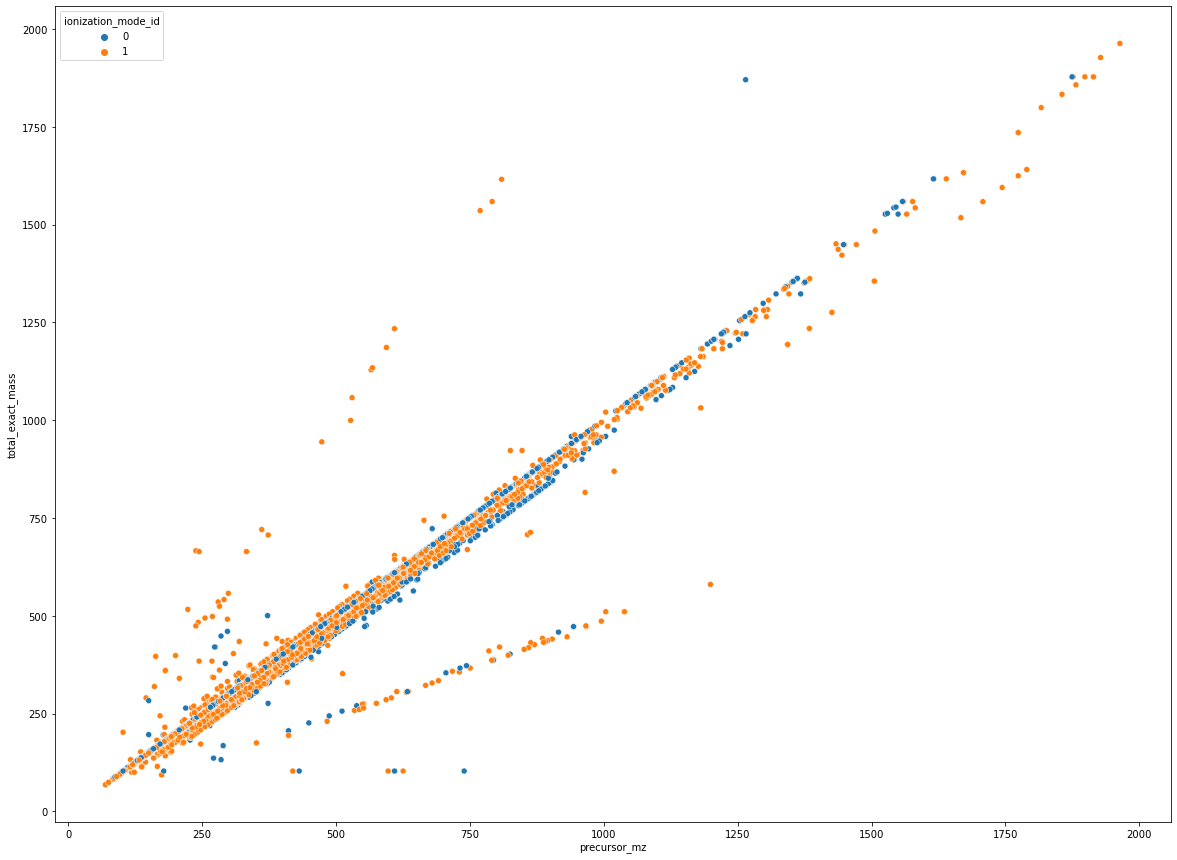

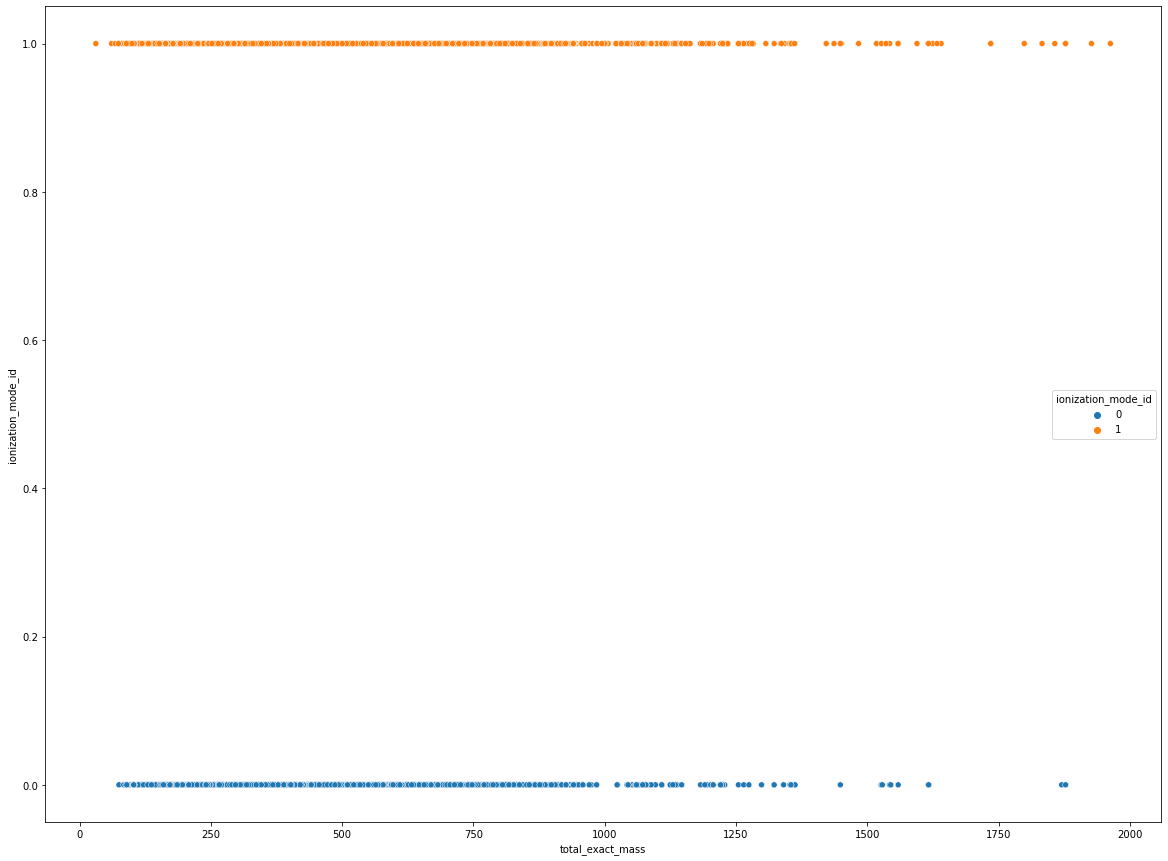

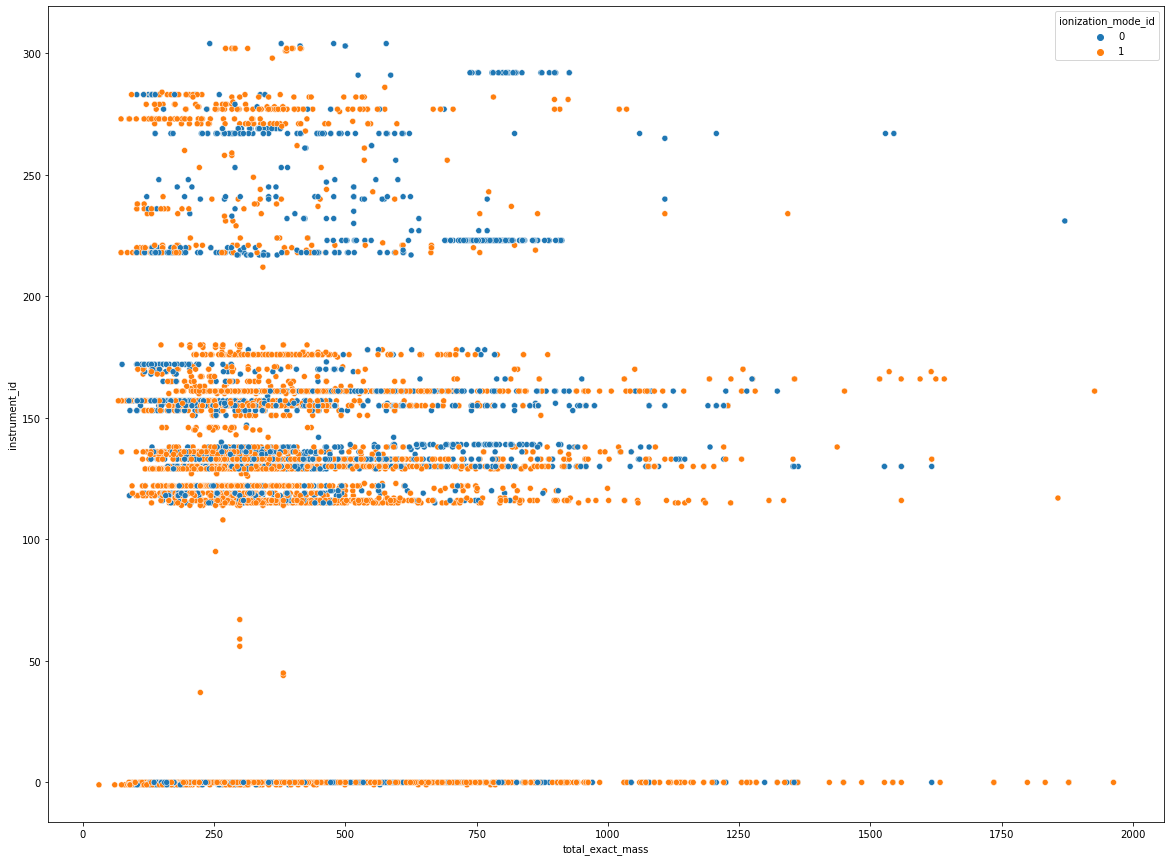

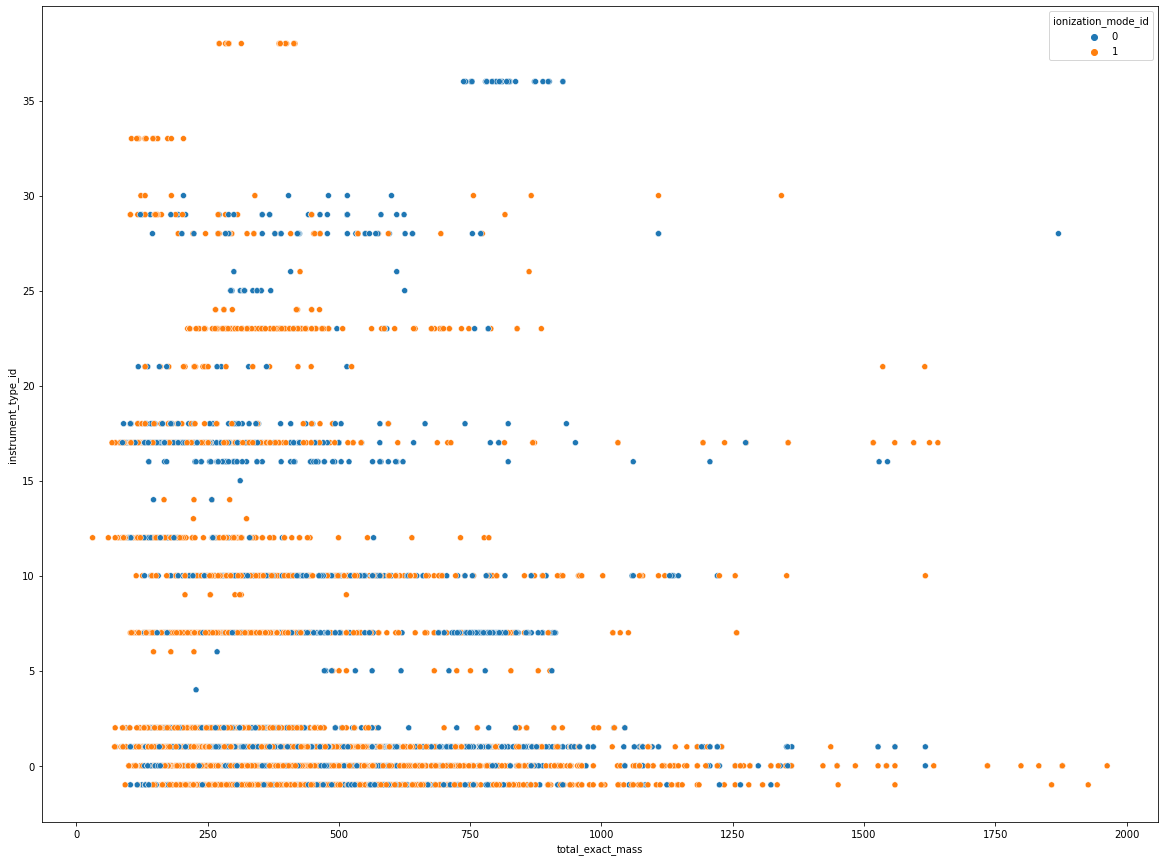

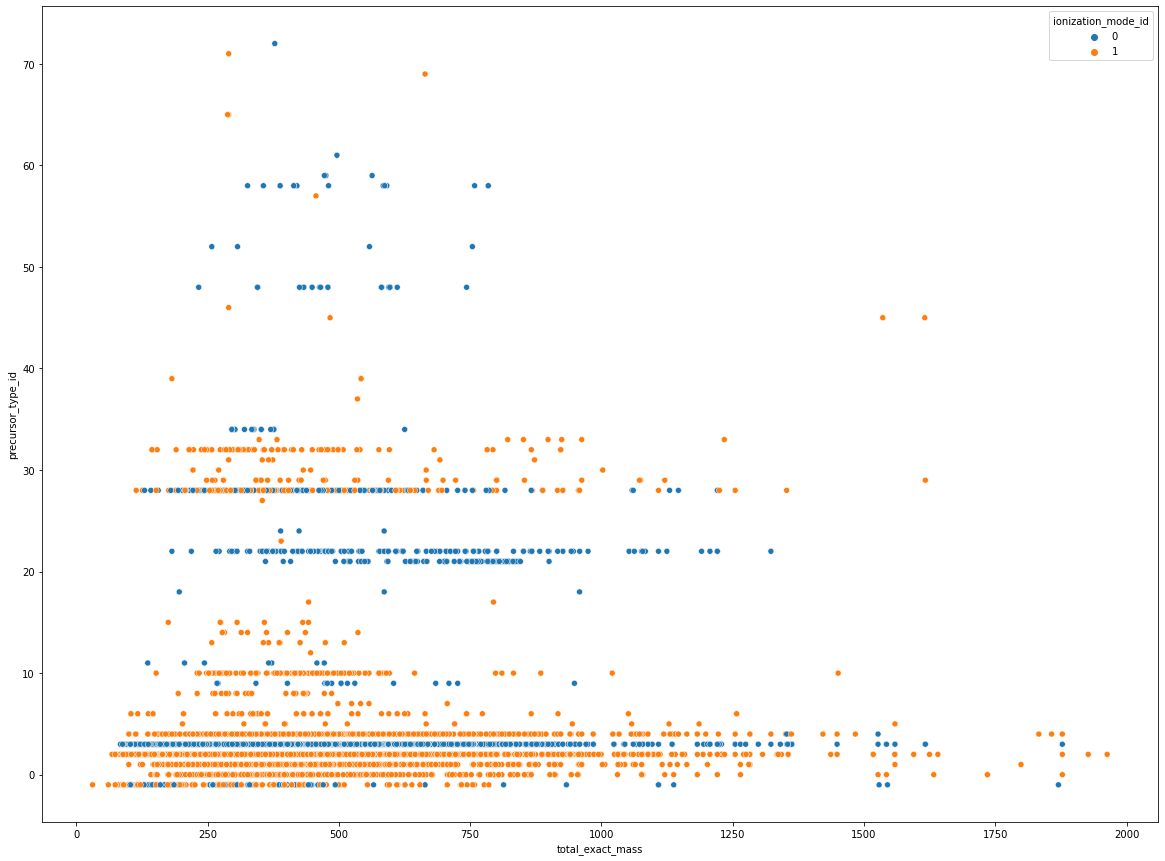

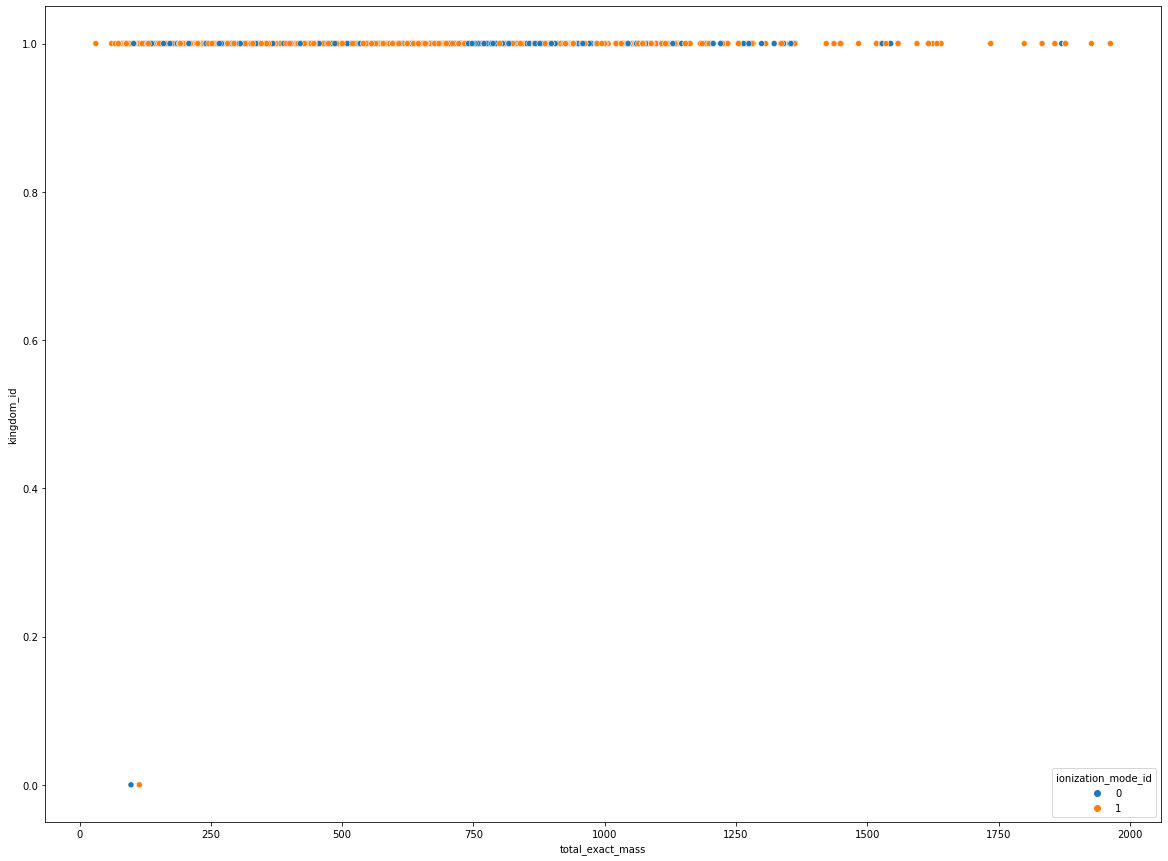

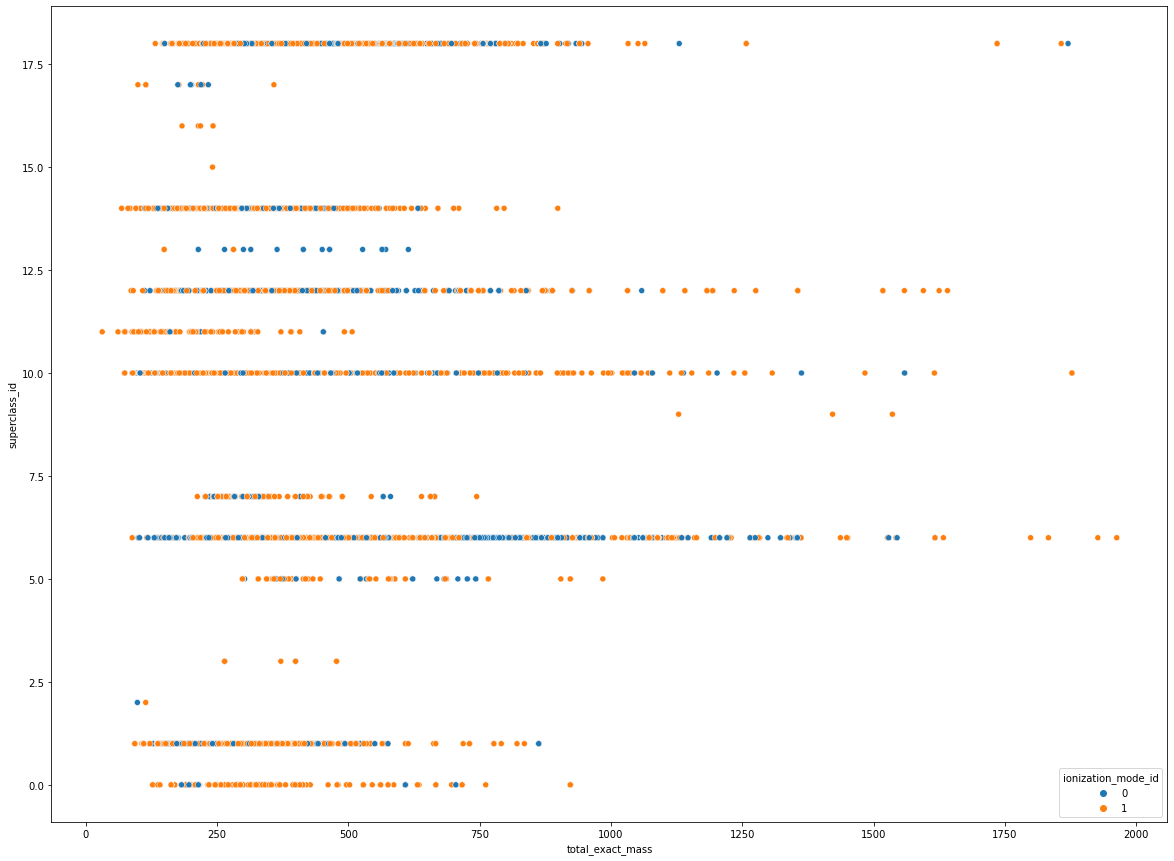

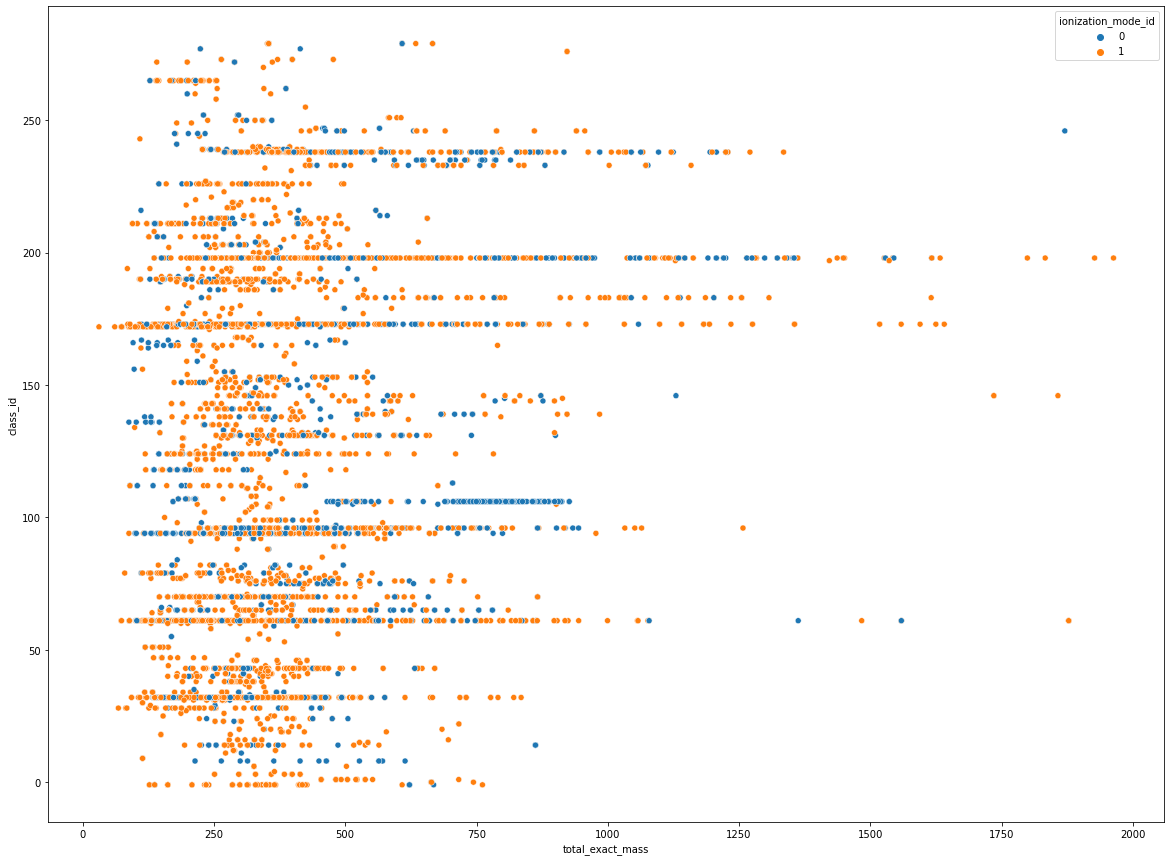

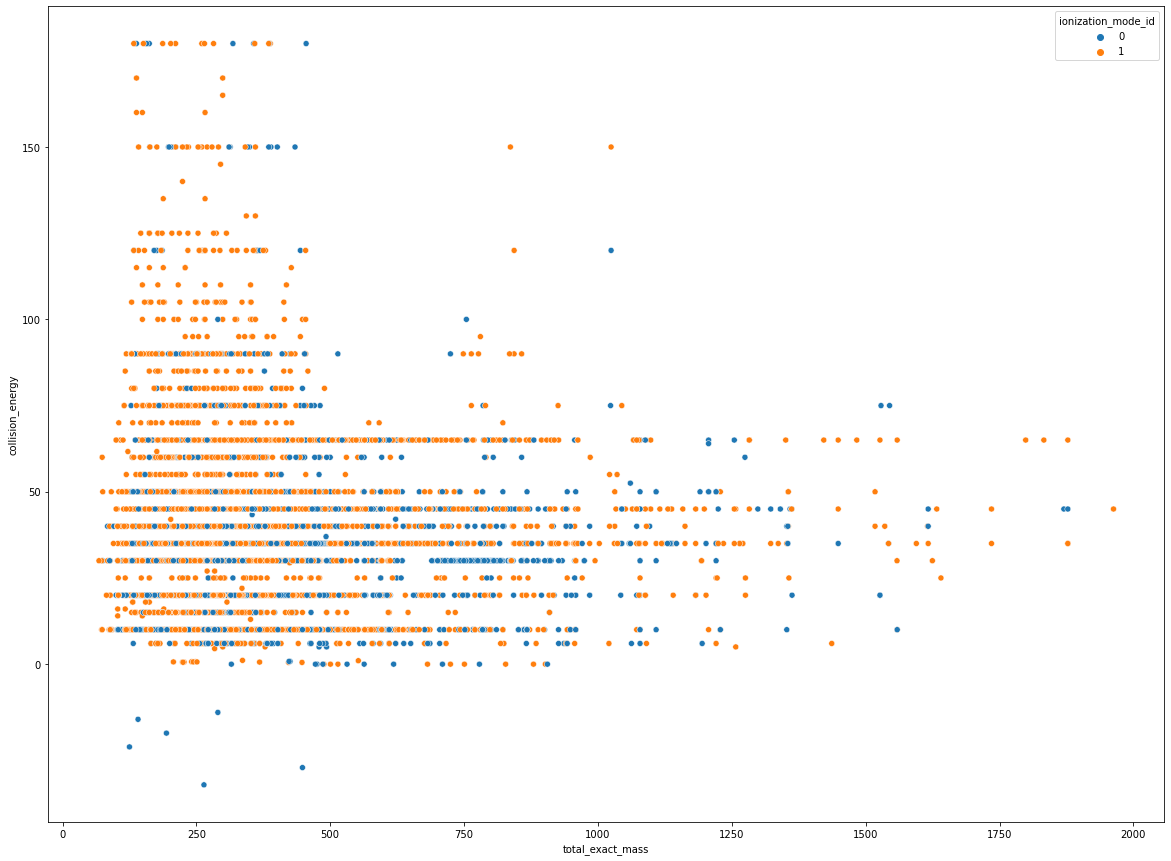

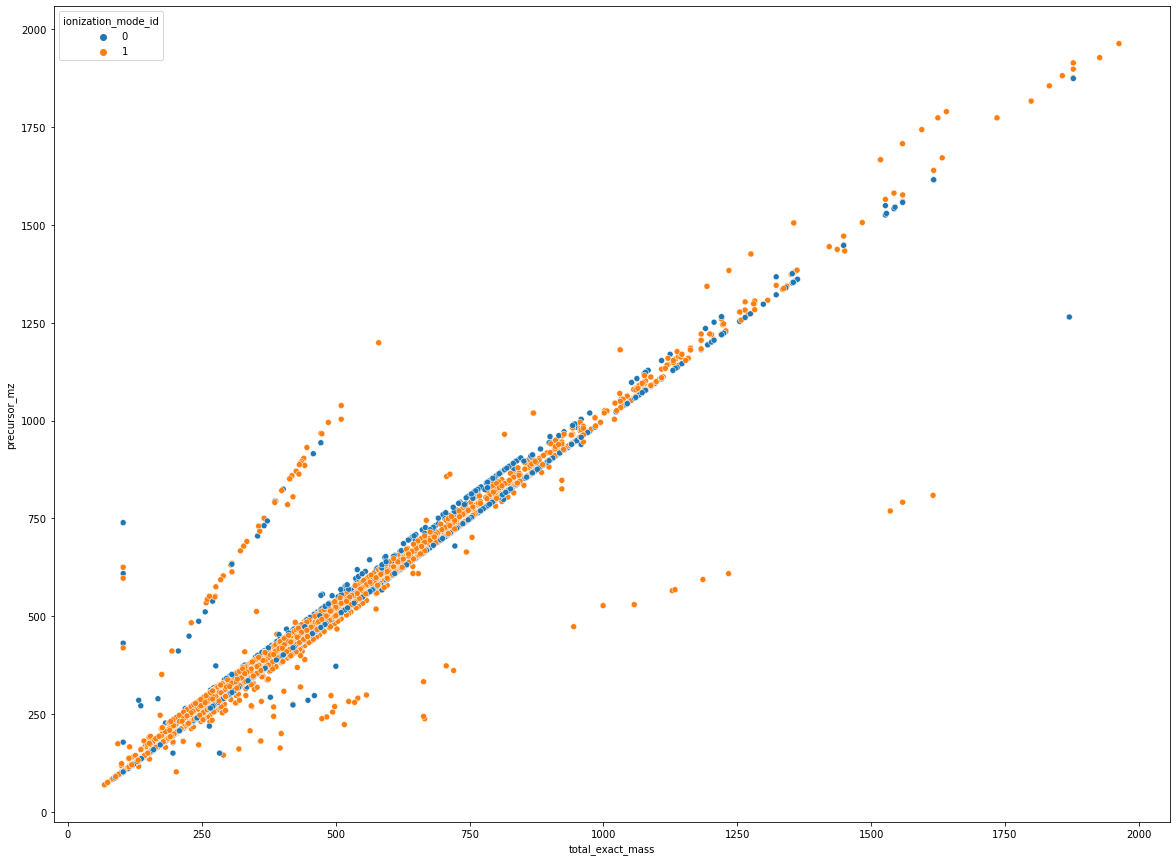

In [16]:
feat_pairs = it.product(labels, labels)
width, height = 1000, 1000

for feat1, feat2 in feat_pairs:
    if feat1 == feat2:
        continue
        
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.scatterplot(data=df1, x=feat1, y=feat2, ax=ax, hue='ionization_mode_id')
    plt.show()
